# DS 2500: Data Wrangling<br>Module Assignment 3
March 1, 2022

Student: Alexander Shahramanyan<br>
Instructor: Professor Marina Kogan

## Introduction
Cryptocurrencies gained significant popularity over the last years and has gathered big communities of traders. In this assignment, I'll use the CoinAPI to get Bitcoin price data and will try to get some insights from it.

## Questions:
1. Is the Bitcoin price data (which is timeseries, of course) stationary (it should be non-stationary, however, I'll use a statistical test to ensure that)?
2. Are number of trades or volume traded correlated with Bitcoin prices? 
3. Is there a correlation between Covid cases and Bitcoin price?
<hr>
0 - Is there a significant difference between the Bitcoin prices of any two consecutive weeks as compared to others?

## Dataset Description:
**Dataset 1: Bitcoin Prices**: from CoinAPI. Contains hourly data on Bitcoin prices for 2020: open time, open and close, high and low, prices, volume traded, and trades count.
<br>

*Columns*:<br>
7 columns
- time_open - datetime
- price_open - float
- price_high - float
- price_low - float
- price_close - float
- volume_traded - float
- trades_count - int

*Number of entries (rows)*: 8759 (366\*24=8784, however API fails to provide some data)<br><hr>

**Dataset 2: Covid Cases**: from John Hopkins University Covid tracking website (via github). Contains daily information on cumulative Covid cases per province/state and country/region.
*Columns*:<br>
 772 columns
- Province/State - string
- Country/Region - string
- Lat (latitude) - float
- Long (longitude) - float
- 1/22/20 - int (cumulative Covid cases)
- .......
- 2/27/22 - int (cumulative Covid cases)

*Number of entries (rows)*: 284

## Setup
First, I import all the libraries I will need throughout the notebook and set the plotting parameters for better visualizations.

In [1]:
import json
import requests
import pandas as pd
import time
import datetime as dt
import json
from scipy.stats import stats, pearsonr
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
import seaborn as sns
import textwrap

# Plotting settings
plt.style.use('seaborn')
plt.rcParams['figure.figsize'] = (16, 6)
plt.rcParams['figure.dpi'] = 150
plt.rcParams['font.size'] = 18
plt.rcParams['axes.labelsize'] = 16
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['font.family'] = 'serif'

CoinAPI-Keys:<br>
 - 7C42C2B0-B30F-4988-9B5C-6F6EE0237D3E  <br>
 - 49BAD700-37F7-4776-9A80-E95274FE737A  <br>
 - D6F38463-FC87-4C68-AF3A-FBCC83F2A57D  <br>
 - E87012DB-899D-41CD-A2D7-CB6510046225  <br>
 - 1BB08CB1-10A5-44CF-9B48-72245E12F41D  <br>
 - 831F56DE-37FD-4D77-B4FC-FE72108716A0

## Get Data

Next, I define a function that gets data from CoinAPI. Since there is a limit on the amount of data that that can be get per request, I will call this function repeatedly in order to get hourly data for a full year.

In [2]:
def get_data(symbol="BINANCE_SPOT_BTC_USDT", start_date="2020-01-01", end_date="2020-12-31", step="1HRS", convert_date_times=True):
    """
    Gets and returns the price data of the symbol, for the given time interval and frequence.
    
    Keyword parameters:
        symbol            - the symbol whose price data should be downloaded.
                           Default: "BINANCE_SPOT_BTC_USDT"
                
        start_date         - the start date.
                           Default: "2020-01-01"
        
        end_date           - the end date.
                           Default: "2020-12-31"
        
        step               - the frequency of the data.
                           Possible values: 1SEC, 2SEC, 3SEC, 4SEC, 5SEC, 6SEC, 10SEC, 15SEC, 20SEC, 30SEC,
                                            1MIN, 2MIN, 3MIN, 4MIN, 5MIN, 6MIN, 10MIN, 15MIN, 20MIN, 30MIN,
                                            1HRS, 2HRS, 3HRS, 4HRS, 6HRS, 8HRS, 12HRS,
                                            1DAY, 2DAY, 3DAY, 5DAY, 7DAY, 10DAY.
                           Default: "1HRS"
            
        convert_date_times - if true, will convert the start and end dates from
                           'YYYY-MM-DD' into a datetime object, otherwise considers
                           the dates are datetimes.
                           Default: True
    Returns:
        A list of json objects witht the price data.
    """
    # Header for the request
    headers = {"X-CoinAPI-Key" : "7C42C2B0-B30F-4988-9B5C-6F6EE0237D3E"}
    
    # List for the JSON objects
    responses = []
    
    # Convert the start and end dates into datetimes if needed
    if convert_date_times:
        start_date = dt.datetime.combine(dt.date.fromisoformat(start_date), dt.time(0, 0, 0, 0))
        end_date = dt.datetime.combine(dt.date.fromisoformat(end_date), dt.time(23, 59, 0, 0))
    
    # Convert the end date into the required string format to use in the link
    end_date_str = end_date.strftime("%Y-%m-%dT%H:%M:%S")
    
    if step[-3:] == "SEC":
        window = dt.timedelta(seconds = int(step[:-3])*100)
    elif step[-3:] == "MIN":
        window = dt.timedelta(minutes = int(step[:-3])*100)
    elif step[-3:] == "HRS":
        window = dt.timedelta(hours = int(step[:-3])*100)
    elif step[-3:] == "DAY":
        window = dt.timedelta(days = int(step[:-3])*100)
    else:
        raise ValueError("Illegal step argument.")

    # While there still is data to download
    while start_date <= end_date:
        # Convert the current start time into the requiored string format to use in the link
        start = start_date.strftime("%Y-%m-%dT%H:%M:%S")
        
        # Add the windows to the start date
        start_date += window
        
        # Create the url
        url = f"https://rest.coinapi.io/v1/ohlcv/{symbol}/history?period_id={step}&time_start={start}&time_end={end_date_str}"
        
        # Send the request and store the response
        response = requests.get(url, headers=headers)
        
        # Not OK API responses
        if response.status_code != 200:
            if response.status_code == 400:
                print("Bad Request -- There is something wrong with your request.")
            elif response.status_code == 401:
                print("Unauthorized -- Your API key is wrong.")
            elif response.status_code == 403:
                print("Forbidden -- Your API key doesnt't have enough privileges to access this resource.")
            elif response.status_code == 429:
                print("Too many requests -- You have exceeded your API key rate limits.")
            elif response.status_code == 550:
                print("No data -- You requested specific single item that we don't have at this moment.")
            
            print("Exiting function.")
            
            return responses
        
        # Add the JSON objects to the list
        responses += response.json()
        
        # Wait for a second
        time.sleep(1)
        
    return responses

I will also need to make a dataframe from the JSON objects. For that, I will create another function.

In [3]:
def to_df(responses):
    """
    Creates a dataframe from the JSON objects and return. Converts the time columns into datetime.
    
    Keyword parameters:
        responses - a list with JSON objects.
        
    Returns:
        A dataframe created from the JSON objects.
    """
    # Initialize a dataframe from the responses
    df = pd.DataFrame(responses)
    
    # Change the types of the time columns to datetime
    for col in [x for x in df.columns if "time" in x]:
        df[col] = pd.to_datetime(df[col])
    
    # Drop duplicates
    df.drop_duplicates(inplace=True)
    
    # Sort the data by time_open
    df.sort_values('time_period_start', inplace=True)
    
    # Reset index
    df.reset_index(drop=True, inplace=True)
    
    return df

In [4]:
# Download the data
responses = get_data(symbol="BINANCE_SPOT_BTC_USDT", start_date="2020-01-01", end_date="2020-12-31",\
                     step="1HRS", convert_date_times=True)

In [5]:
# Create a dataframe from the downloaded data
df = to_df(responses)

## Dataset Check

In [6]:
# Load the dataset
# df = pd.read_csv("BTCUSDT_2020.csv", index_col=0)

We should have 366*24 = 8784 rows in the dataframe. I'll check that using df.shape.

In [7]:
# Check dataset shape
df.shape

(8759, 10)

As we see, we have only 8759 rows. There seems to be some error with the CoinAPI, I'll try to get the missing data again. Now, I'll check the top and bottom of the data, to ensure the start and end dates are correct.

In [8]:
# Check the top of the data
df.head()

time_period_start           time_period_end  \
0 2020-01-01 00:00:00+00:00 2020-01-01 01:00:00+00:00   
1 2020-01-01 01:00:00+00:00 2020-01-01 02:00:00+00:00   
2 2020-01-01 02:00:00+00:00 2020-01-01 03:00:00+00:00   
3 2020-01-01 03:00:00+00:00 2020-01-01 04:00:00+00:00   
4 2020-01-01 04:00:00+00:00 2020-01-01 05:00:00+00:00   

                         time_open                       time_close  \
0 2020-01-01 00:00:00.594000+00:00 2020-01-01 00:59:59.701000+00:00   
1 2020-01-01 01:00:01.487000+00:00 2020-01-01 01:59:58.788000+00:00   
2 2020-01-01 02:00:00.014000+00:00 2020-01-01 02:59:59.221000+00:00   
3 2020-01-01 03:00:00.291000+00:00 2020-01-01 03:59:59.923000+00:00   
4 2020-01-01 04:00:00.731000+00:00 2020-01-01 04:59:59.473000+00:00   

   price_open  price_high  price_low  price_close  volume_traded  trades_count  
0     7195.24     7196.25    7175.46      7177.02     511.814901          7640  
1     7176.47     7230.00    7175.71      7216.27     883.052603          9033  
2     7215.52     7244.87    7211.41      7242.85     655.156809          7466  
3     7242.66     7245.00    7220.00      7225.01     783.724867          8337  
4     7225.00     7230.00    7215.03      7217.27     467.812578          5896

In [9]:
# Check the bottom of the data
df.tail()

time_period_start           time_period_end  \
8754 2020-12-31 19:00:00+00:00 2020-12-31 20:00:00+00:00   
8755 2020-12-31 20:00:00+00:00 2020-12-31 21:00:00+00:00   
8756 2020-12-31 21:00:00+00:00 2020-12-31 22:00:00+00:00   
8757 2020-12-31 22:00:00+00:00 2020-12-31 23:00:00+00:00   
8758 2020-12-31 23:00:00+00:00 2021-01-01 00:00:00+00:00   

                            time_open                       time_close  \
8754 2020-12-31 19:00:00.127000+00:00 2020-12-31 19:59:59.920000+00:00   
8755 2020-12-31 20:00:00.045000+00:00 2020-12-31 20:59:59.798000+00:00   
8756 2020-12-31 21:00:00.010000+00:00 2020-12-31 21:59:59.125000+00:00   
8757 2020-12-31 22:00:00.583000+00:00 2020-12-31 22:59:59.595000+00:00   
8758 2020-12-31 23:00:00.169000+00:00 2020-12-31 23:59:59.993000+00:00   

      price_open  price_high  price_low  price_close  volume_traded  \
8754    28872.24    29000.00   28742.41     28897.83    2293.821339   
8755    28897.84    29139.65   28862.00     29126.70    1936.480299   
8756    29126.71    29169.55   28900.79     28966.36    2524.473111   
8757    28966.36    29143.73   28910.19     29100.84    1438.506326   
8758    29100.83    29110.35   28780.00     28923.63    1976.419299   

      trades_count  
8754         56789  
8755         42101  
8756         51297  
8757         36413  
8758         46165

In [10]:
# Check the number of rows in the dataframe
len(df)

8759

In [11]:
# Check null values
df.isnull().sum()

time_period_start    0
time_period_end      0
time_open            0
time_close           0
price_open           0
price_high           0
price_low            0
price_close          0
volume_traded        0
trades_count         0
dtype: int64

I'll only keep only one time data column. The others are unnecessary.

In [12]:
# Keep only one time data column
df = df[['time_period_start', 'price_open', 'price_high', 'price_low',\
         'price_close', 'volume_traded', 'trades_count']]

In [13]:
# Rename the time data column
df.rename(columns = {'time_period_start':'time_open'}, inplace = True)

Try to download the missing data again.

In [14]:
# Try to download the missing data again using the API
for row in range(1, len(df.index)):
    # If the difference between two consecutive values is not 1, download the data between 
    if abs(df.time_open[row] - df.time_open[row-1] - dt.timedelta(hours=1)) > dt.timedelta(minutes=5):
        start_date = df.time_open[row-1] + dt.timedelta(hours=1)
        end_date = df.time_open[row]
        
        responses = get_data(start_date=start_date, end_date=end_date, step="1HRS", convert_date_times=False)

        # If nothing was returned from the request, continue
        if responses == []:
            continue
        
        # Print the JSON objects returned
        print(responses)
        
        # Create a dataframe from the new JSON objects
        df_add = to_df(responses)
    
        df_add = df_add[['time_period_start', 'price_open', 'price_high', 'price_low',\
             'price_close', 'volume_traded', 'trades_count']]
        
        df_add.rename(columns = {'time_period_start':'time_open'}, inplace = True)

        # Append the new data to the dataframe
        df = df.append(df_add, ignore_index = True)
        
# Drop duplicates
df.drop_duplicates(inplace=True)
    
# Sort the data by time_open
df.sort_values('time_open', inplace=True)
    
# Reset index
df.reset_index(drop=True, inplace=True)

In [15]:
# Check the number of rows in the dataframe
len(df)

8759

As we see, no new rows were added. There seems to be some problem with the API. Since only 25 entries are missing, there is no need to worry. I will now plot the priceline (close prices) to see if there is any trend.

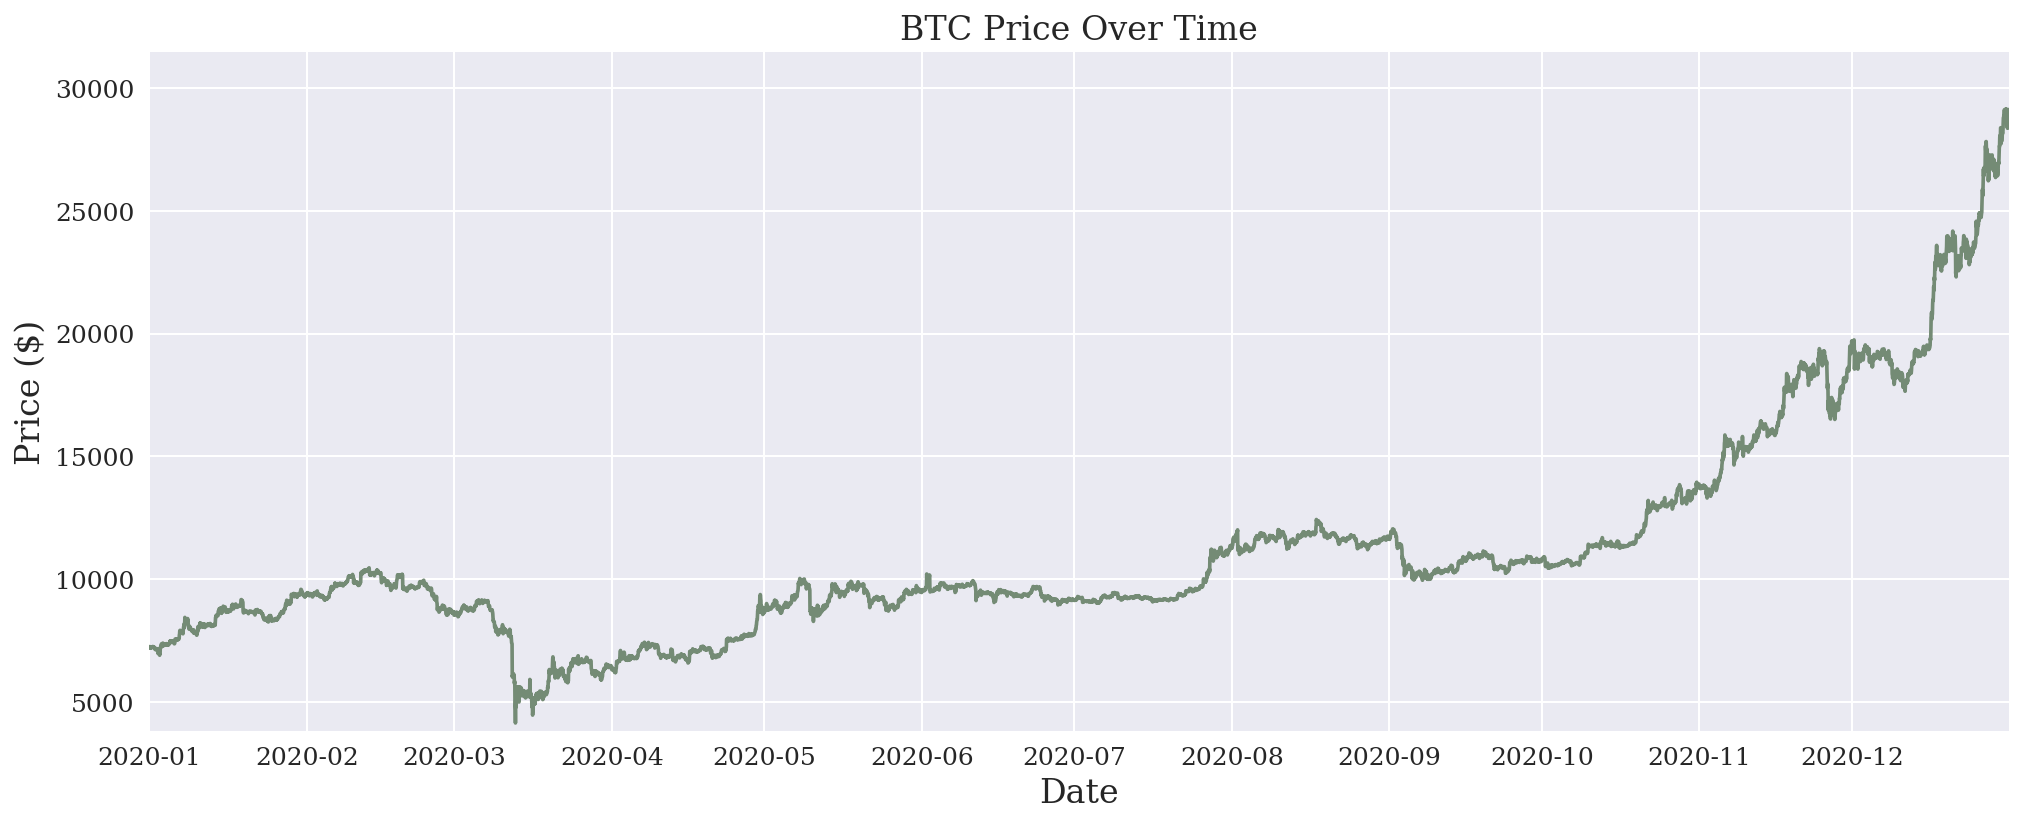

In [16]:
# Priceline
ax = sns.lineplot(x="time_open", y="price_close", data=df, color='#748B75')

# Set y-axis label
ax.set_ylabel("Price ($)")

# Set x-axis label
ax.set_xlabel("Date")

# Set x limits
ax.set_xlim(df.iloc[0].time_open, df.iloc[-1].time_open)

# Set y limits
ax.set_ylim(df.price_close.min()*.92, df.price_close.max()*1.08)

# Title
ax.set_title("BTC Price Over Time")

# Show the plot
plt.show()

There is a steady increaseing trend in the close prices over the year.

## Q1: Stationary or Non-Stationary

Here, I'll check if the price data is stationary or not. Stationarity implies that taking consecutive samples of data with the same size should have identical covariances regardless of the starting point. The Bitcoin price is very volatile and has changed significantly and rapidly over time. So it should not be stationary. To check that I'll conduct a Dickey-Fuller Test.

In [17]:
def adf_test(timeseries):
    """
    Calculates and prints the results of Dickey-Fuller test on the given timeseries.
    
    Keyword parameters:
        timeseries - the timeseries, on which the Dickey-Fuller test should be calculated.
    """
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

In [18]:
dftest = adf_test(df['price_close'])

Results of Dickey-Fuller Test:
Test Statistic                    3.477746
p-value                           1.000000
#Lags Used                       35.000000
Number of Observations Used    8723.000000
Critical Value (1%)              -3.431100
Critical Value (5%)              -2.861871
Critical Value (10%)             -2.566946
dtype: float64


The p-value is greater than 0.05, the timeseries is non-stationary.

## Q2: Correlations Between Price and Trades count

I'll calculate correlation between a couple of variables.

In [19]:
corr, _ = pearsonr(df["volume_traded"], df["trades_count"])
print('Pearsons correlation: %.3f' % corr)

Pearsons correlation: 0.832


As we can see, there is a strong correlation between `volume_traded` and `trades_count`. This is quite logical. Now, I'll see if `trades_count` or `volume_traded` is correlated with `price_close`.

In [20]:
corr, _ = pearsonr(df["trades_count"], df["price_close"])
print('Pearsons correlation: %.3f' % corr)

Pearsons correlation: 0.443


In [21]:
corr, _ = pearsonr(df["volume_traded"], df["price_close"])
print('Pearsons correlation: %.3f' % corr)

Pearsons correlation: 0.019


`trades_count` and `price_close` are correlated (to some extent). This means more trades are done when the close price is high. However, there is no correlation between `volume_traded` and `price_close`, meaning the volume traded is not realted with the close price, even though the higher the close price the more trades are done.

## Q3: Covid cases and Bitcoin price

## Load and Check Data

Now, I'll try to see if there was any correlation between the covid cases (both daily and cumulative) and Bitcoin price. First, I read the csv file with Covid cases data into a dataframe.

In [22]:
covid_df = pd.read_csv("https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv")

Next, I check the dataset.

In [23]:
# Check dataset shape
covid_df.shape

(284, 773)

In [24]:
# Check the top of the data
covid_df.head()

Province/State Country/Region       Lat       Long  1/22/20  1/23/20  \
0            NaN    Afghanistan  33.93911  67.709953        0        0   
1            NaN        Albania  41.15330  20.168300        0        0   
2            NaN        Algeria  28.03390   1.659600        0        0   
3            NaN        Andorra  42.50630   1.521800        0        0   
4            NaN         Angola -11.20270  17.873900        0        0   

   1/24/20  1/25/20  1/26/20  1/27/20  ...  2/19/22  2/20/22  2/21/22  \
0        0        0        0        0  ...   171931   172205   172441   
1        0        0        0        0  ...   269904   270164   270370   
2        0        0        0        0  ...   263936   264054   264201   
3        0        0        0        0  ...    37589    37589    37589   
4        0        0        0        0  ...    98617    98638    98658   

   2/22/22  2/23/22  2/24/22  2/25/22  2/26/22  2/27/22  2/28/22  
0   172716   172901   173047   173084   173146   173395   173659  
1   270455   270734   270947   271141   271141   271527   271563  
2   264365   264488   264603   264706   264778   264855   264936  
3    37820    37901    37958    37999    37999    37999    37999  
4    98671    98698    98701    98701    98701    98701    98741  

[5 rows x 773 columns]

In [25]:
# Check the bottom of the data
covid_df.tail()

Province/State        Country/Region        Lat        Long  1/22/20  \
279            NaN    West Bank and Gaza  31.952200   35.233200        0   
280            NaN  Winter Olympics 2022  39.904200  116.407400        0   
281            NaN                 Yemen  15.552727   48.516388        0   
282            NaN                Zambia -13.133897   27.849332        0   
283            NaN              Zimbabwe -19.015438   29.154857        0   

     1/23/20  1/24/20  1/25/20  1/26/20  1/27/20  ...  2/19/22  2/20/22  \
279        0        0        0        0        0  ...   627956   627956   
280        0        0        0        0        0  ...      508      509   
281        0        0        0        0        0  ...    11731    11736   
282        0        0        0        0        0  ...   311016   311194   
283        0        0        0        0        0  ...   233224   233352   

     2/21/22  2/22/22  2/23/22  2/24/22  2/25/22  2/26/22  2/27/22  2/28/22  
279   633684   636055   638172   640214   640214   640214   640214   645947  
280      509      509      510      510      514      514      518      521  
281    11741    11746    11751    11751    11759    11760    11769    11771  
282   311264   311592   311888   312118   312374   312611   312707   312750  
283   233571   233980   234589   234967   235467   235803   235803   236380  

[5 rows x 773 columns]

In [26]:
# Check the number of rows in the dataframe
len(covid_df)

284

In [27]:
# Check null values
covid_df.isnull().sum()

Province/State    195
Country/Region      0
Lat                 2
Long                2
1/22/20             0
                 ... 
2/24/22             0
2/25/22             0
2/26/22             0
2/27/22             0
2/28/22             0
Length: 773, dtype: int64

I won't use the `Province/State` column, so no need to impute or drop nulls. Since I will only need the daily Covid cases worldwide for 2020, I will only keep the columns with 2020 data and combine the cases from all countries.

In [28]:
# Columns with 2020 data
date_cols = [x for x in covid_df.columns if x[-3:] == '/20']

In [29]:
# Keep the columns with 2020 data
covid_df = covid_df[date_cols]

In [30]:
# Check the dataset
covid_df

1/22/20  1/23/20  1/24/20  1/25/20  1/26/20  1/27/20  1/28/20  1/29/20  \
0          0        0        0        0        0        0        0        0   
1          0        0        0        0        0        0        0        0   
2          0        0        0        0        0        0        0        0   
3          0        0        0        0        0        0        0        0   
4          0        0        0        0        0        0        0        0   
..       ...      ...      ...      ...      ...      ...      ...      ...   
279        0        0        0        0        0        0        0        0   
280        0        0        0        0        0        0        0        0   
281        0        0        0        0        0        0        0        0   
282        0        0        0        0        0        0        0        0   
283        0        0        0        0        0        0        0        0   

     1/30/20  1/31/20  ...  12/22/20  12/23/20  12/24/20  12/25/20  12/26/20  \
0          0        0  ...     50888     51070     51357     51595     51764   
1          0        0  ...     53814     54317     54827     55380     55755   
2          0        0  ...     96069     96549     97007     97441     97857   
3          0        0  ...      7633      7669      7699      7756      7806   
4          0        0  ...     16802     16931     17029     17099     17149   
..       ...      ...  ...       ...       ...       ...       ...       ...   
279        0        0  ...    125506    127376    129080    130598    131904   
280        0        0  ...         0         0         0         0         0   
281        0        0  ...      2087      2087      2092      2092      2092   
282        0        0  ...     18881     19122     19234     19571     19671   
283        0        0  ...     12544     12656     12786     12880     12963   

     12/27/20  12/28/20  12/29/20  12/30/20  12/31/20  
0       51848     52007     52147     52330     52330  
1       56254     56572     57146     57727     58316  
2       98249     98631     98988     99311     99610  
3        7821      7875      7919      7983      8049  
4       17240     17296     17371     17433     17553  
..        ...       ...       ...       ...       ...  
279    133093    134310    135459    136736    138004  
280         0         0         0         0         0  
281      2094      2096      2096      2097      2099  
282     19834     19943     20177     20462     20725  
283     13077     13148     13325     13625     13867  

[284 rows x 345 columns]

In [31]:
# Convert the column names to datetime objects
date_cols = pd.to_datetime(covid_df.columns, format="%m/%d/%y")
covid_df.columns = date_cols

In [32]:
# Check the dataset
covid_df

2020-01-22  2020-01-23  2020-01-24  2020-01-25  2020-01-26  2020-01-27  \
0             0           0           0           0           0           0   
1             0           0           0           0           0           0   
2             0           0           0           0           0           0   
3             0           0           0           0           0           0   
4             0           0           0           0           0           0   
..          ...         ...         ...         ...         ...         ...   
279           0           0           0           0           0           0   
280           0           0           0           0           0           0   
281           0           0           0           0           0           0   
282           0           0           0           0           0           0   
283           0           0           0           0           0           0   

     2020-01-28  2020-01-29  2020-01-30  2020-01-31  ...  2020-12-22  \
0             0           0           0           0  ...       50888   
1             0           0           0           0  ...       53814   
2             0           0           0           0  ...       96069   
3             0           0           0           0  ...        7633   
4             0           0           0           0  ...       16802   
..          ...         ...         ...         ...  ...         ...   
279           0           0           0           0  ...      125506   
280           0           0           0           0  ...           0   
281           0           0           0           0  ...        2087   
282           0           0           0           0  ...       18881   
283           0           0           0           0  ...       12544   

     2020-12-23  2020-12-24  2020-12-25  2020-12-26  2020-12-27  2020-12-28  \
0         51070       51357       51595       51764       51848       52007   
1         54317       54827       55380       55755       56254       56572   
2         96549       97007       97441       97857       98249       98631   
3          7669        7699        7756        7806        7821        7875   
4         16931       17029       17099       17149       17240       17296   
..          ...         ...         ...         ...         ...         ...   
279      127376      129080      130598      131904      133093      134310   
280           0           0           0           0           0           0   
281        2087        2092        2092        2092        2094        2096   
282       19122       19234       19571       19671       19834       19943   
283       12656       12786       12880       12963       13077       13148   

     2020-12-29  2020-12-30  2020-12-31  
0         52147       52330       52330  
1         57146       57727       58316  
2         98988       99311       99610  
3          7919        7983        8049  
4         17371       17433       17553  
..          ...         ...         ...  
279      135459      136736      138004  
280           0           0           0  
281        2096        2097        2099  
282       20177       20462       20725  
283       13325       13625       13867  

[284 rows x 345 columns]

Since I will need the total cumulative cases and new daily cases, I combine the given data per country and store them in a dataframe.

In [33]:
# Combine the covid cases from all countries
covid_cases = pd.DataFrame(covid_df.sum(), columns=['cases'])

In [34]:
# Check the dataset
covid_cases

cases
2020-01-22       557
2020-01-23       655
2020-01-24       941
2020-01-25      1434
2020-01-26      2118
...              ...
2020-12-27  81029946
2020-12-28  81530857
2020-12-29  82203838
2020-12-30  82940699
2020-12-31  83768272

[345 rows x 1 columns]

In [35]:
# Add a column with daily new cases
covid_cases['daily_cases'] = covid_cases.cases - covid_cases.cases.shift(1, fill_value=0)

In [36]:
# Check the dataset
covid_cases

cases  daily_cases
2020-01-22       557          557
2020-01-23       655           98
2020-01-24       941          286
2020-01-25      1434          493
2020-01-26      2118          684
...              ...          ...
2020-12-27  81029946       411193
2020-12-28  81530857       500911
2020-12-29  82203838       672981
2020-12-30  82940699       736861
2020-12-31  83768272       827573

[345 rows x 2 columns]

Then, I need to merge the Bitcoin price and Covid case dataframes. To do so, I'll create a new column in each dataframe with the day of year, to later merge on. 

In [37]:
df['dayofyear'] = df.time_open.dt.dayofyear

In [38]:
covid_cases['dayofyear'] = covid_cases.index.dayofyear

In [39]:
# Merge on dayofyear
merged_df = pd.merge(df, covid_cases, on='dayofyear').drop('dayofyear', axis=1)

In [40]:
# Check the dataset
merged_df

time_open  price_open  price_high  price_low  \
0    2020-01-22 00:00:00+00:00     8736.04     8758.08    8722.36   
1    2020-01-22 01:00:00+00:00     8739.03     8743.53    8705.00   
2    2020-01-22 02:00:00+00:00     8728.77     8743.57    8701.00   
3    2020-01-22 03:00:00+00:00     8719.52     8726.58    8708.02   
4    2020-01-22 04:00:00+00:00     8715.00     8743.57    8715.00   
...                        ...         ...         ...        ...   
8250 2020-12-31 19:00:00+00:00    28872.24    29000.00   28742.41   
8251 2020-12-31 20:00:00+00:00    28897.84    29139.65   28862.00   
8252 2020-12-31 21:00:00+00:00    29126.71    29169.55   28900.79   
8253 2020-12-31 22:00:00+00:00    28966.36    29143.73   28910.19   
8254 2020-12-31 23:00:00+00:00    29100.83    29110.35   28780.00   

      price_close  volume_traded  trades_count     cases  daily_cases  
0         8739.00    1020.100874         11083       557          557  
1         8728.77     932.967675         10912       557          557  
2         8719.67     737.095770          9674       557          557  
3         8715.77     443.067657          7324       557          557  
4         8740.00     561.078471          8995       557          557  
...           ...            ...           ...       ...          ...  
8250     28897.83    2293.821339         56789  83768272       827573  
8251     29126.70    1936.480299         42101  83768272       827573  
8252     28966.36    2524.473111         51297  83768272       827573  
8253     29100.84    1438.506326         36413  83768272       827573  
8254     28923.63    1976.419299         46165  83768272       827573  

[8255 rows x 9 columns]

Now, I'll plot the Bitcoin prices and # of Covid cases against each other.

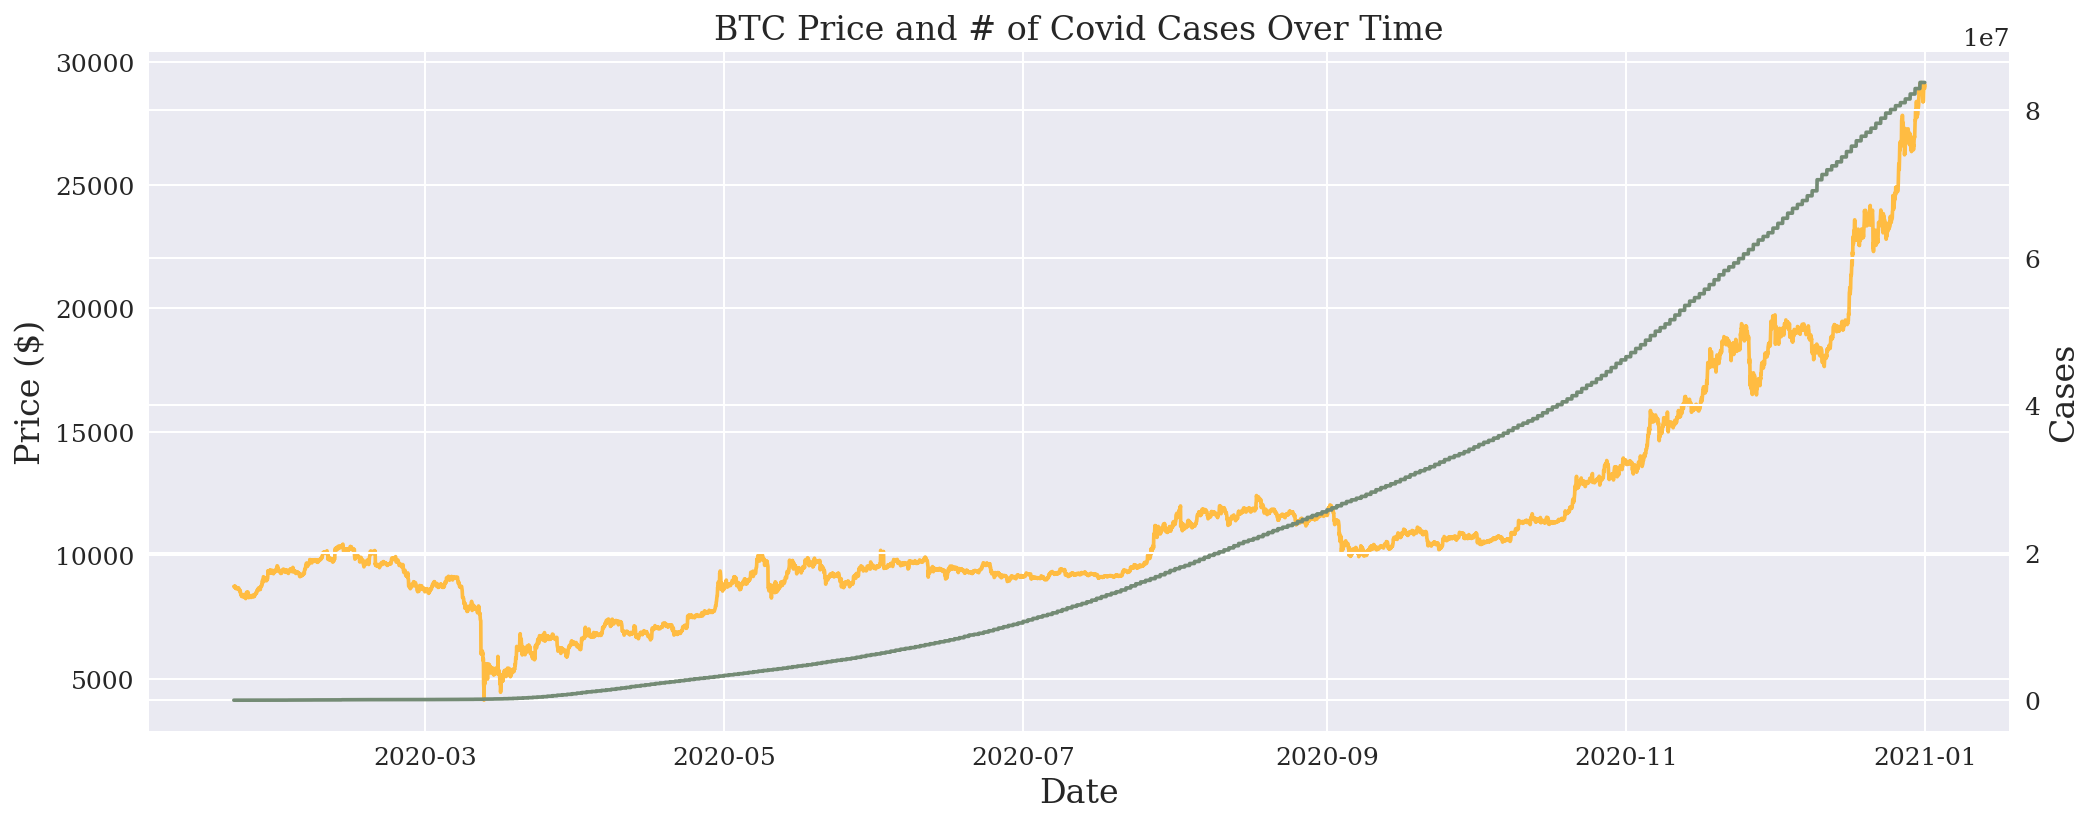

In [41]:
# Price and Covid cases over time
ax = sns.lineplot(x="time_open", y="price_close", data=merged_df, color='#FFBC42')
ax_sec = ax.twinx()    
ax_sec = sns.lineplot(x="time_open", y="cases", data=merged_df, color='#748B75')

# Set y-axis label
ax.set_ylabel("Price ($)")
ax_sec.set_ylabel("Cases")

# Set x-axis label
ax.set_xlabel("Date")

# Title
ax.set_title("BTC Price and # of Covid Cases Over Time")

# Show the plot
plt.show()

There seems to be a correlation between these variables. We can check that by conducting Pearson's correlation test.

In [42]:
corr, _ = pearsonr(merged_df.price_close, merged_df.cases)
print('Pearsons correlation: %.3f' % corr)

Pearsons correlation: 0.924


The result ensures that there is a strong correlation between the # of cumulative Covid cases and Bitcoin prices. Next, I'll plot the daily new cases agains Bitcoin prices.

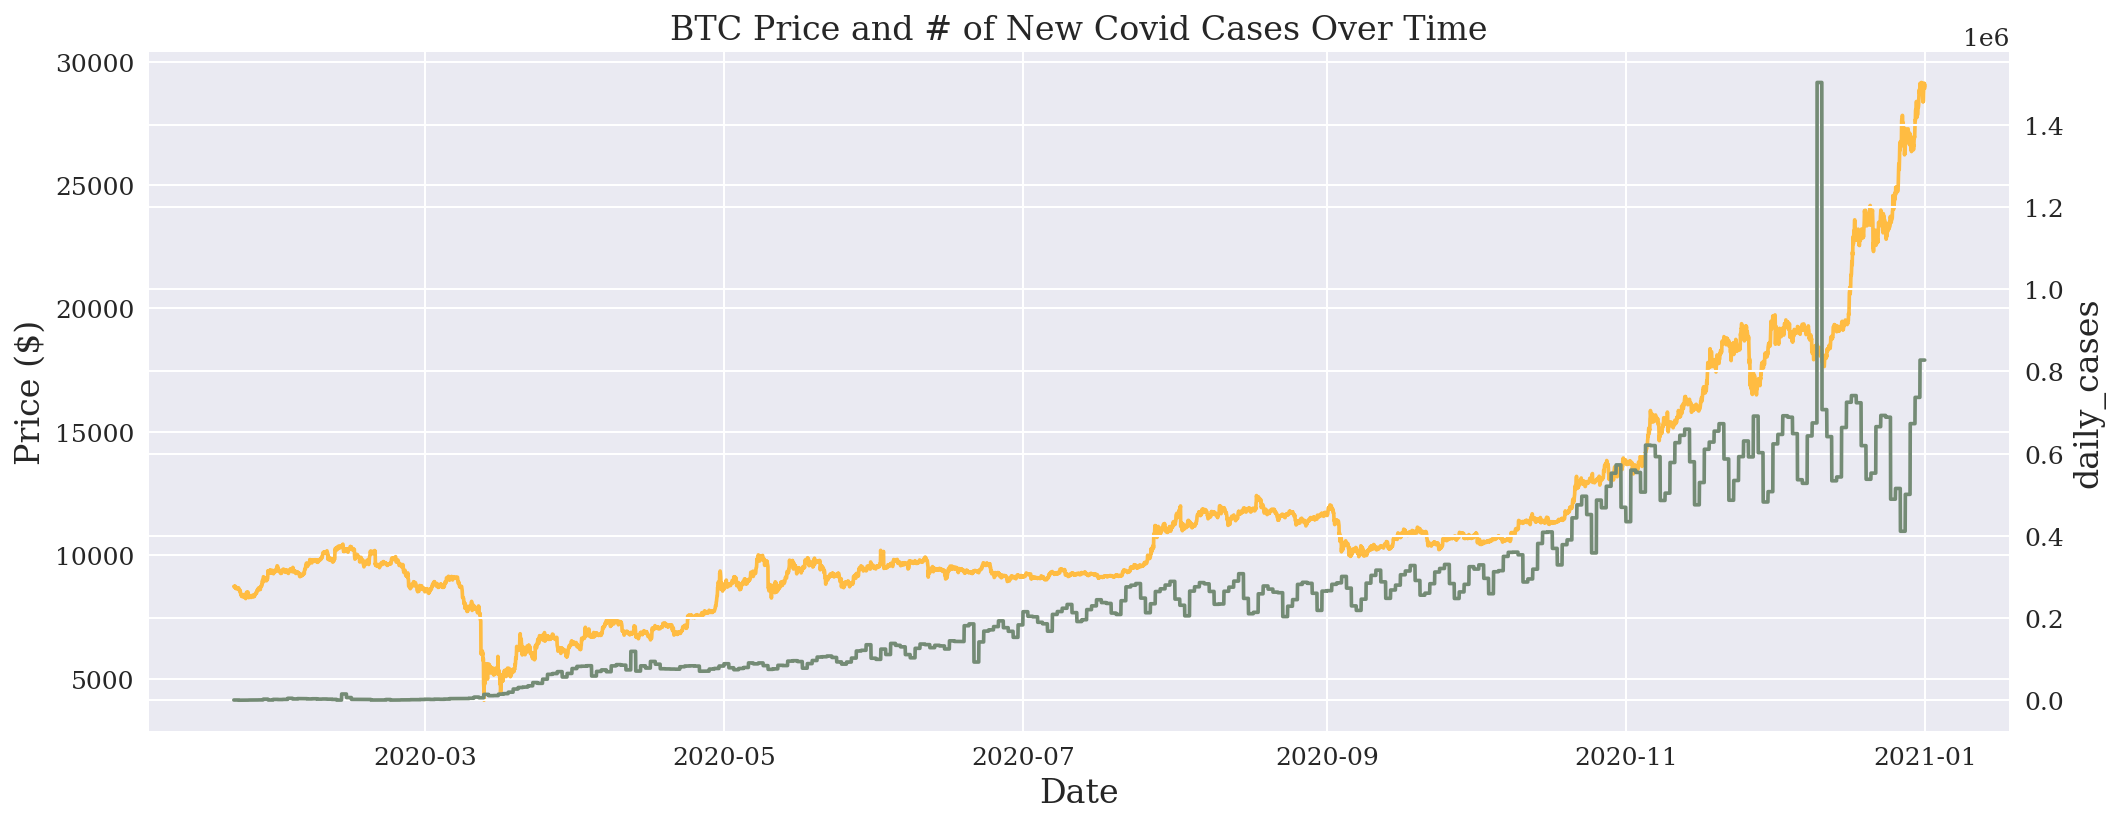

In [43]:
# Price and New Daily Covid cases over time
ax = sns.lineplot(x="time_open", y="price_close", data=merged_df, color='#FFBC42')
ax_sec = ax.twinx()    
ax_sec = sns.lineplot(x="time_open", y="daily_cases", data=merged_df, color='#748B75')

# Set y-axis label
ax.set_ylabel("Price ($)")

# Set x-axis label
ax.set_xlabel("Date")

# Title
ax.set_title("BTC Price and # of New Covid Cases Over Time")

# Show the plot
plt.show()

Again, there seems to be a correlation between the two variables, though not as strong as between the last two variables. I'll conduct a Pearson's correlation test to find the correlation coefficient.

In [44]:
corr, _ = pearsonr(merged_df.price_close, merged_df.daily_cases)
print('Pearsons correlation: %.3f' % corr)

Pearsons correlation: 0.840


As can be seen, there, indeed, is a strong correlation between the new Covid cases and Bitcoin price.

## Write-up

For Module Assignment 3, I have chosen to get the Bitcoin price data for 2020 using the CoinAPI. The dataset contains hourly Bitcoin price data, including open, close, low, and high prices. There is also data on trades count and volume traded. I've chosen 3 questions, that I will try to answer using the data I have. Firstly, I want to assure the time series data of Bitcoin prices is non-stationary, i.e., the means, variances, and covariances change over time. This also means that it is hard to model the data. As many different factors affect Bitcoin price, its market is quite volatile, and there are rapid and significant increases or decreases, I know it should be non-stationary. Secondly, I try to find out if there is a correlation between `volume_traded` or `trades_count` and `price_close` variables. I believe that when the Bitcoin price is high, more trades are done. Nonetheless, I am not really sure about `volume_traded` at high prices. And lastly, I'll try to see if there is a correlation, between Covid cases (both daily new cases and total cumulative cases) and the Bitcoin price (or if there was a correlation in 2020). For the last question, I would need another dataset, which I'll describe in detail as I answer Question 3.

It is important to mention that CoinAPI has both a daily limit and a limit on data received by a request, which makes using it (the free version) a bit inconvenient. Thus, I had to send multiple requests and combine the received data. After gathering and combining the data for the whole interval, I found out some rows were missing. I tried requesting these missing values again, however, it turned out the mistake was probably in the API since the request returned an empty list. Nonetheless, out of 8784 entries (24 hours * 366 days), only 25 were missing, which is roughly 0.3% and is negligible even though the data is time series (there were not many consecutive missing values). After collecting the data, I checked it and made sure the interval is correct, checked the top and bottom, and proceeded to Question 1.

To find out whether the time series is stationary or non-stationary, I conducted a Dickey-Fuller Test, which uses the following null and alternative hypotheses:
- H0: The time series is non-stationary. In other words, it has some time-dependent structure and does not have constant variance over time.
- HA: The time series is stationary.

If the p-value from the test is less than some significance level (I'll take 0.05), then we can reject the null hypothesis and conclude that the time series is stationary. I performed the test using the `adfuller` function from `statsmodels.tsa.stattools` library. The p-value returned was much higher than 0.05, which means we don't have enough evidence to reject the Null hypothesis, so we accept it, meaning the time series is non-stationary. This lines up with my assumption.

Next, I've tried to see if any of `volume_traded` or `trades_count` is correlated with `price_close`. I've tested that using the Pearson correlation test, the `pearsonr` function from the `scipy.stats` library. However, firstly, I calculated the correlation between `volume_traded` and `trades_count`. These two variables are strongly positively correlated (ρ = .832), meaning that the larger the volume traded is, the more trades have been taken place, which is logical. Next, I calculated the Pearson test between the remaining two pairs. It turned out that while the there is some positive correlation between `volume_traded` and `price_close` (ρ = .443), there is no correlation between `trades_count` and `price_close` (ρ = .019). This means that the higher the Bitcoin price is, the more is the volume traded, however, it does not mean that more trades have occurred.

For the last question, I got another dataset from John Hopkins University's Covid tracking website (via GitHub). The dataset contains cumulative daily cases for different countries and regions from January 22, 2020, up till now. However, I only need the total number of cases per day, and only the data for 2020, so I created a smaller dataframe with only the combined Covid cases per day. Then I added another column, that had the daily new cases. I plotted both the Bitcoin price and the daily cumulative Covid cases on the same chart but with different scales. It could be seen visually on the chart that the two variables are positively correlated. I did a Pearson correlation test and found out that there is, indeed, a strong positive correlation between them (ρ = .924). I did the same with Bitcoin price and daily new Covid cases, and again found out that the two are positively correlated (ρ = .840). However, correlation does not mean causation.

All in all, I found that the Bitcoin price time series is non-stationary, that `volume_traded` is positively correlated with `trades_count` and `price_close`, and that the number of Covid cases (both new and cumulative) and the Bitcoin price are correlated. Again, the analysis was done on the 2020 Bitcoin price data taken from Binance. Also, there might have been a bunch of other factors that affected the Bitcoin price.

## Q0: Difference Between Consecutive Weeks

How can I find an answer to this question? Can I use t-tests ona time series (values are dependent)?

First, I'll divide the data into weeks. To do that, I create a new column in the dataframe, called `week`.

In [45]:
# Add new column by binning
df['week'] = pd.cut(df.time_open.dt.dayofyear, bins=range(0, 373, 7), labels=range(1, 54))

In [46]:
# Check how many entries every week has
df.week.value_counts().sort_index()

1     168
2     168
3     168
4     168
5     168
6     167
7     168
8     163
9     168
10    167
11    168
12    168
13    168
14    168
15    168
16    168
17    166
18    168
19    168
20    161
21    168
22    168
23    168
24    168
25    168
26    165
27    168
28    168
29    168
30    168
31    168
32    168
33    168
34    168
35    168
36    168
37    168
38    168
39    168
40    168
41    168
42    168
43    168
44    168
45    168
46    168
47    168
48    167
49    168
50    168
51    164
52    167
53     48
Name: week, dtype: int64

I will now plot a bar graph, to see the mean price for each week.

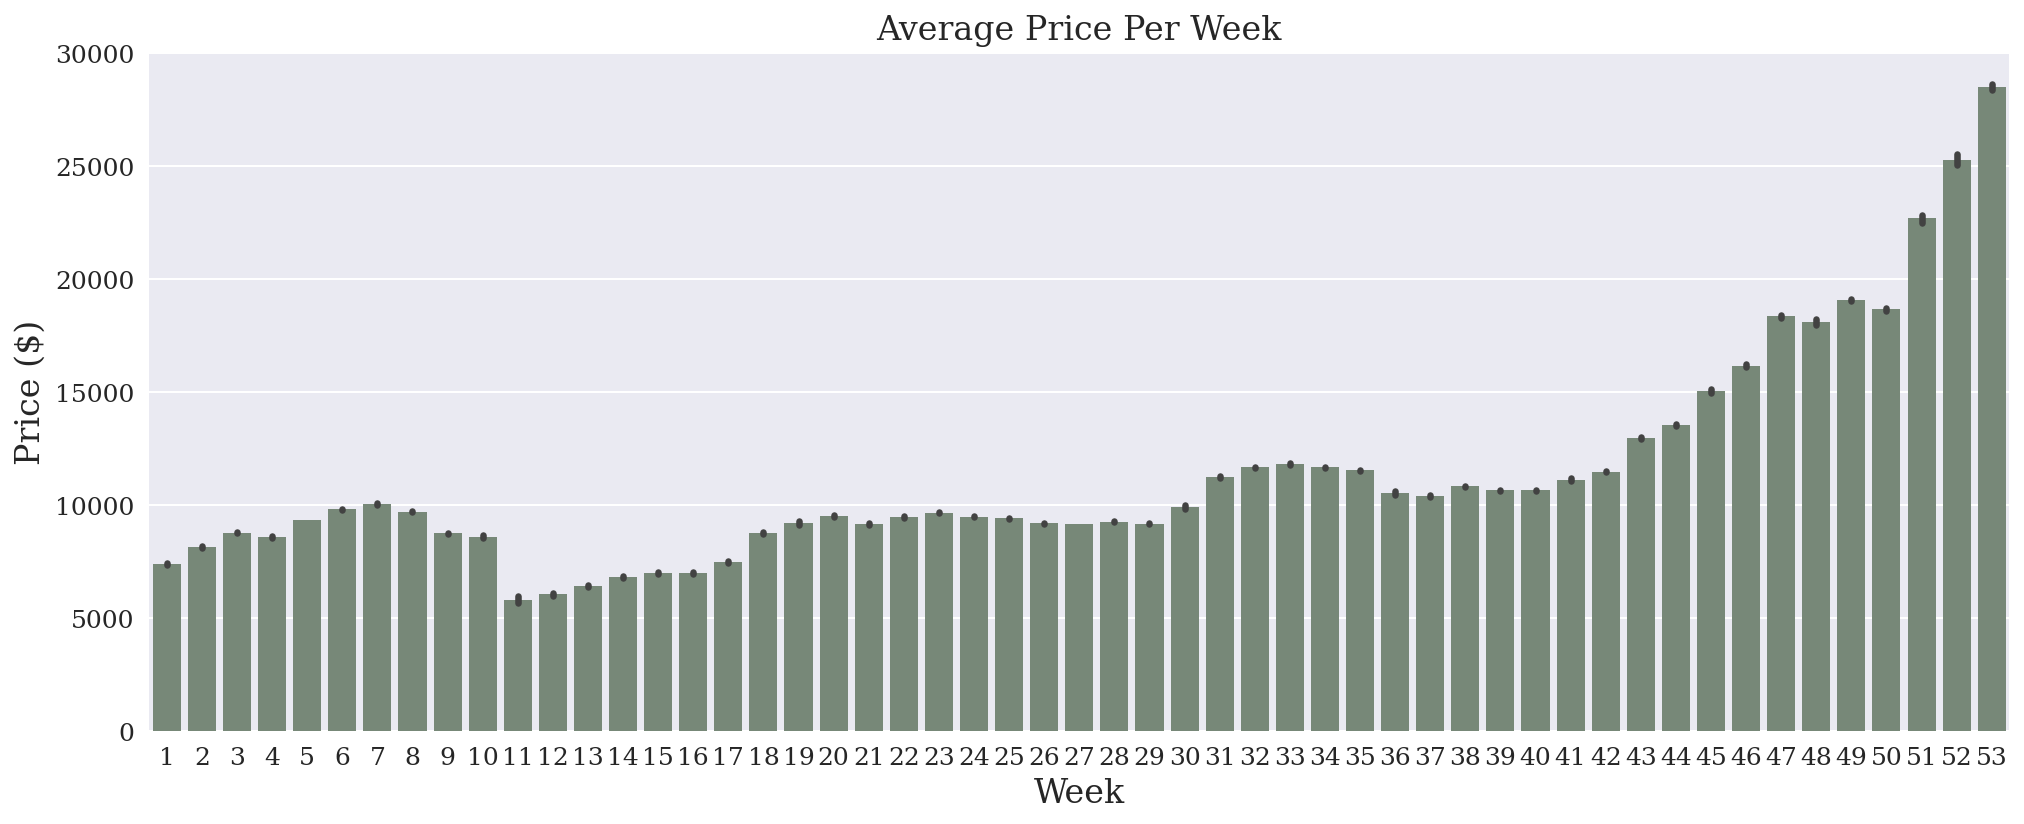

In [47]:
# Barplot for average close price per week
ax = sns.barplot(x="week", y="price_close", data=df, palette = ['#748B75'])

# Some x tick labels are too long, so, I need to wrap the title
# Get the x tick labels
ax.get_xticklabels()

# Get the text out
texts = [t.get_text()  for t in ax.get_xticklabels()]

# Wrap the text
texts = [textwrap.fill(t.get_text(), 12)  for t in ax.get_xticklabels()]

# Set the new wrapped titles
ax.set_xticklabels([textwrap.fill(t.get_text(), 12)  for t in ax.get_xticklabels()])


# Set y-axis label
ax.set_ylabel("Price ($)")

# Set x-axis label
ax.set_xlabel("Week")

# Title
ax.set_title("Average Price Per Week")

# Show the plot
plt.show()

I will save the dataframe, so that I don't have to get it using the API again.

In [48]:
# Save the dataframe to a csv file
df.to_csv("BTCUSDT_2020.csv")

Now, I will conduct t-tests for the price data for each two consecutive weeks. I will also plot the pricelines. First, I define a plotting function.

In [49]:
def plot_priceline(start_week, end_week, pvalue):
    """
    Plots the priceline for the given interval (in weeks).
    
    Keyword parameters:
        start_week - the start of the interval.
        
        end_week   - the end of the interval.
        
        pvalue     - the pvalue of the t-test for the given two weeks.    
    """
    # Priceline
    ax = sns.lineplot(x="time_open", y="price_close", data=df, color='#748B75' if pvalue < 0.05 else '#EE2E31')
    # Set y-axis label
    ax.set_ylabel("Price ($)")

    # Set x-axis label
    ax.set_xlabel("Date")

    df_weeks = df[(week <= df.week) & (df.week <= week+1)]
    
    # Set x limits
    limits = list(df_weeks.time_open)
    ax.set_xlim(limits[0], limits[-1])
    
    # Set y limits
    ax.set_ylim(df_weeks.price_close.min()*.95, df_weeks.price_close.max()*1.05)

    # Title
    ax.set_title(f"BTC Price Over Time | Weeks {week}-{week+1} | p-value: {pvalue:.5f}")

    # Show the plot
    plt.show()

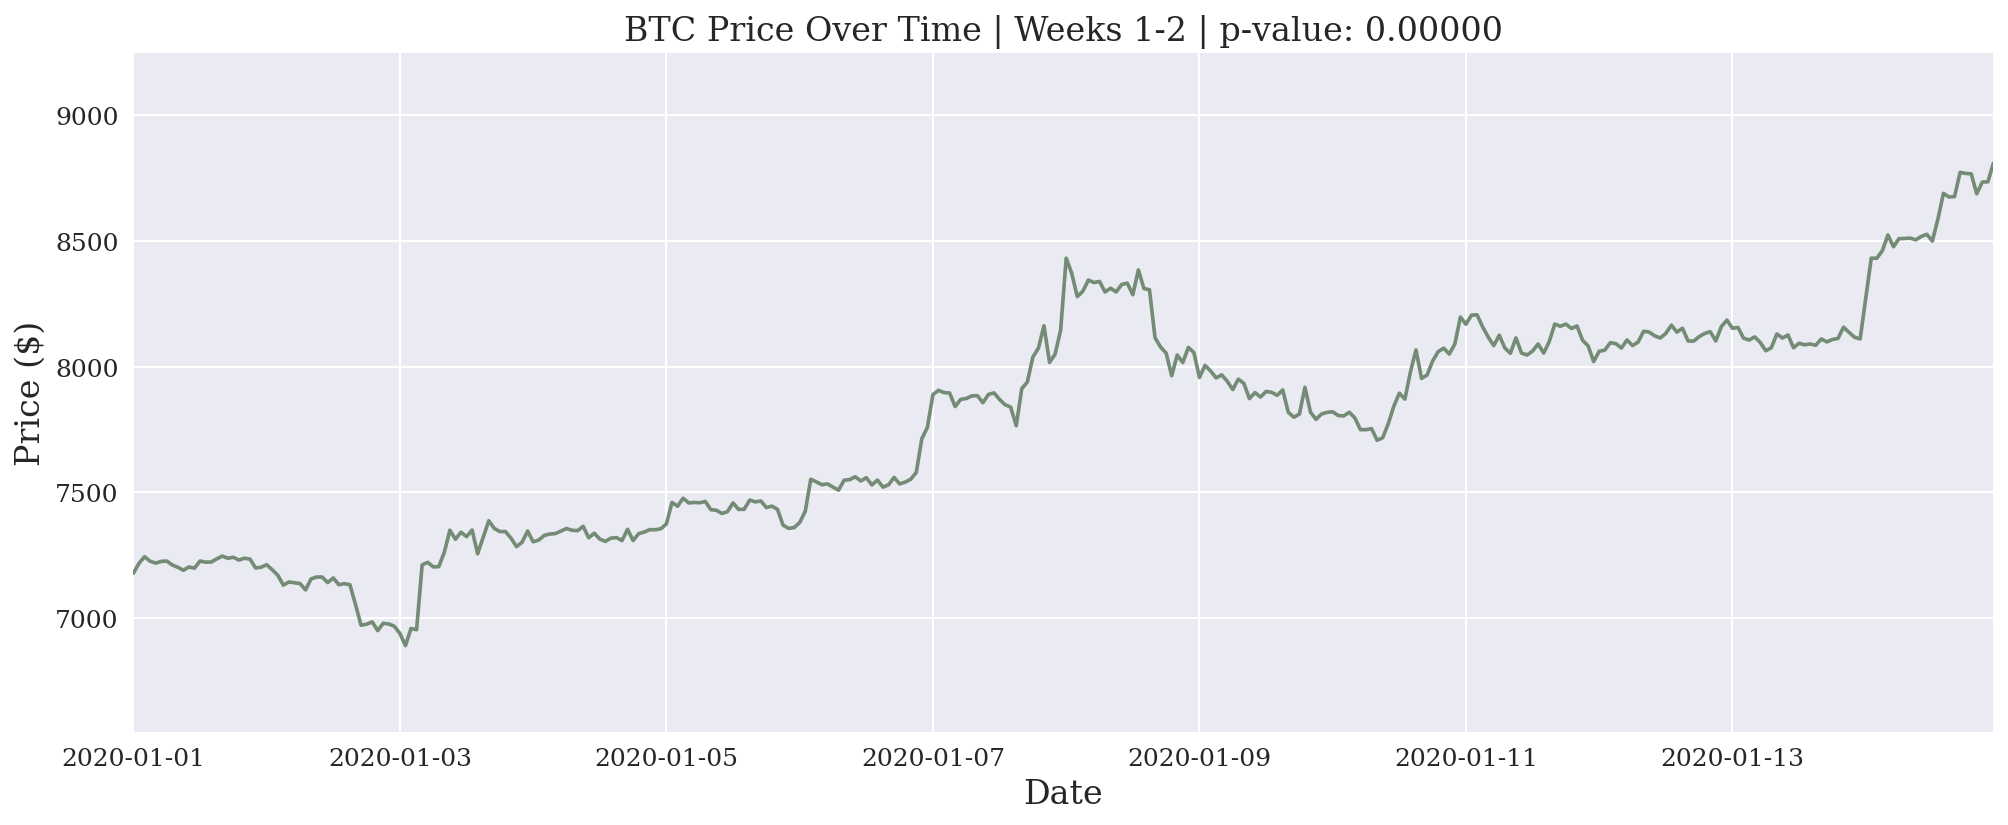

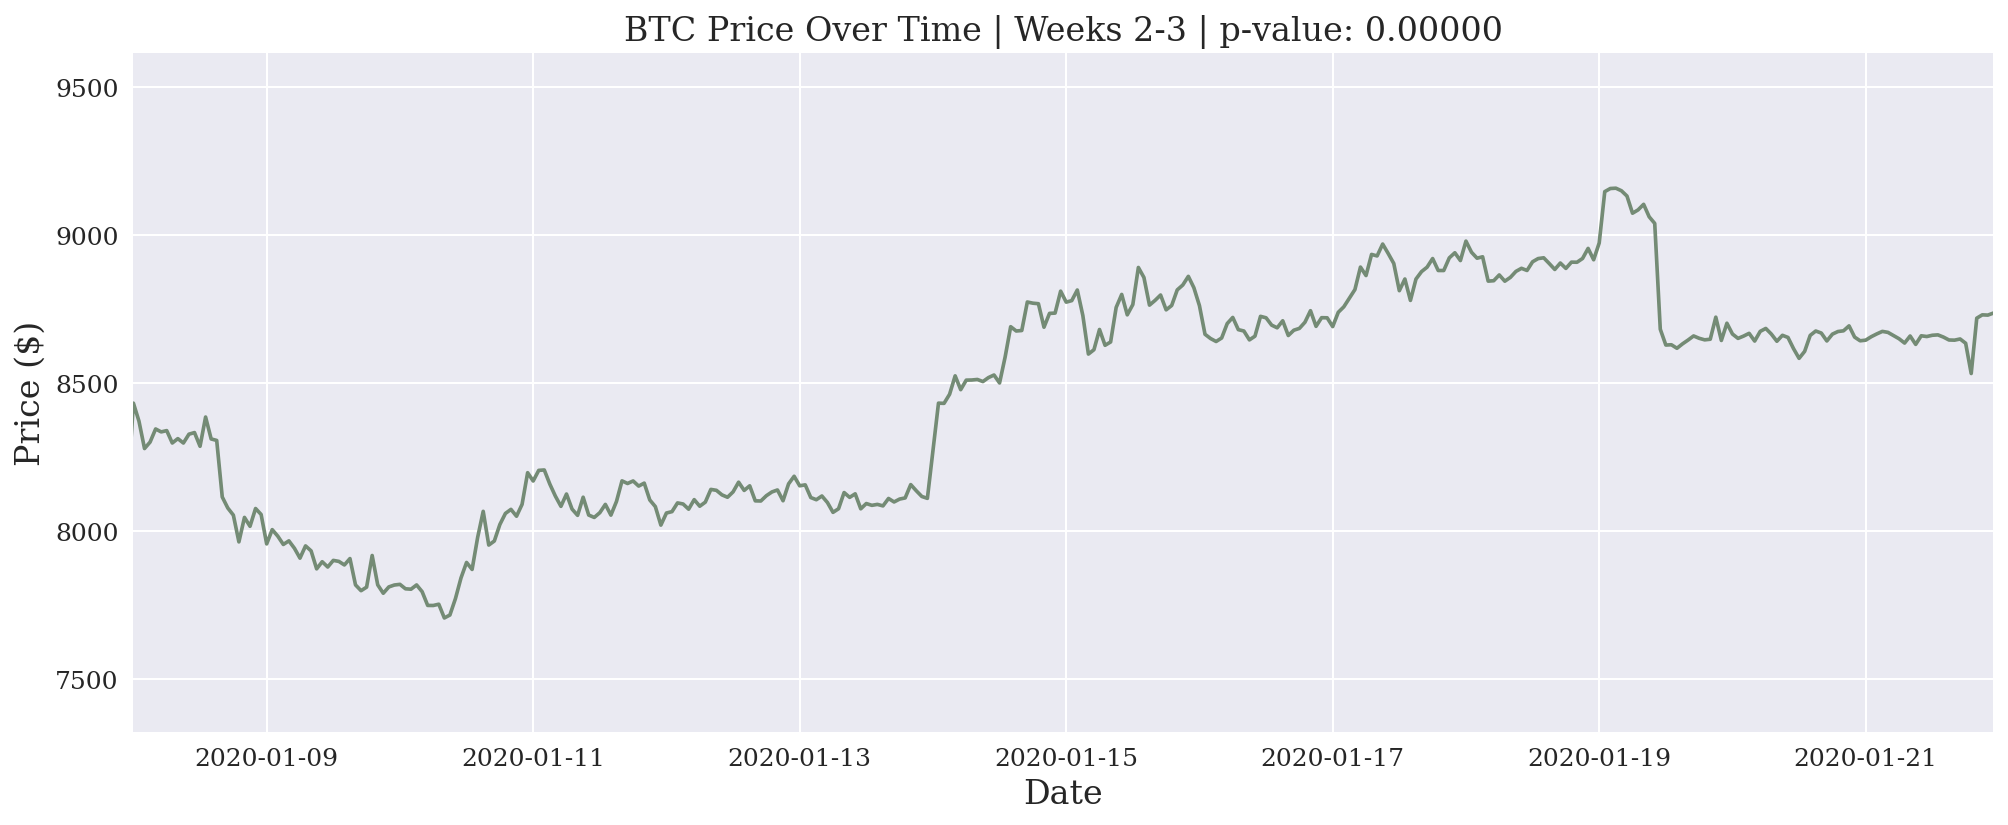

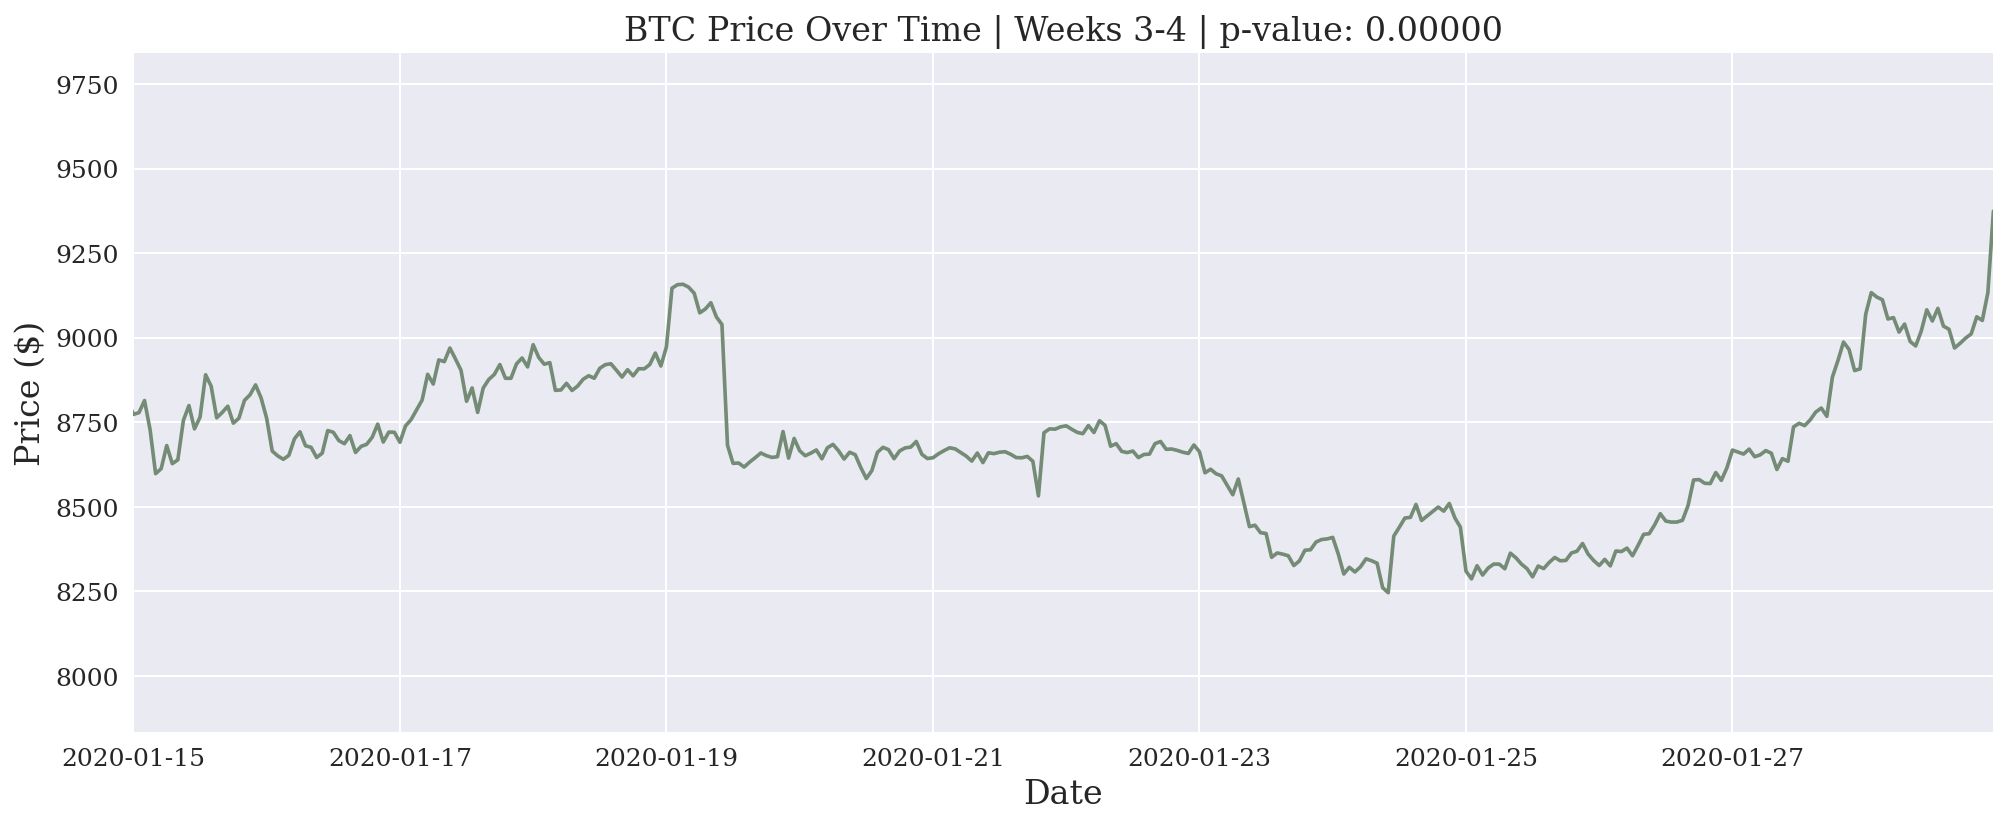

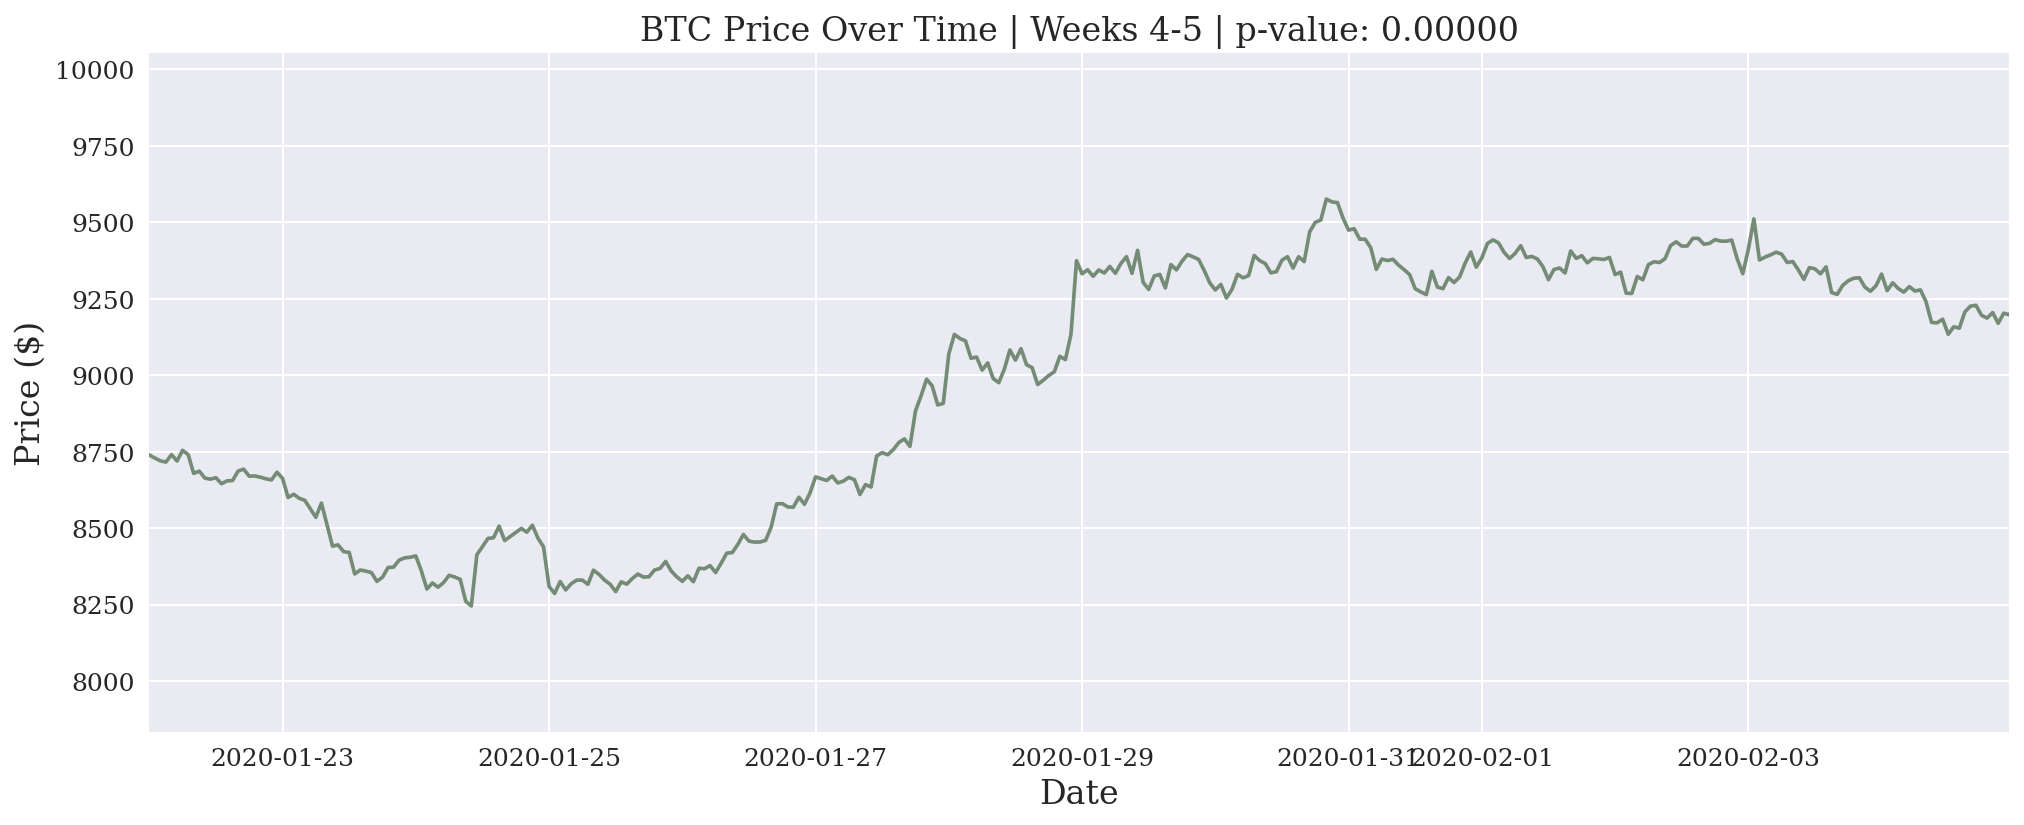

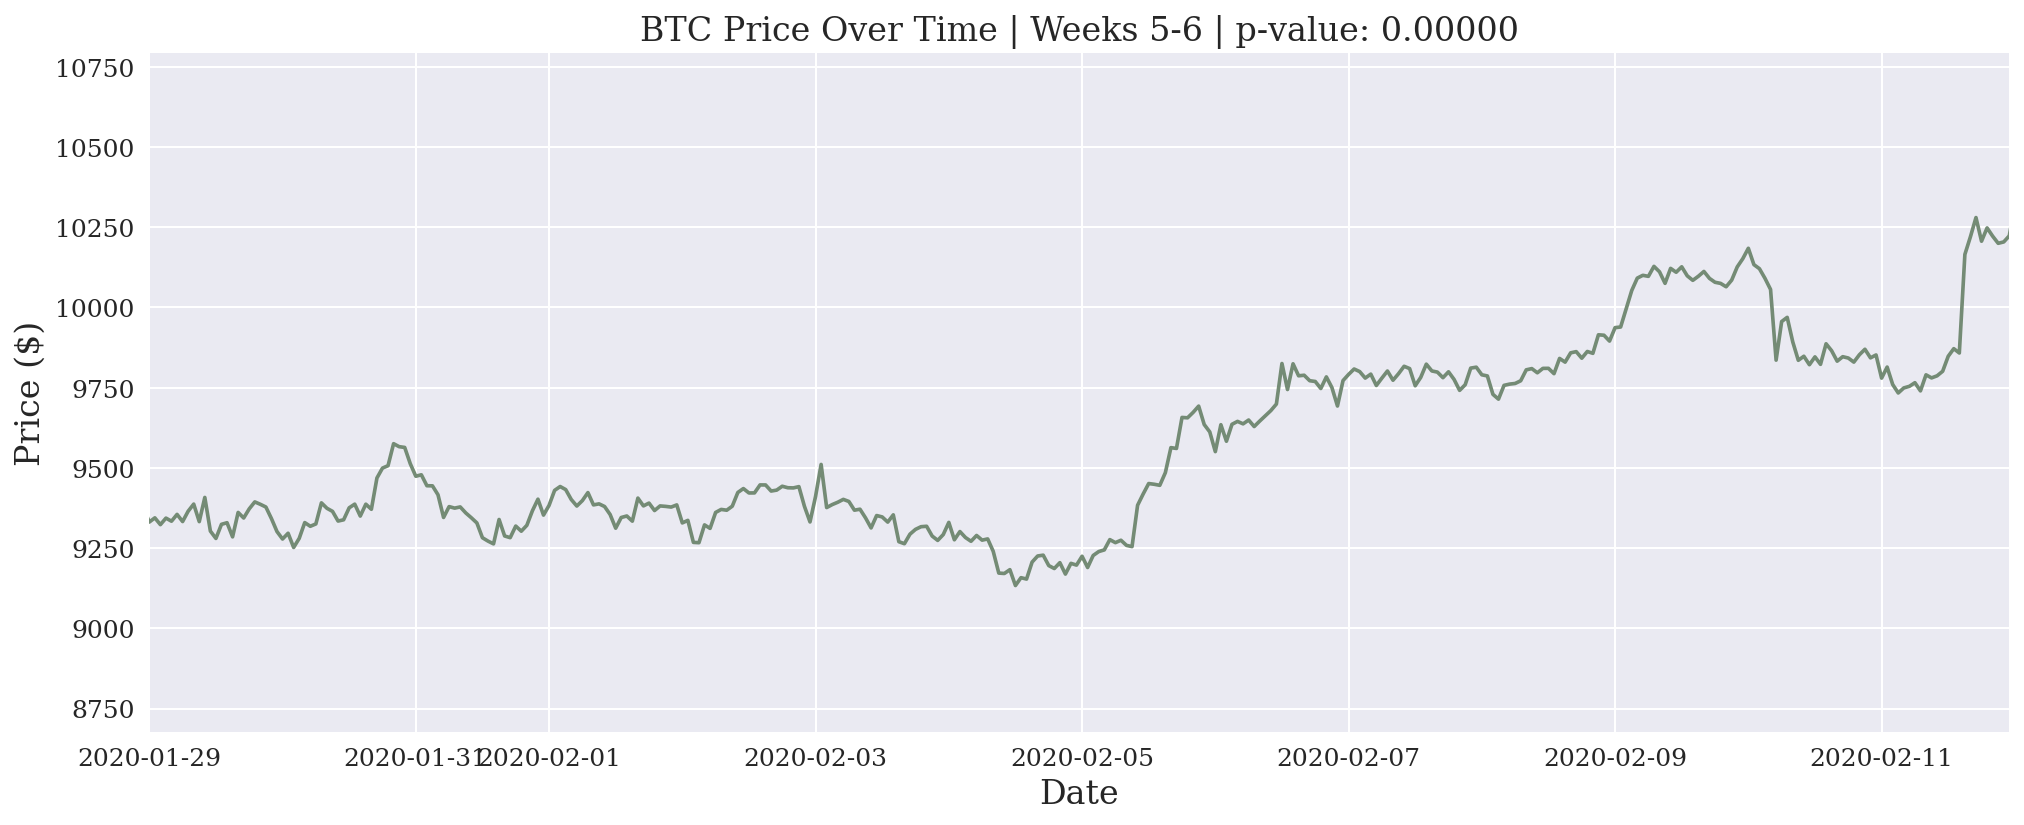

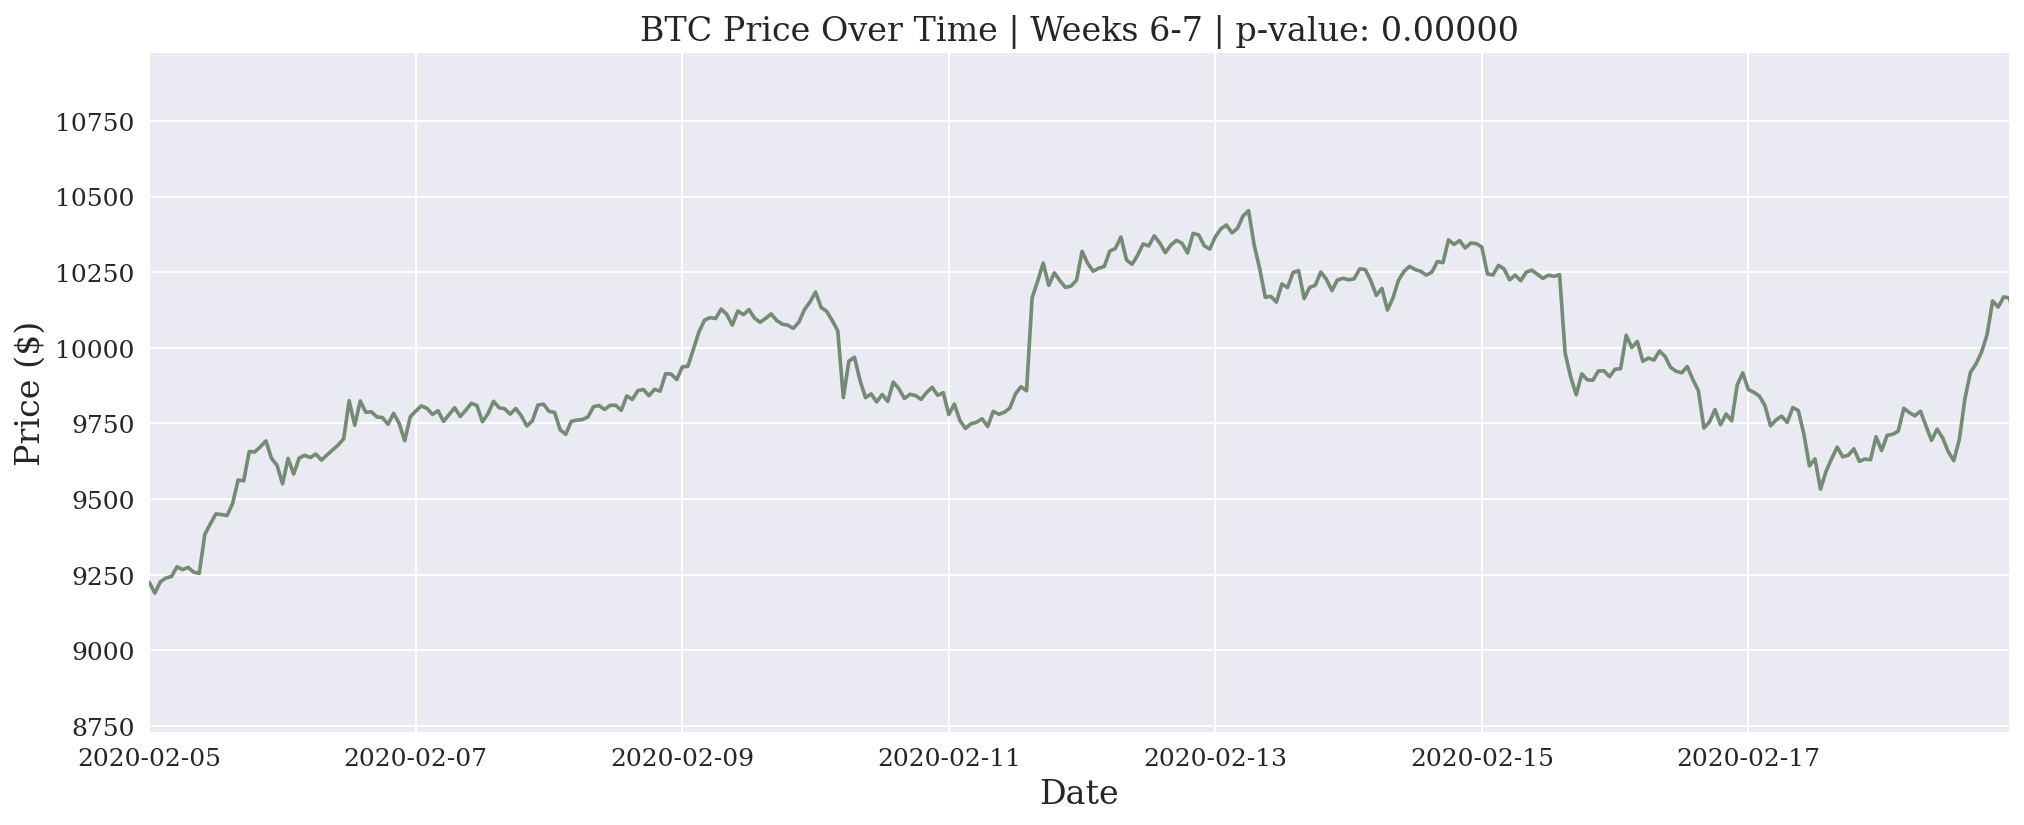

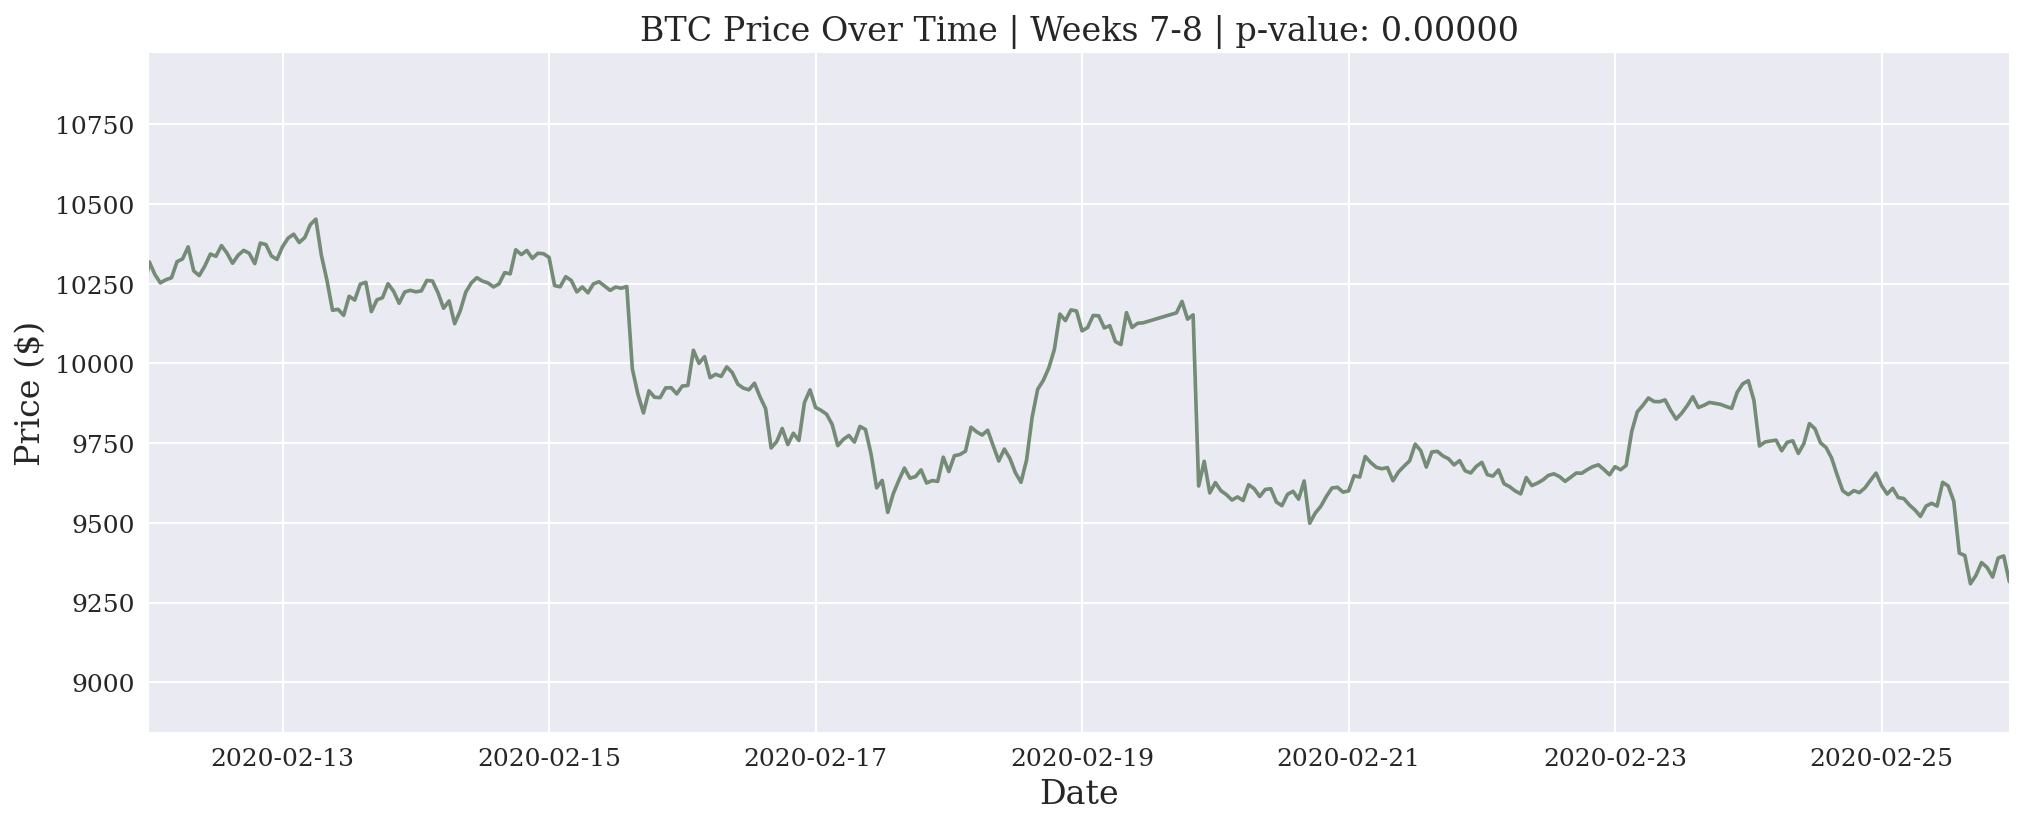

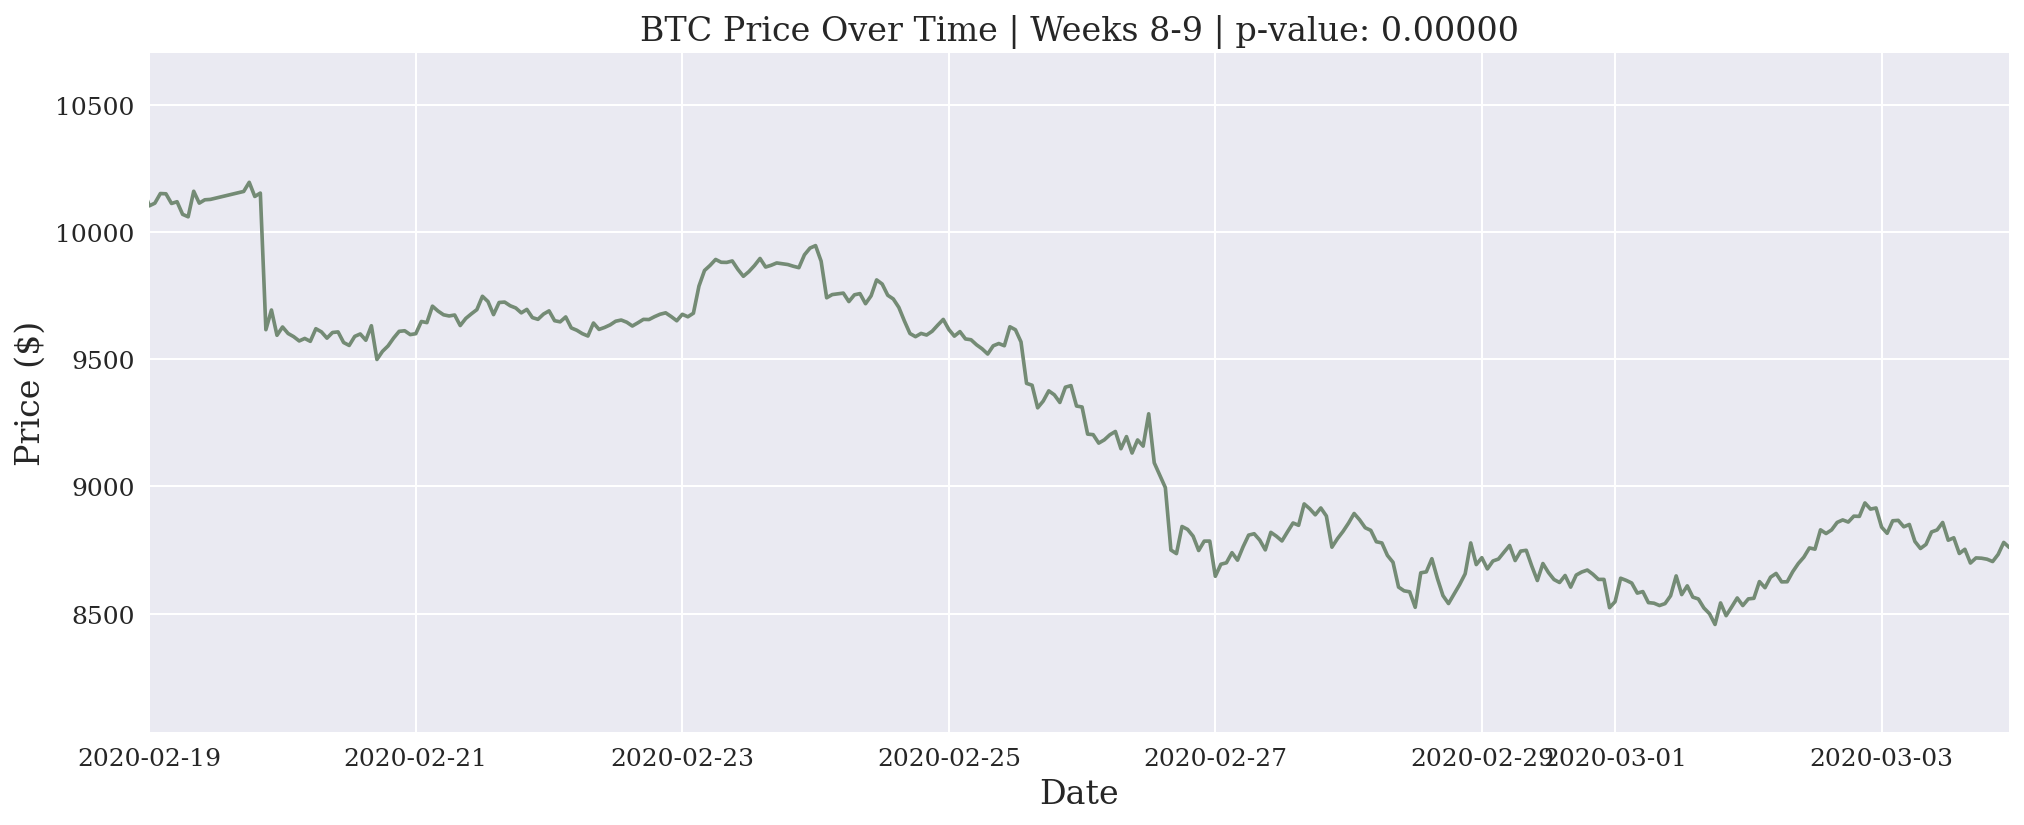

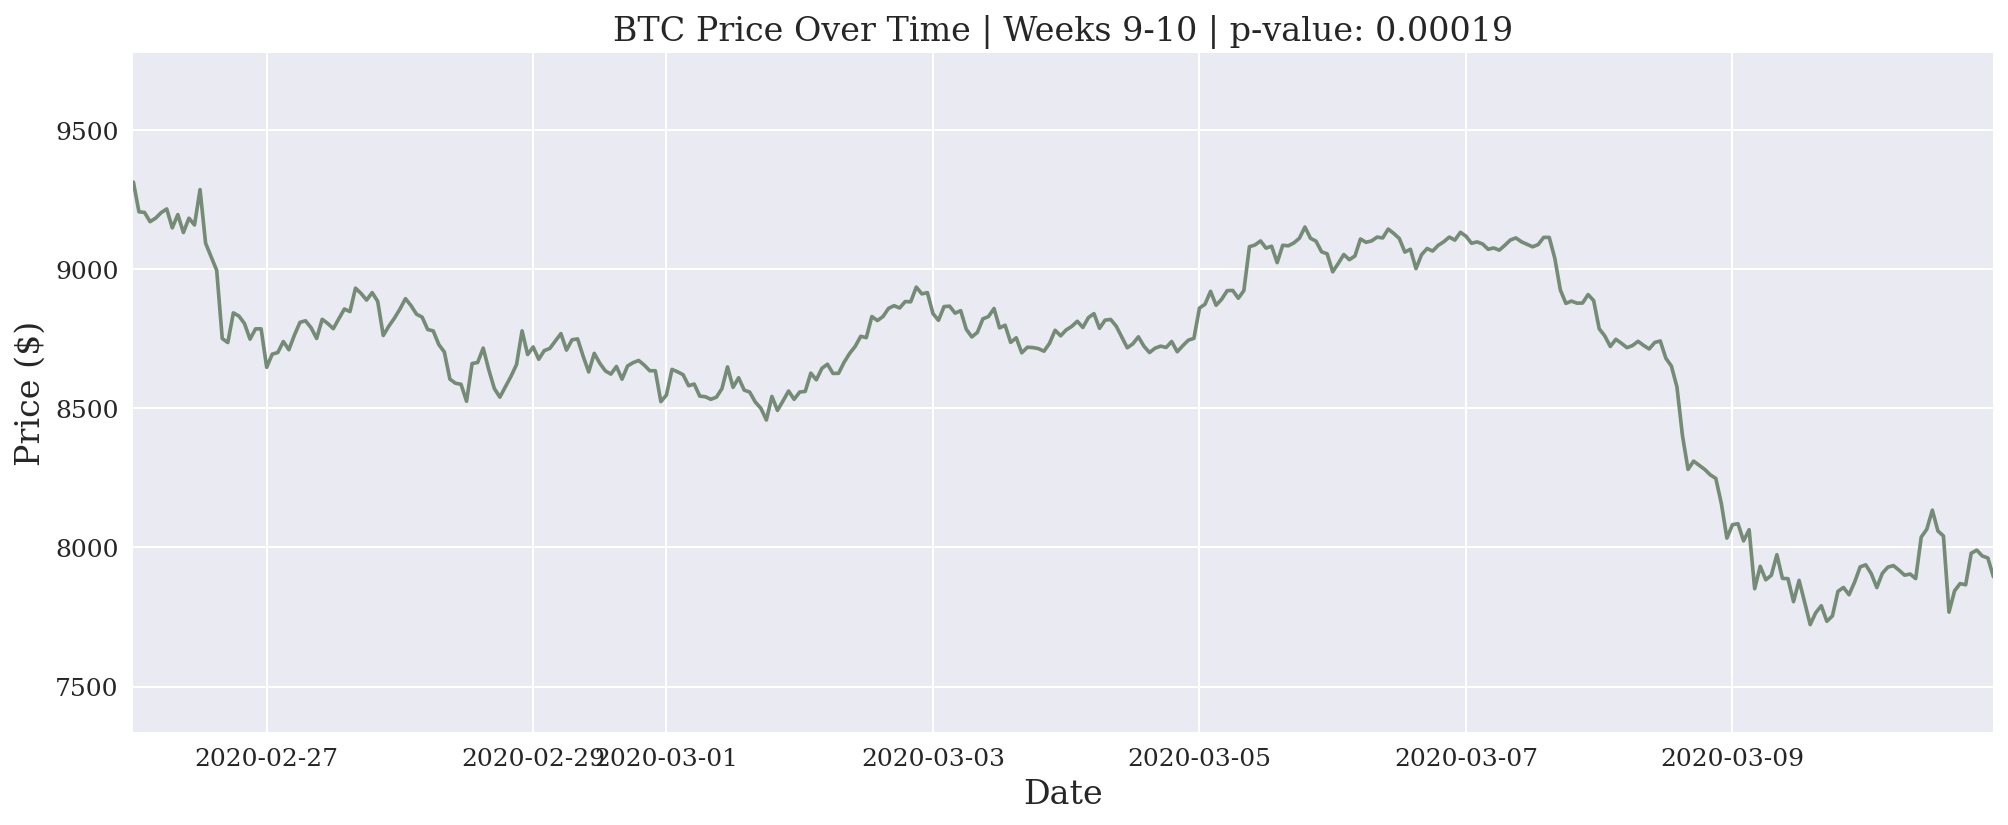

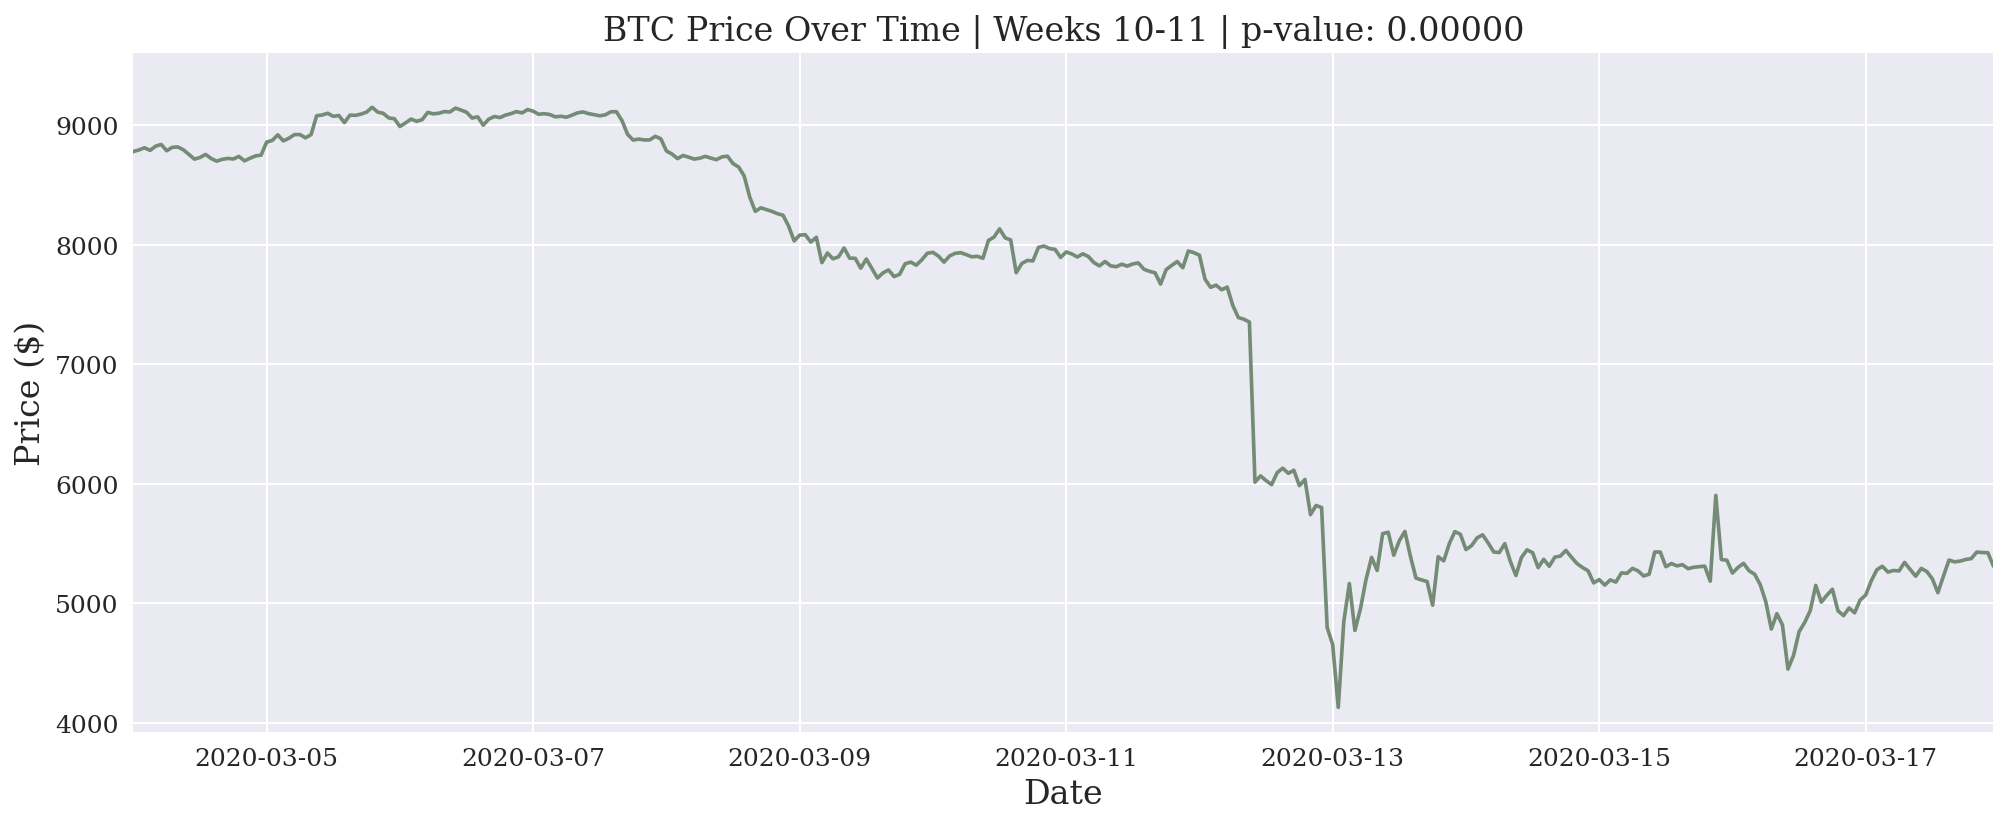

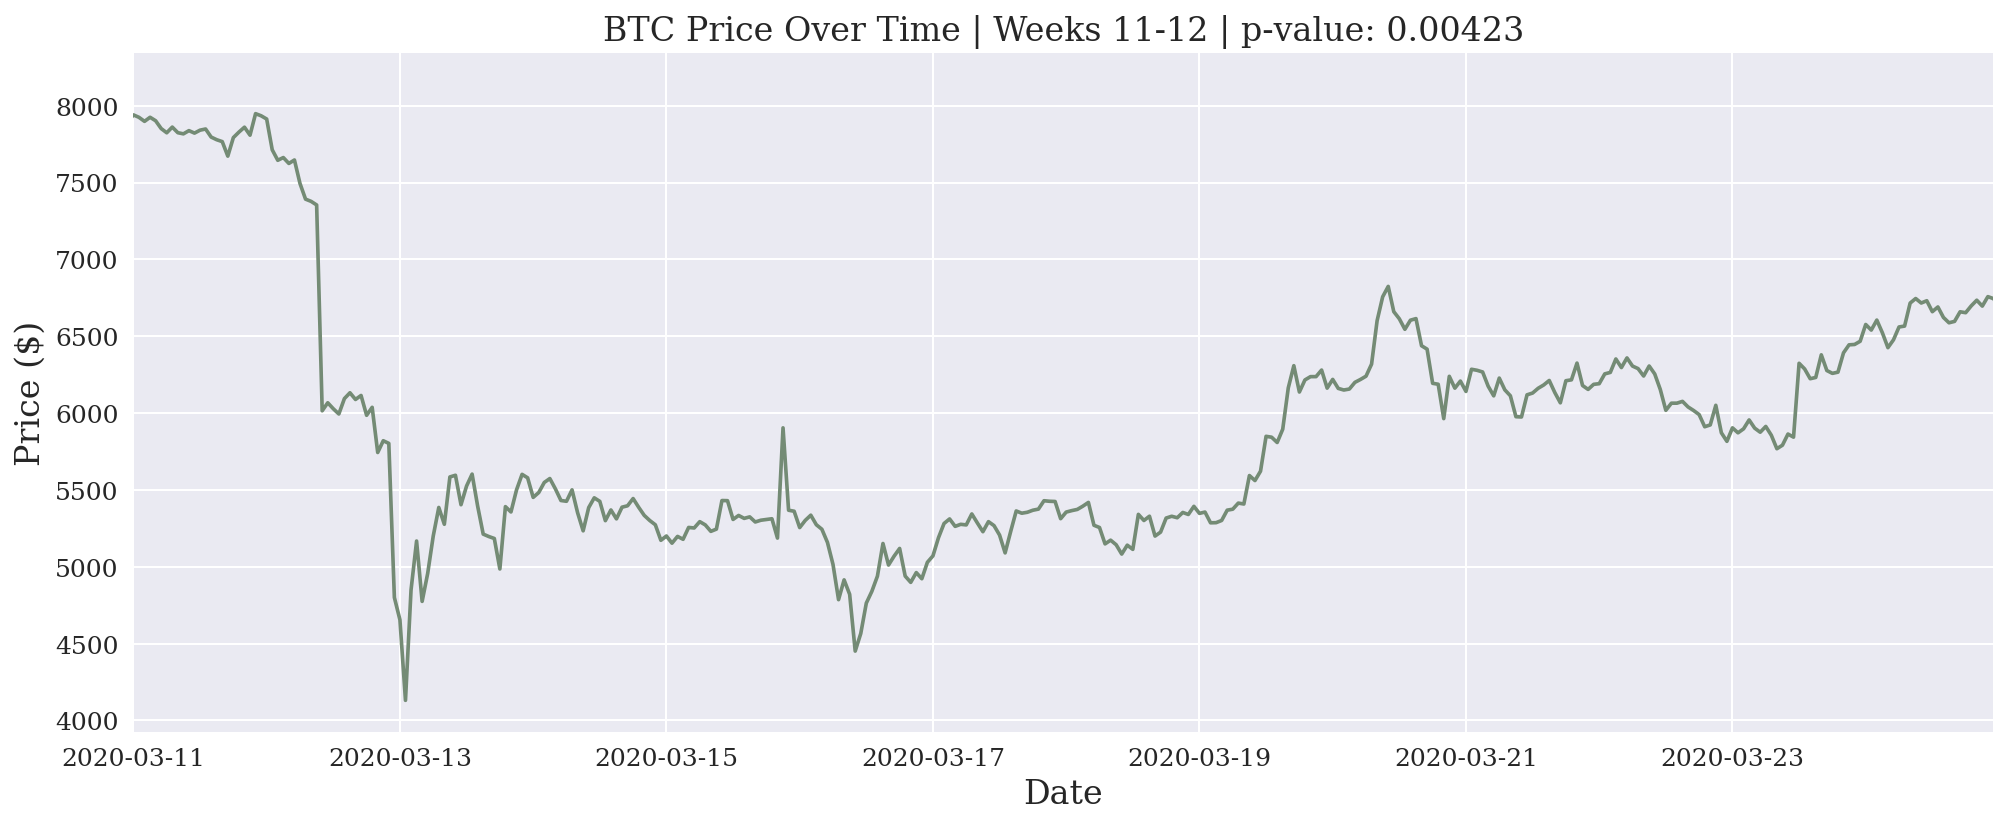

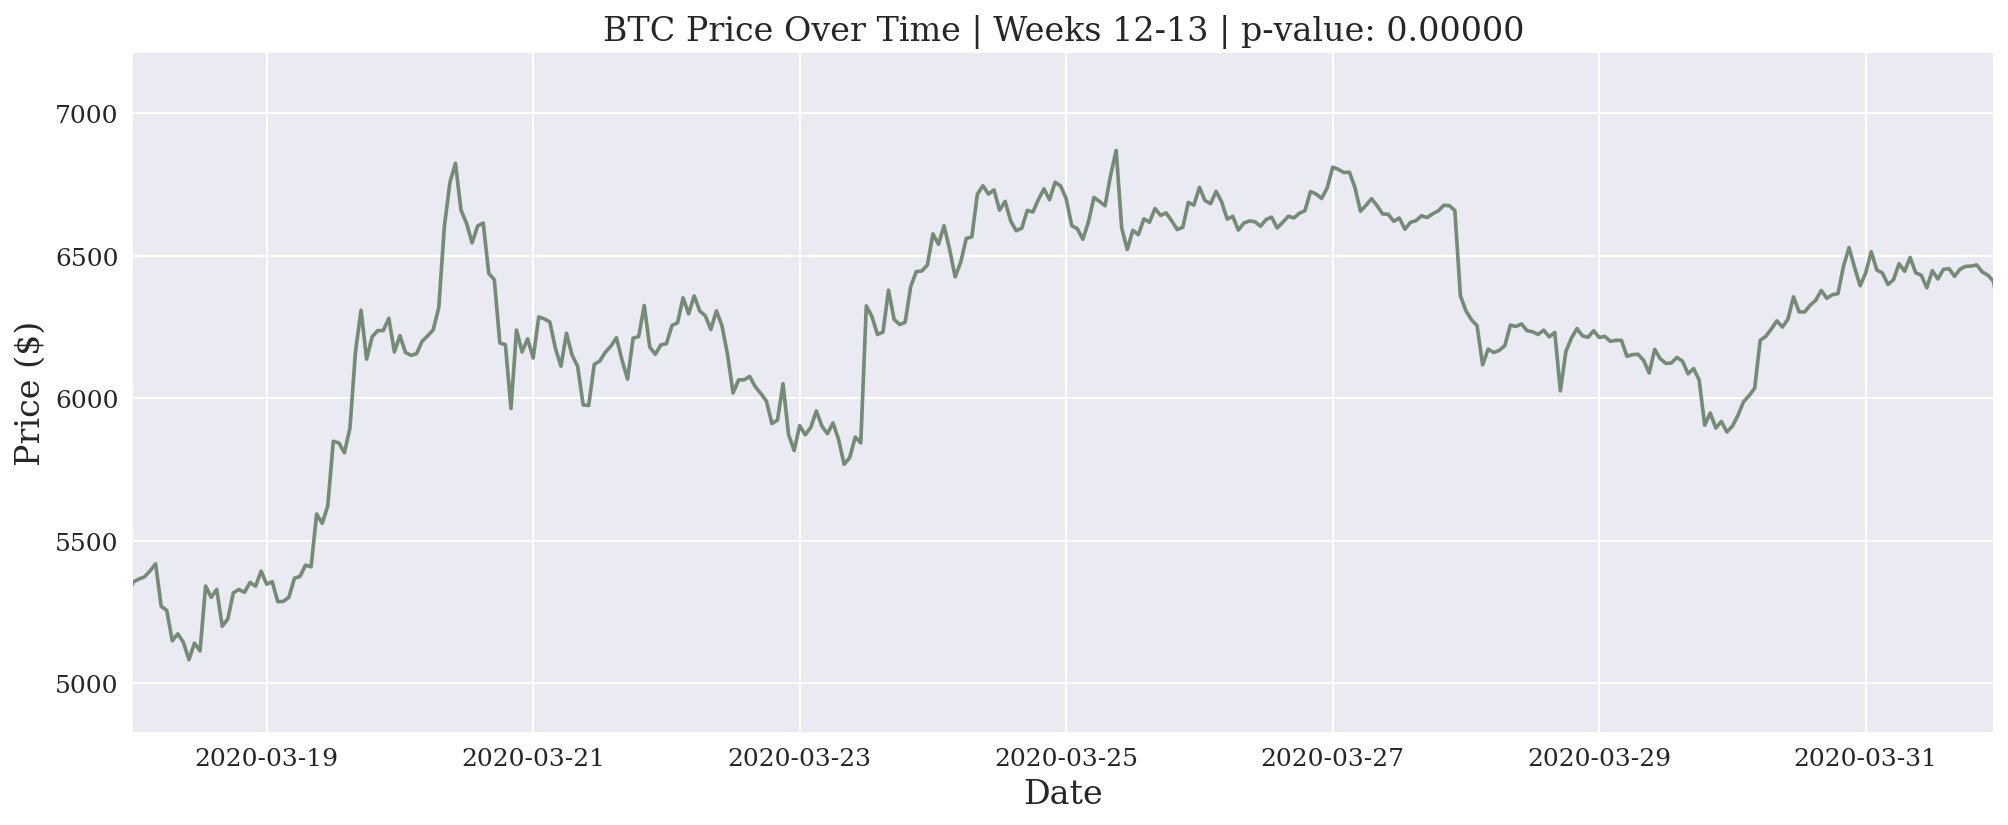

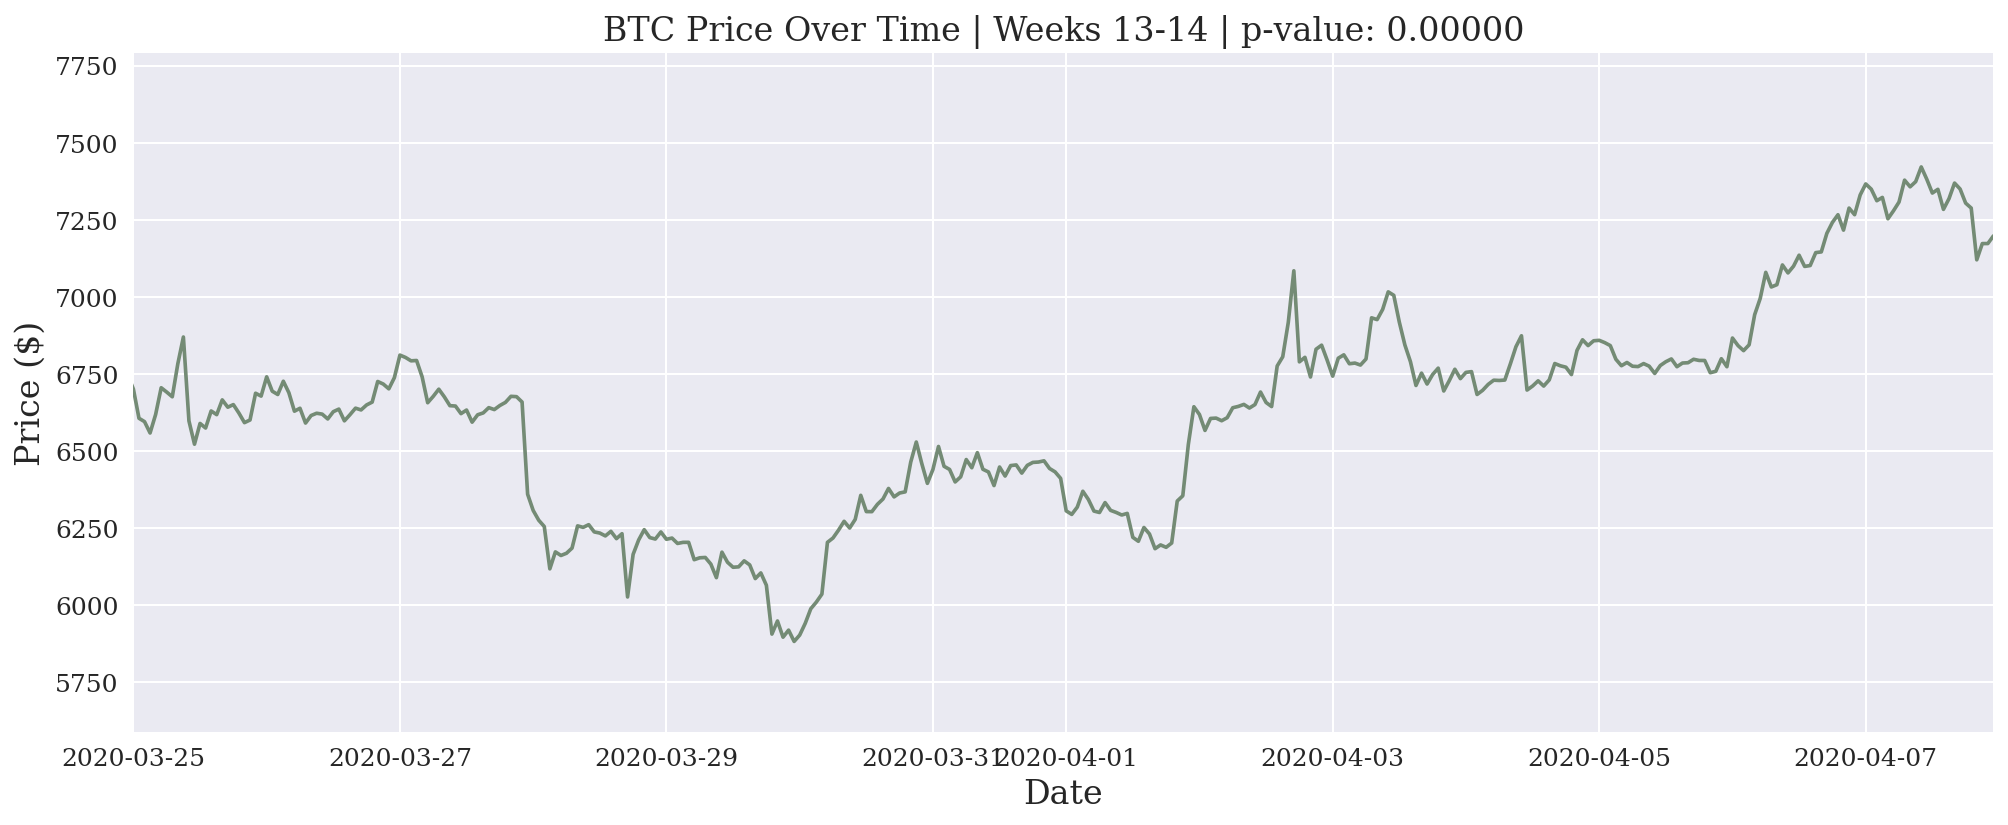

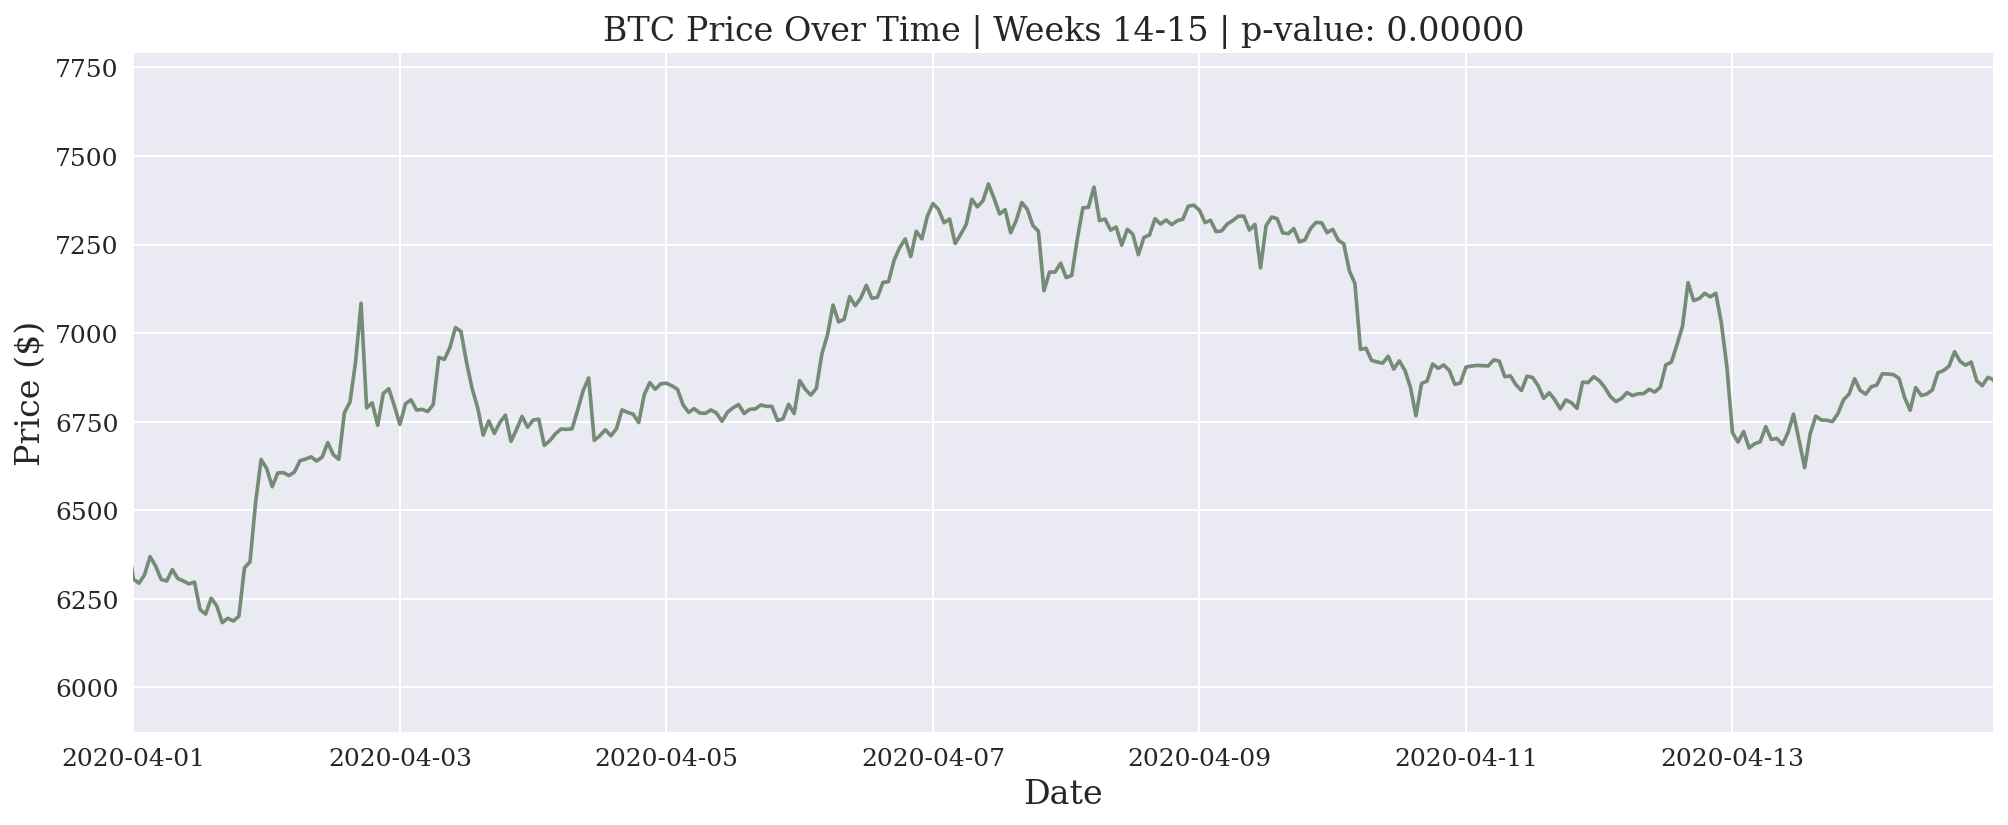

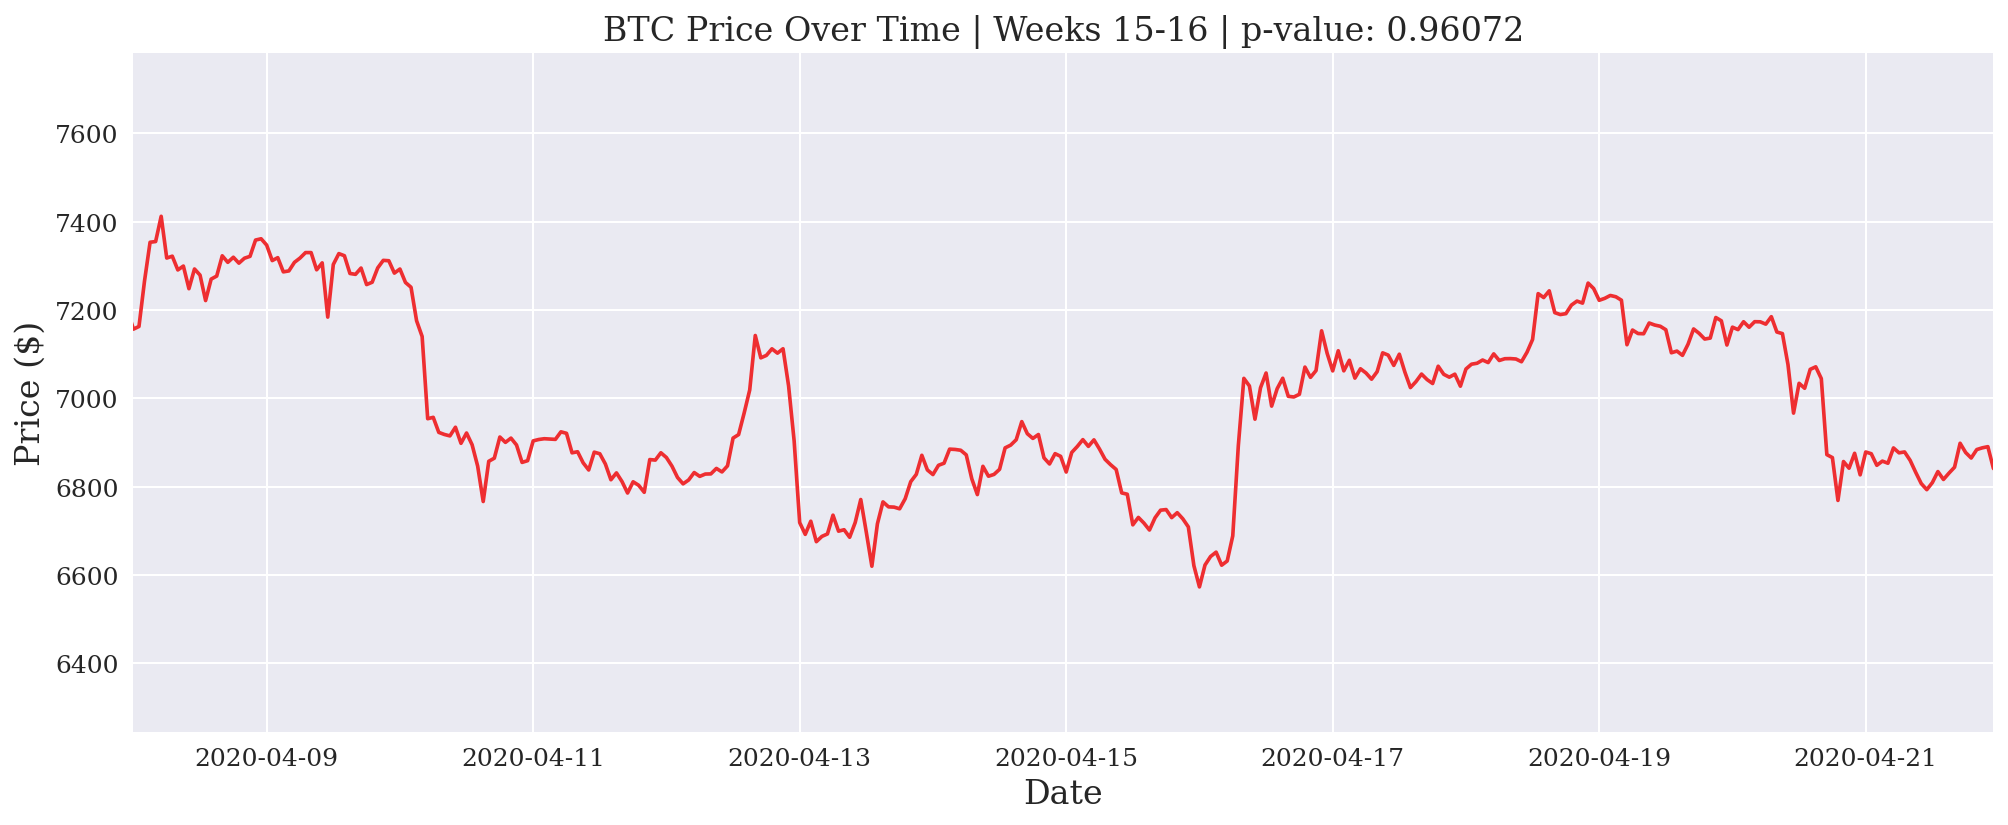

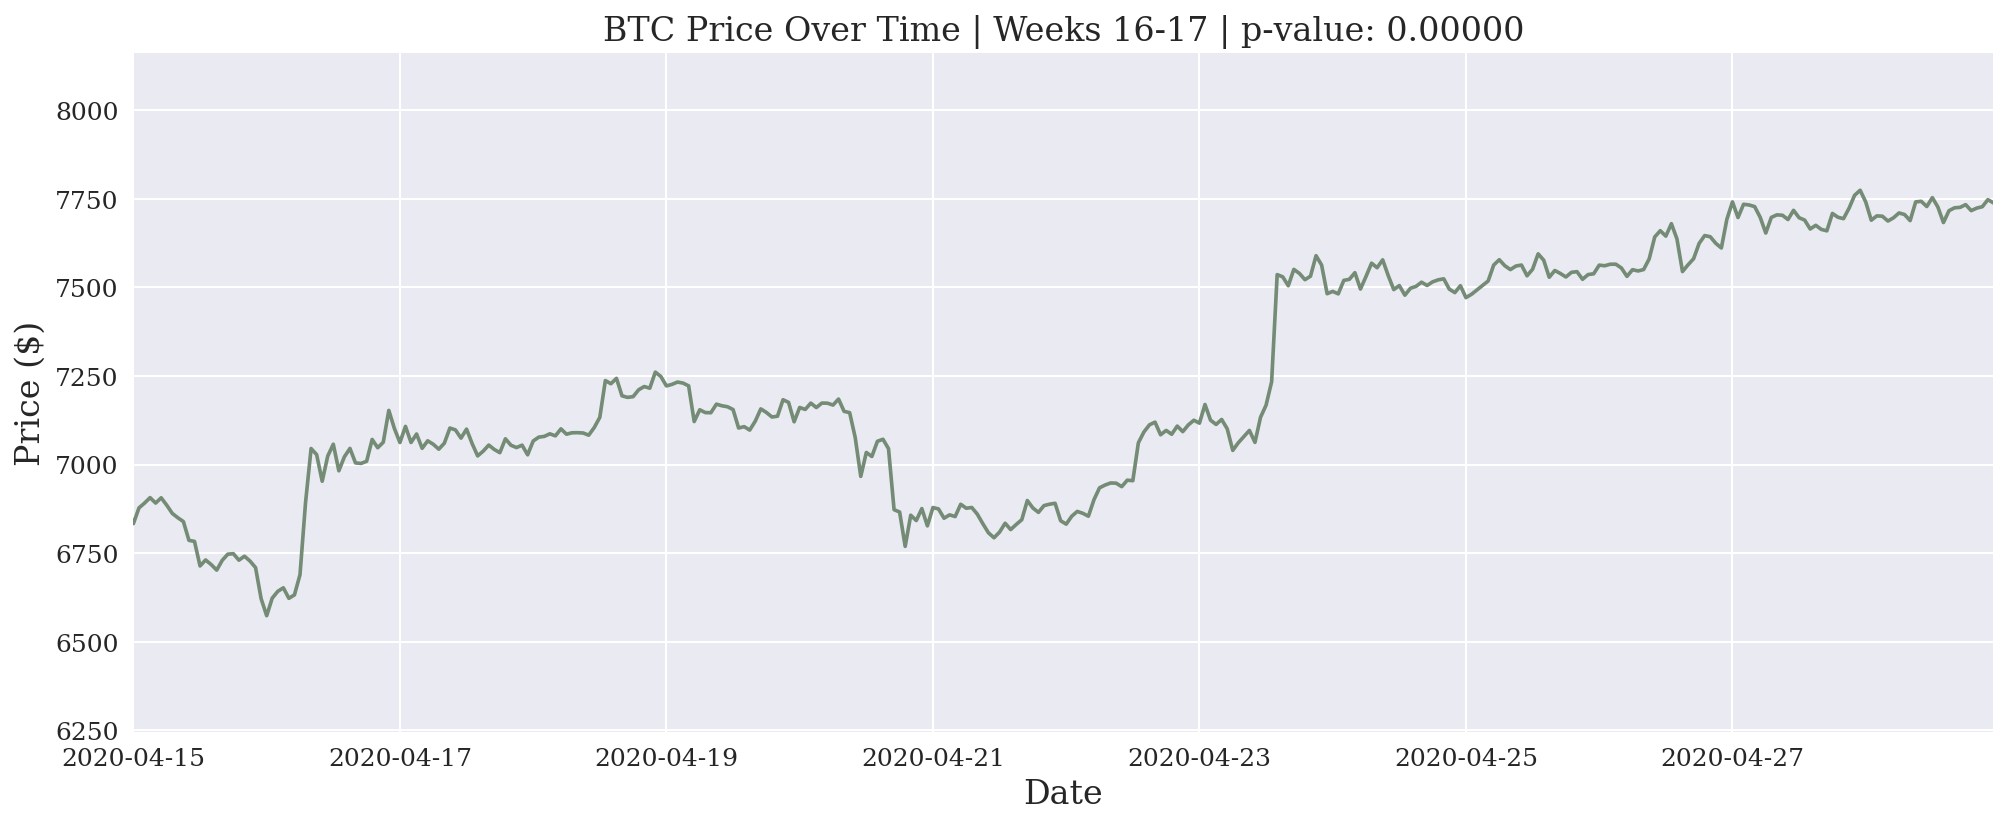

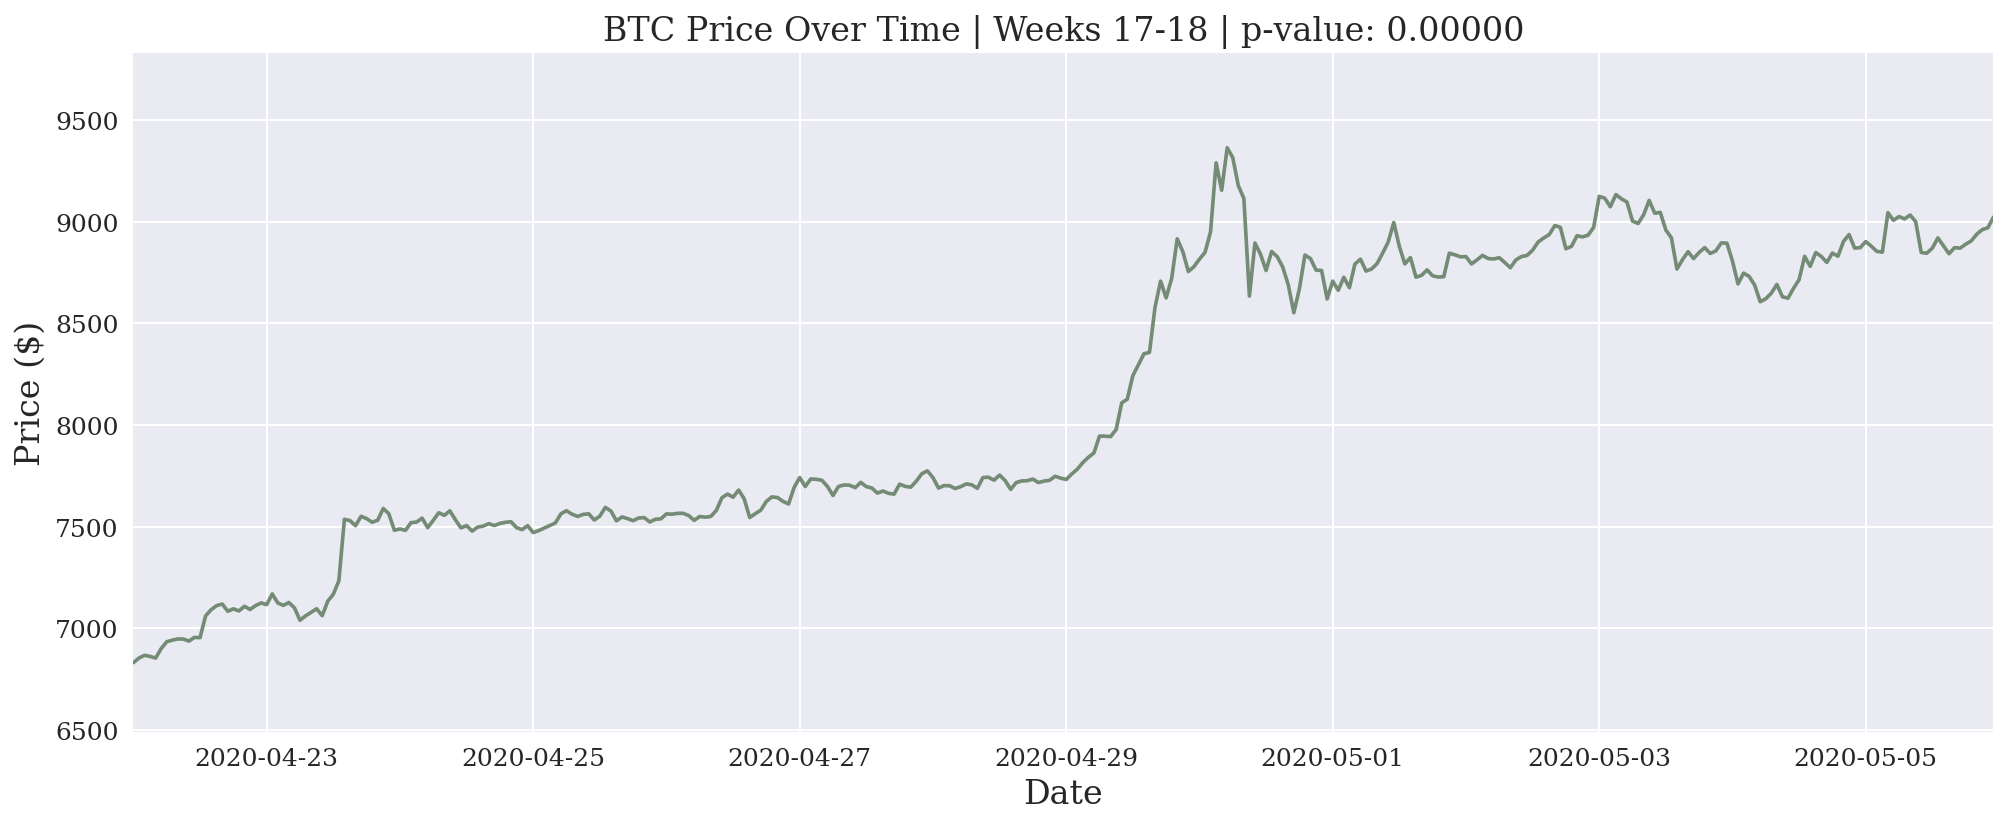

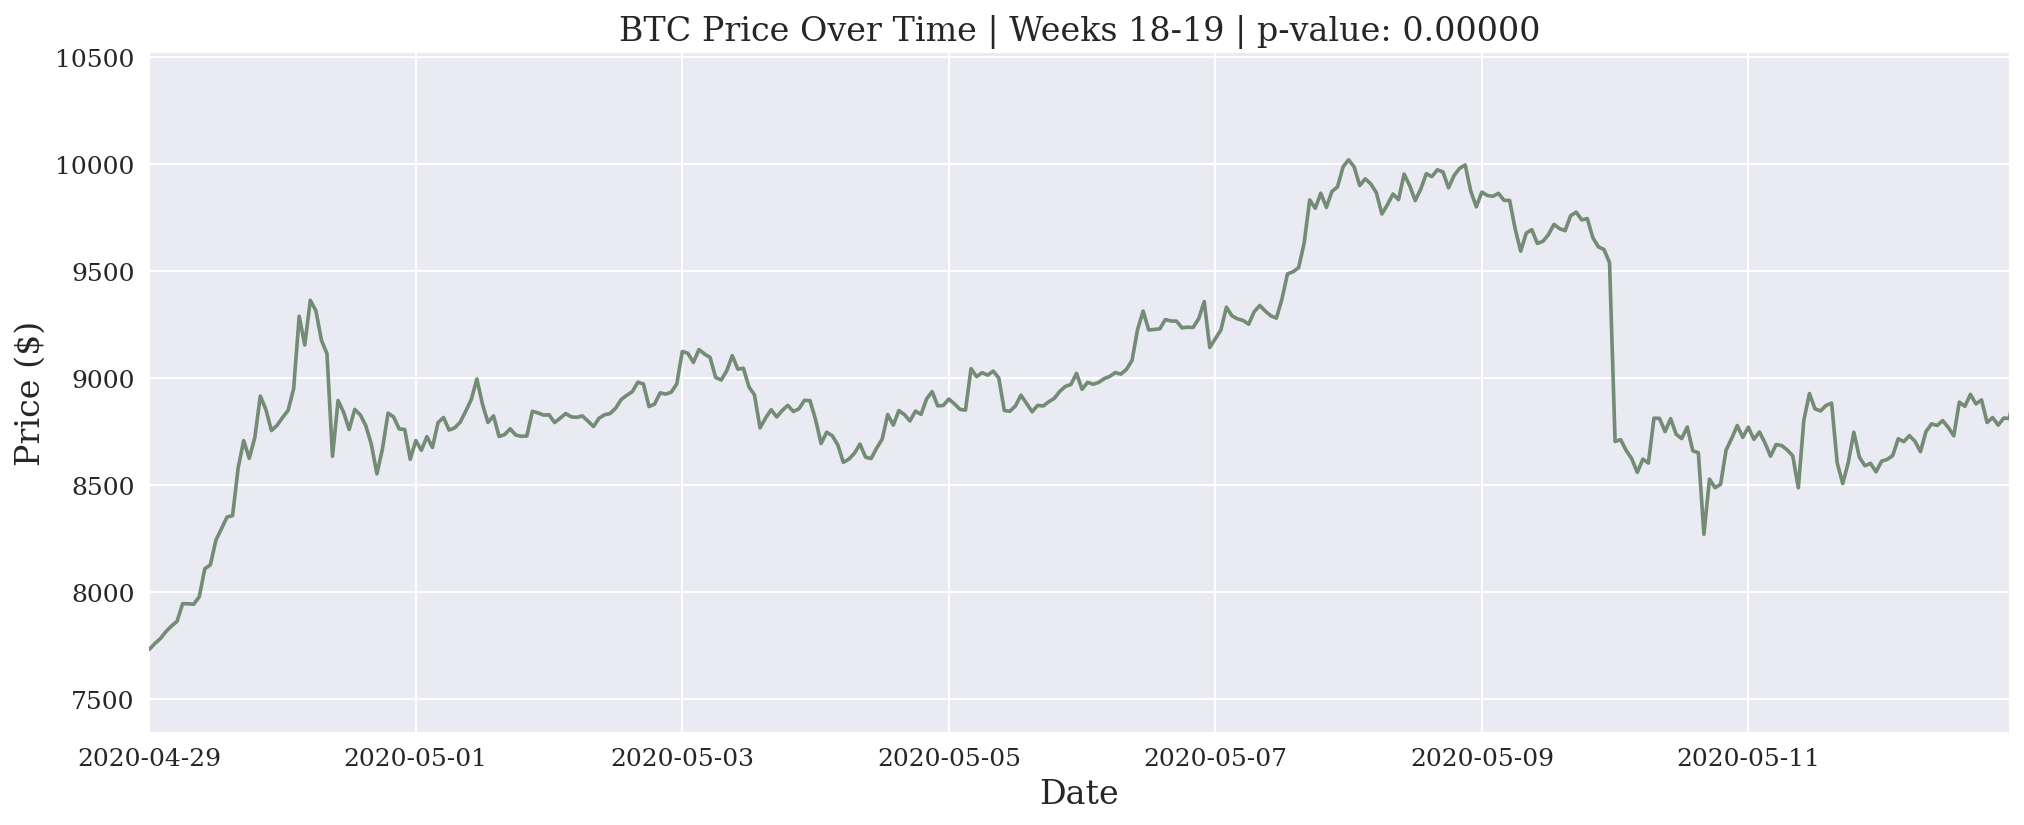

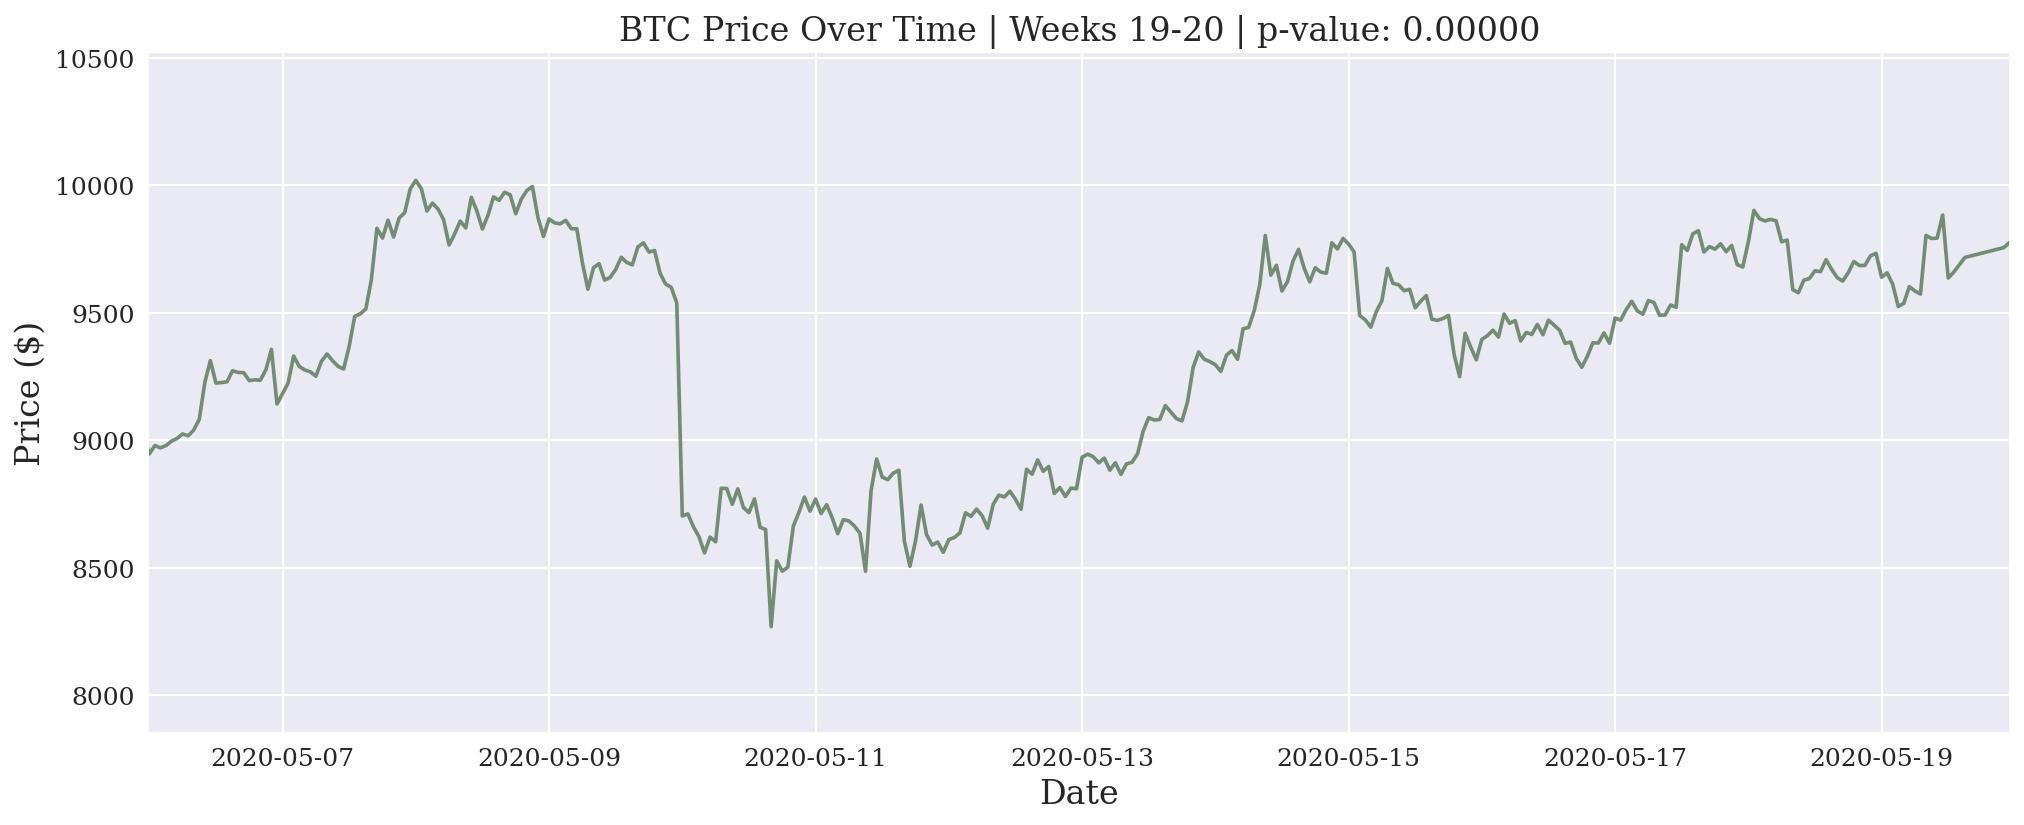

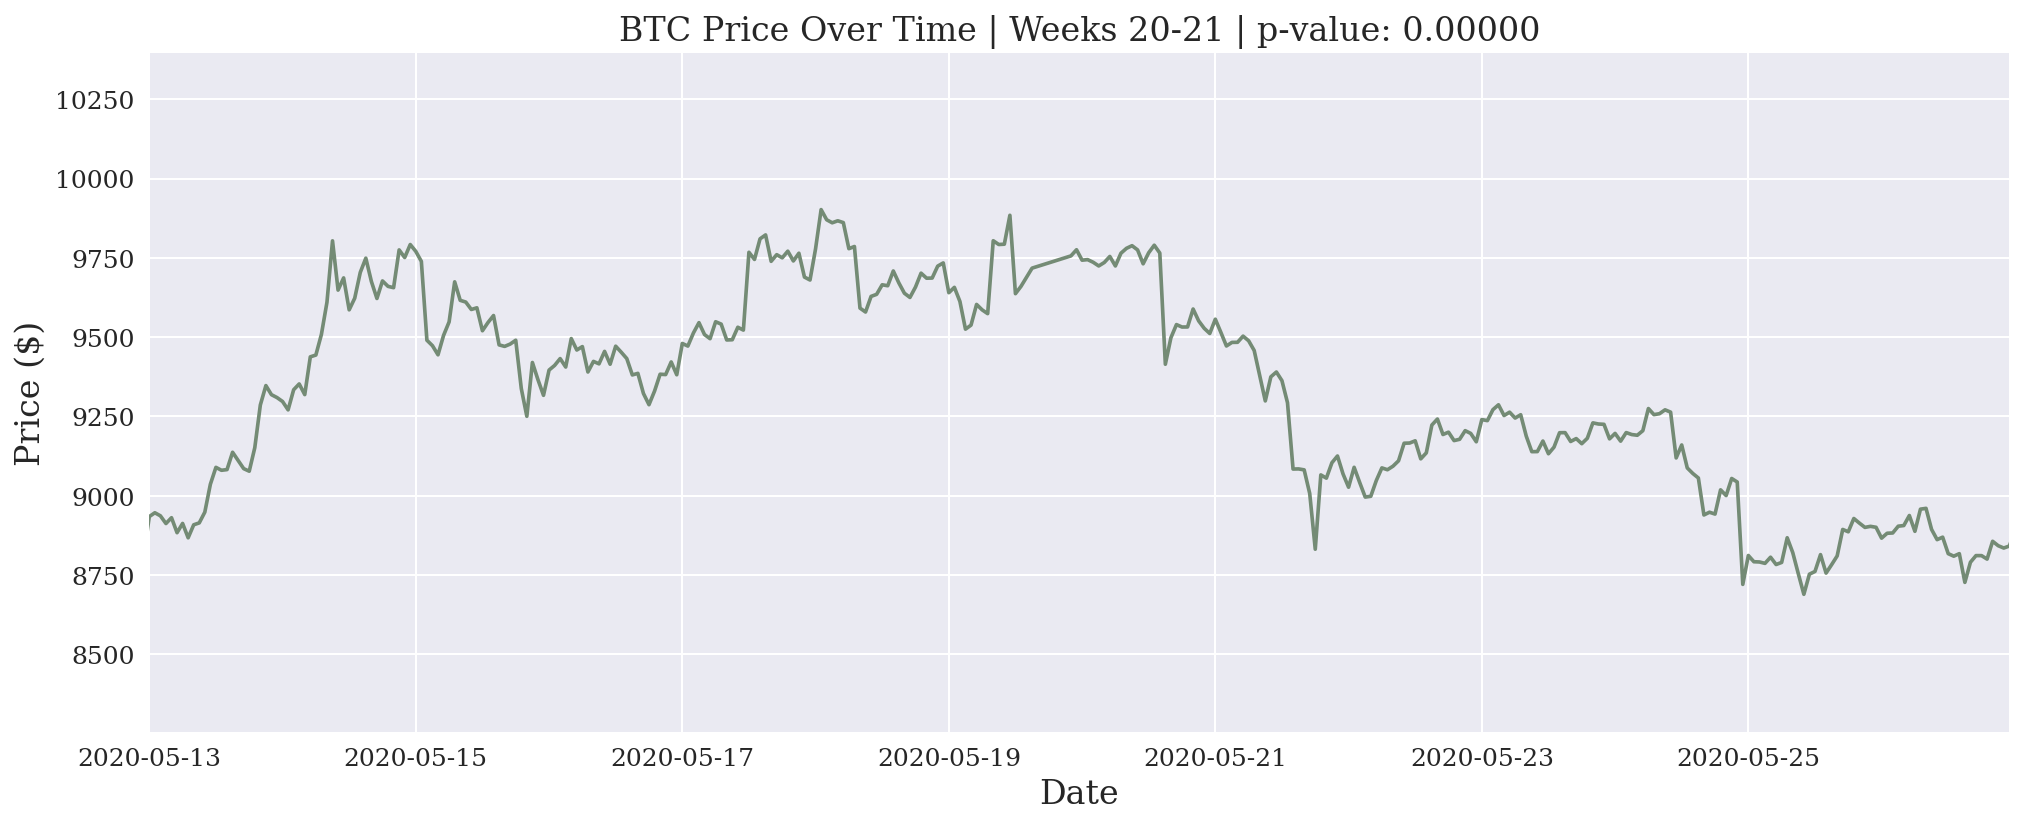

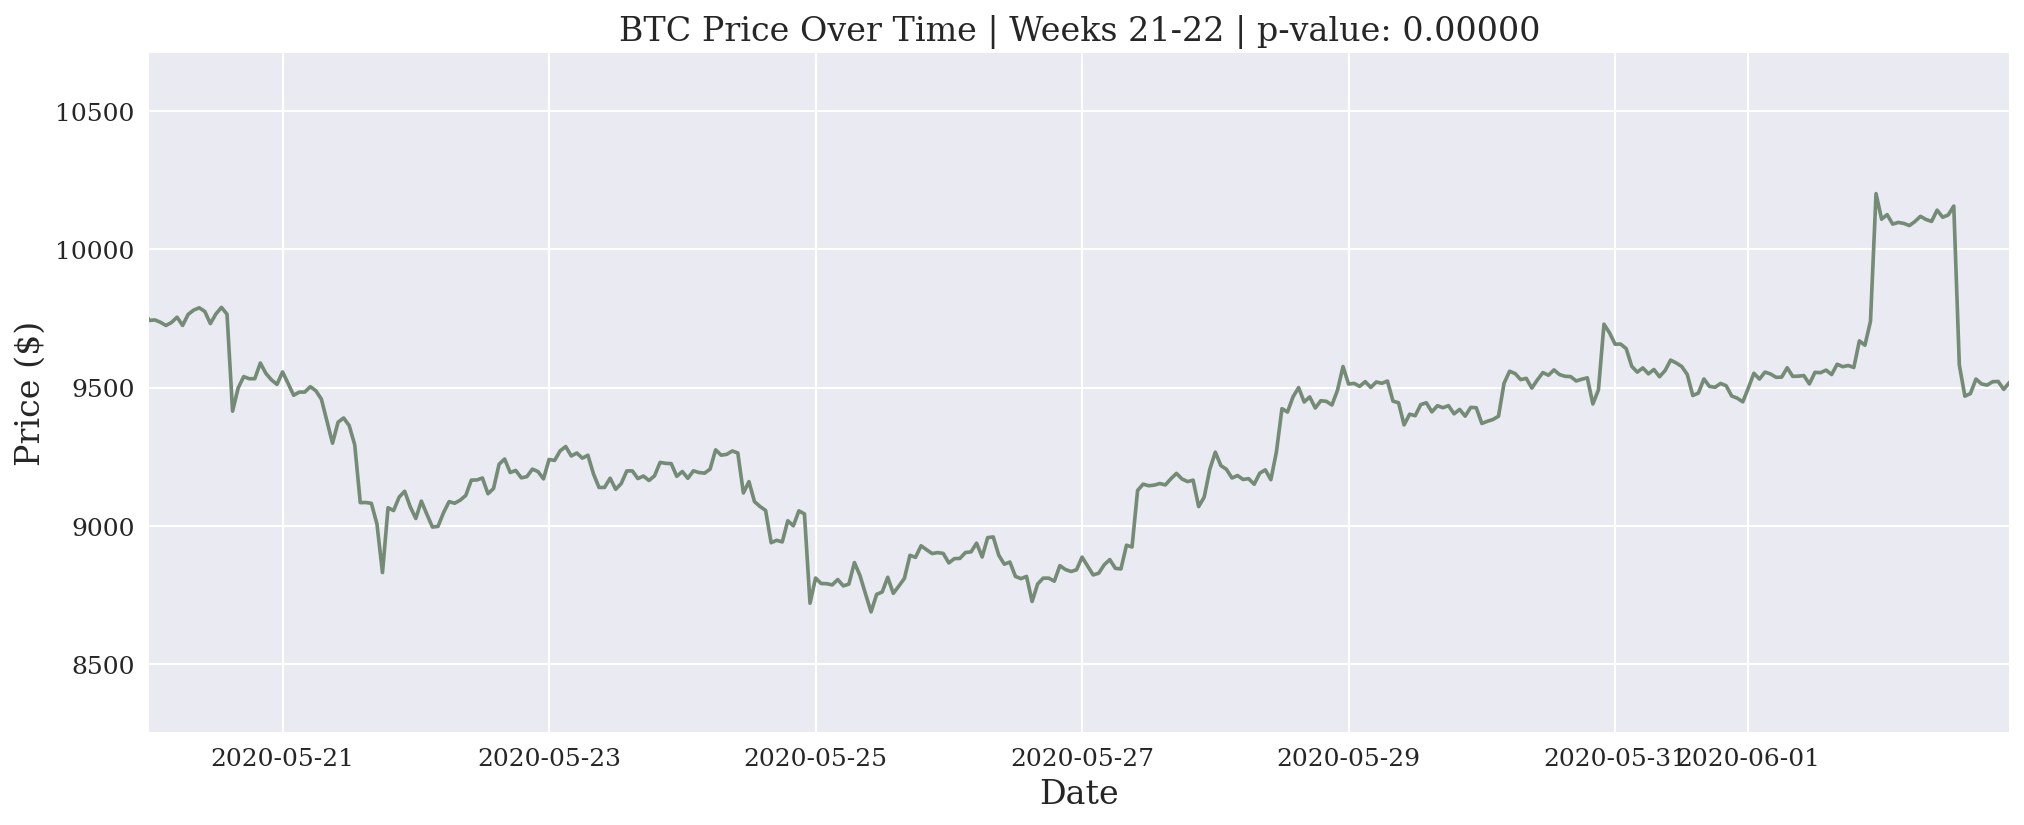

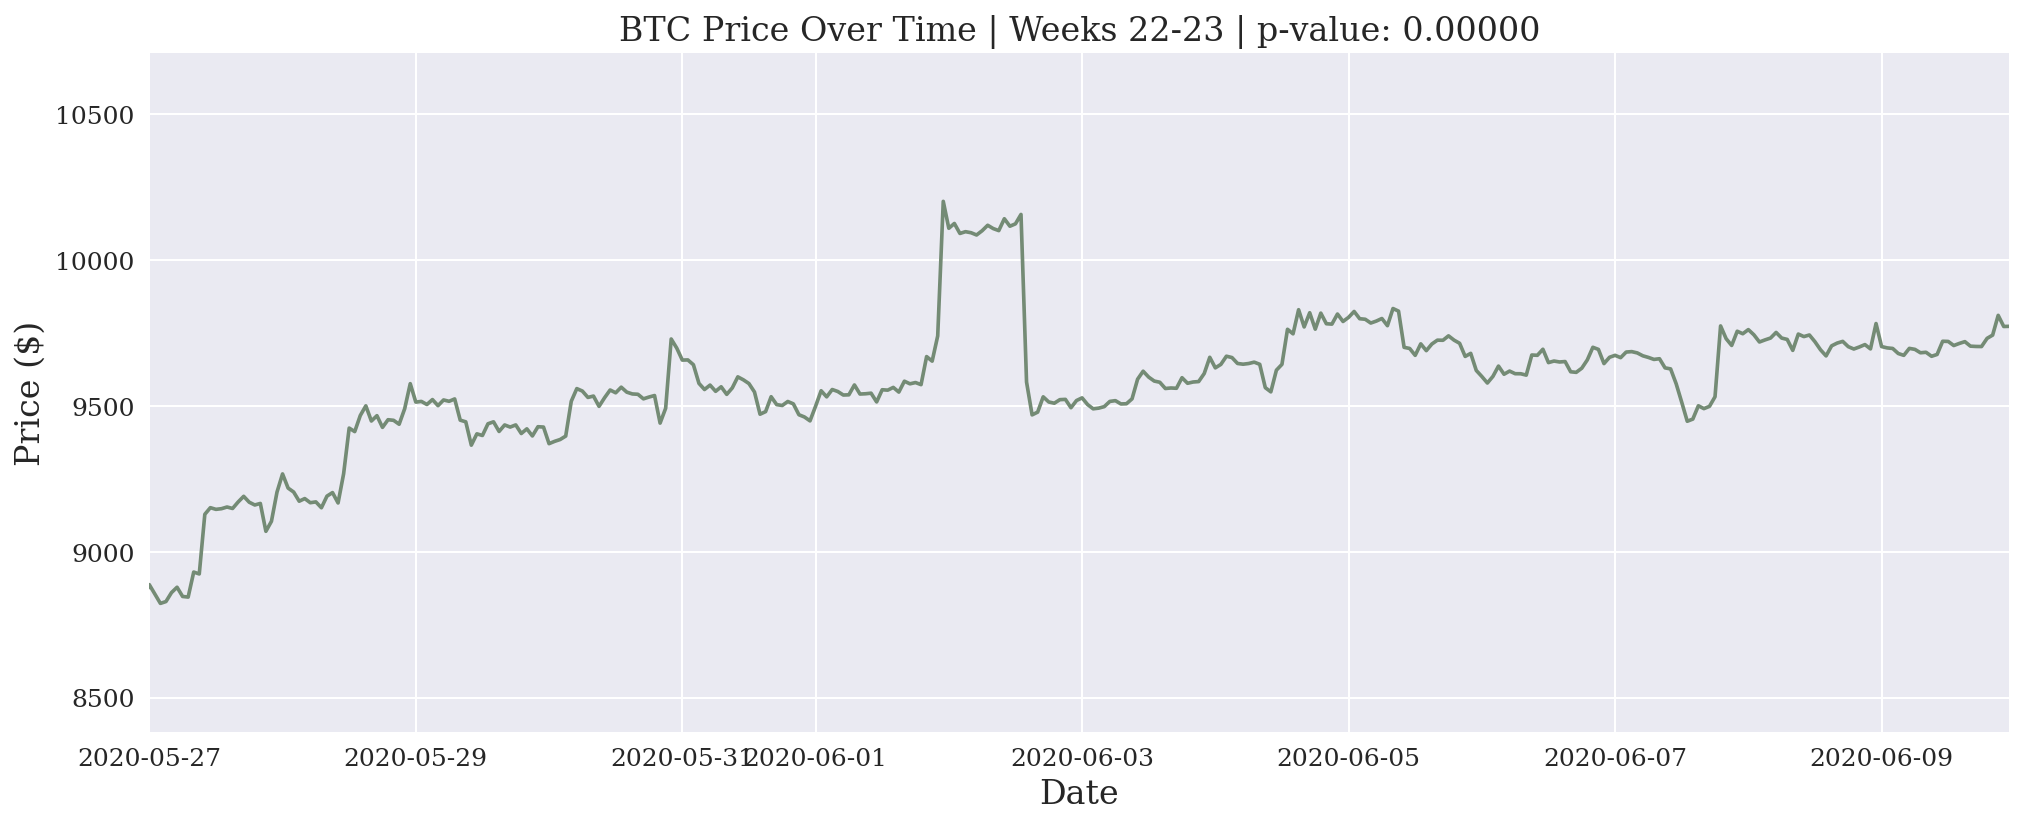

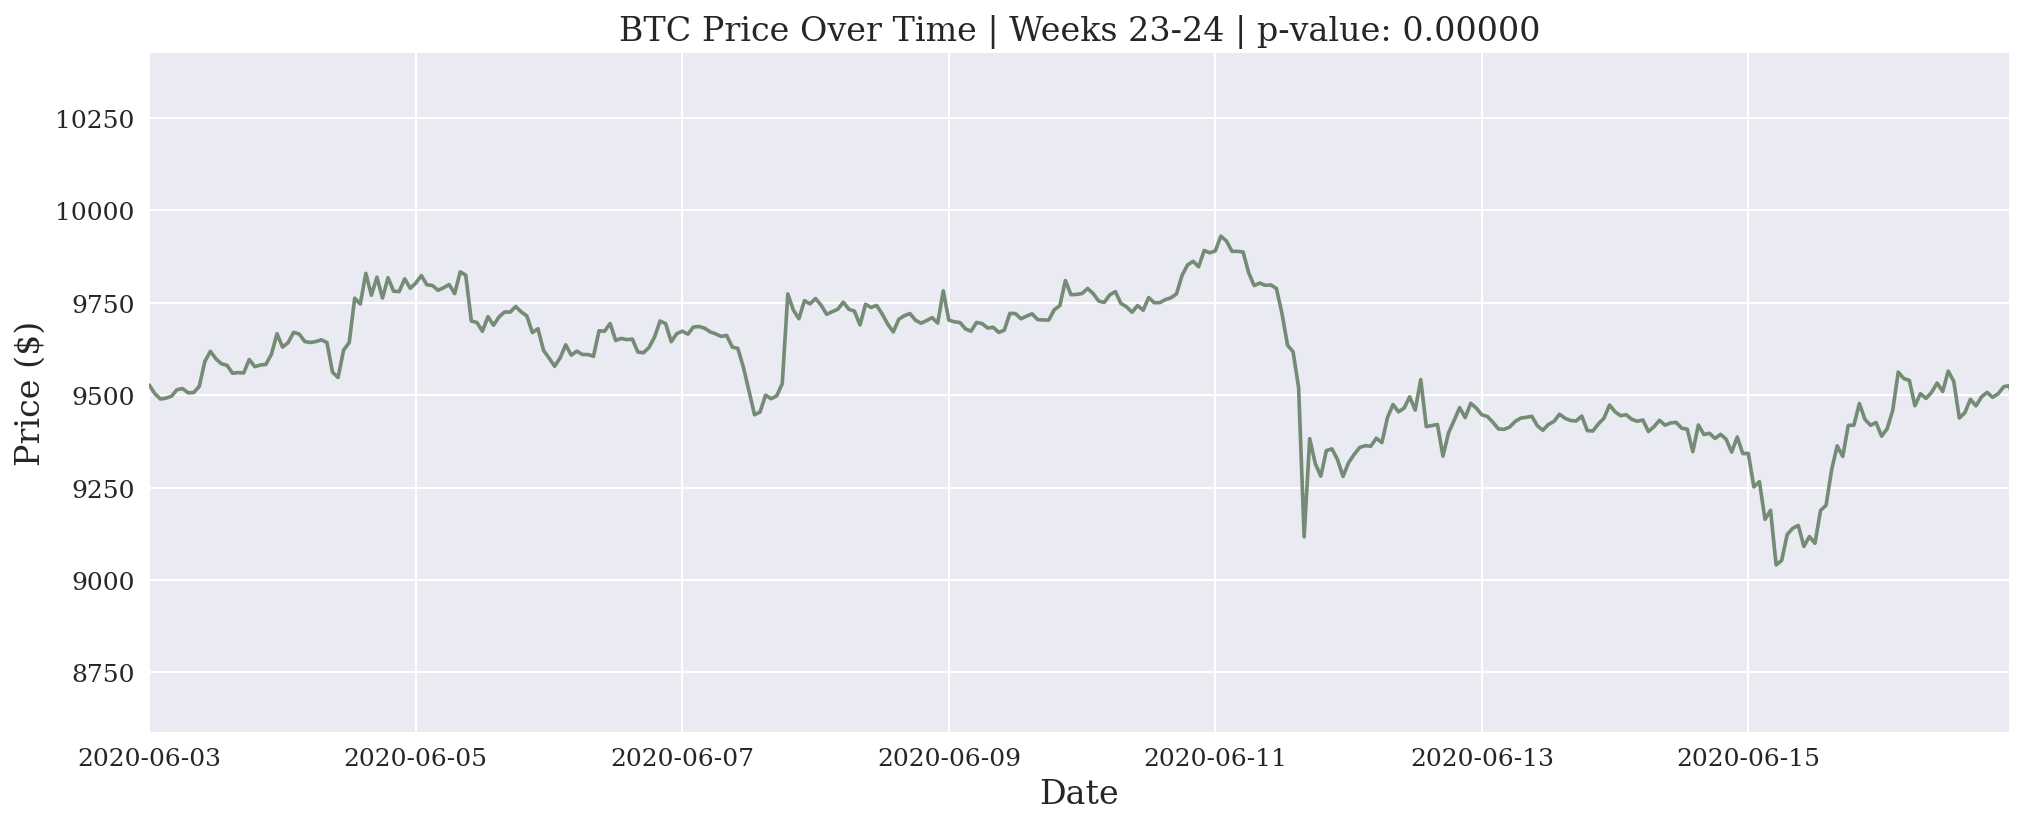

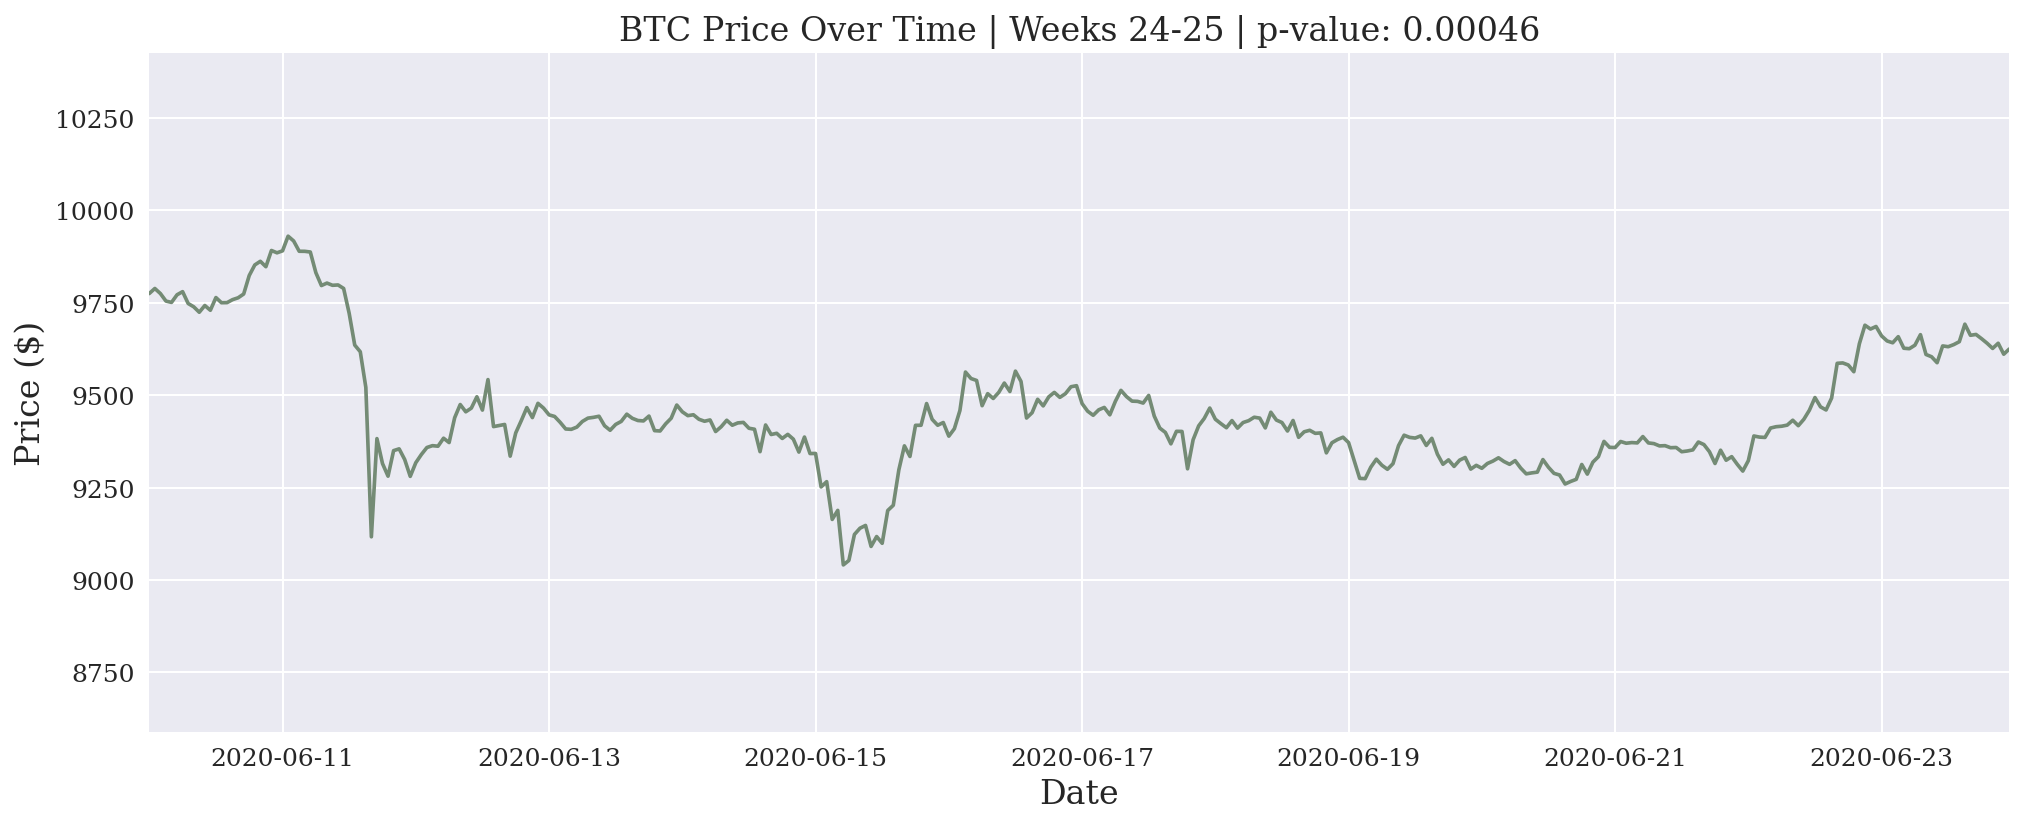

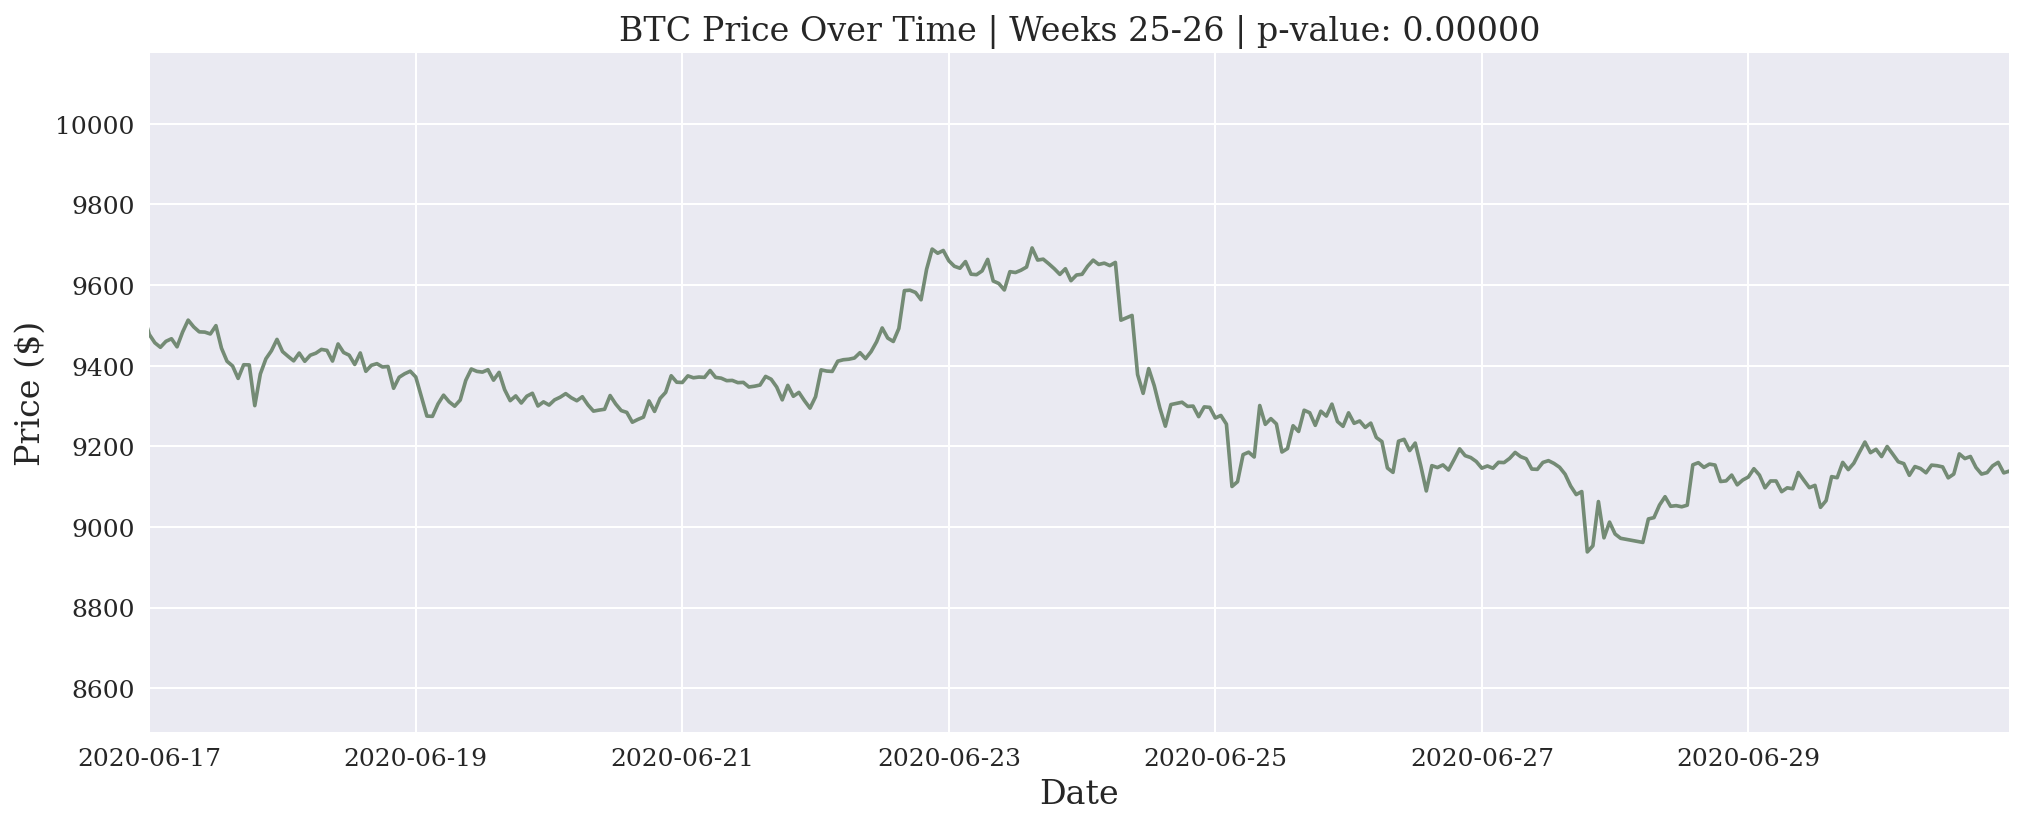

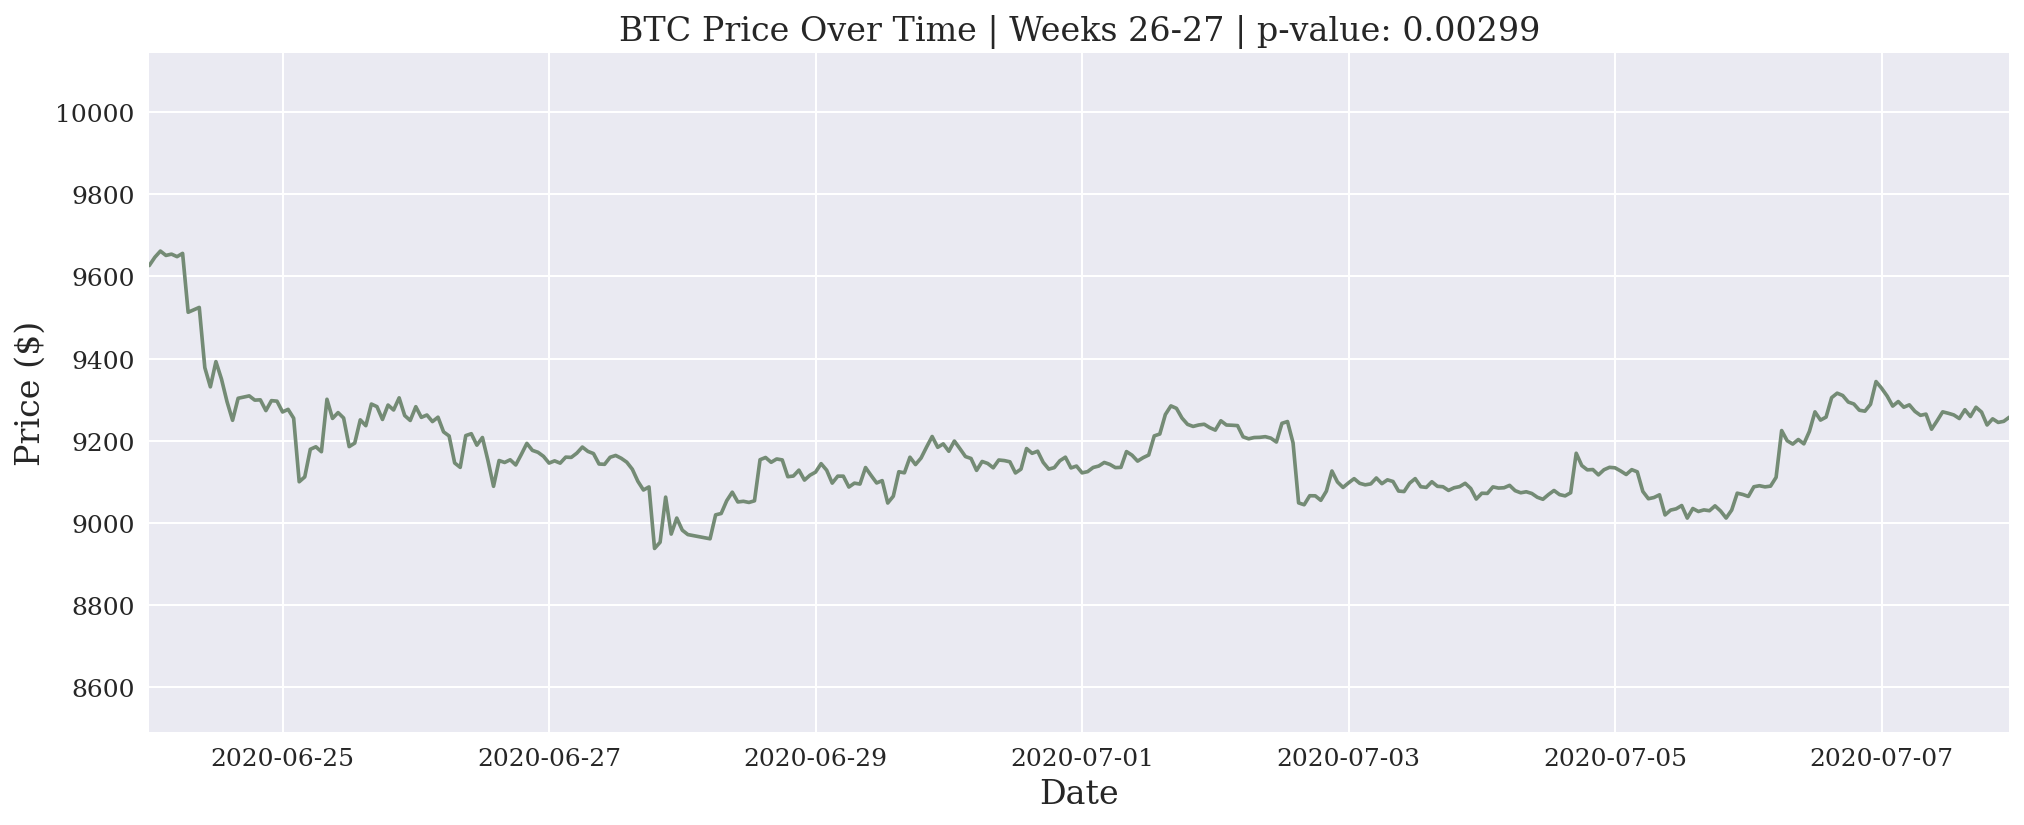

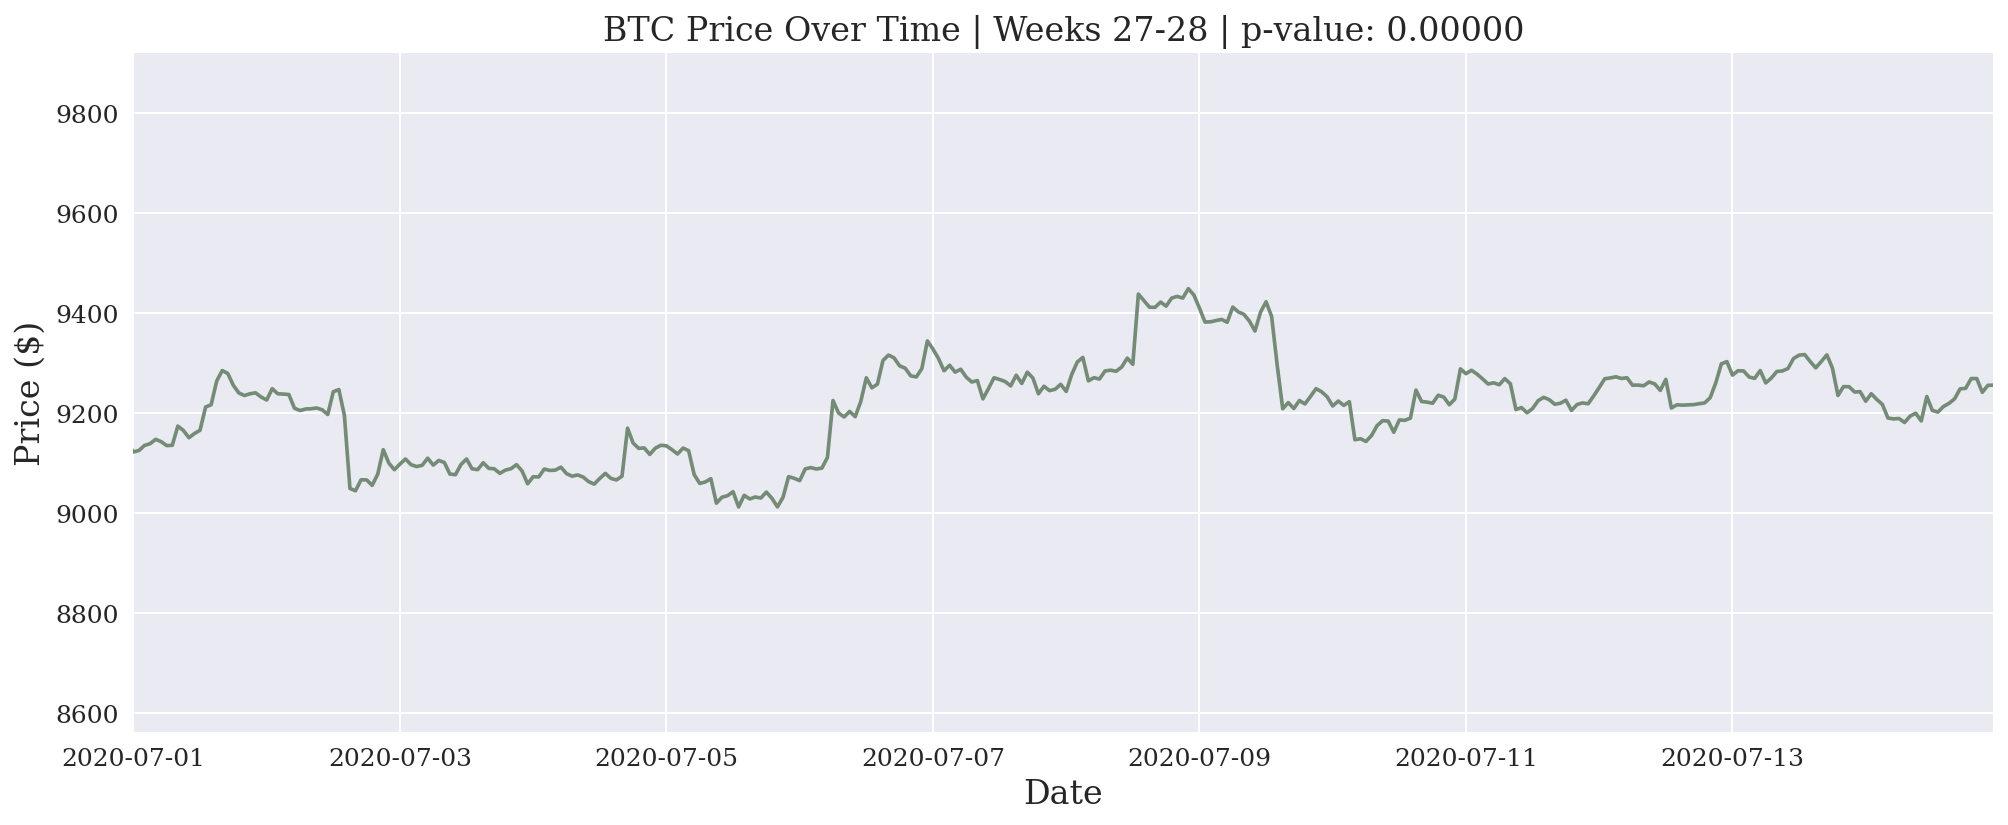

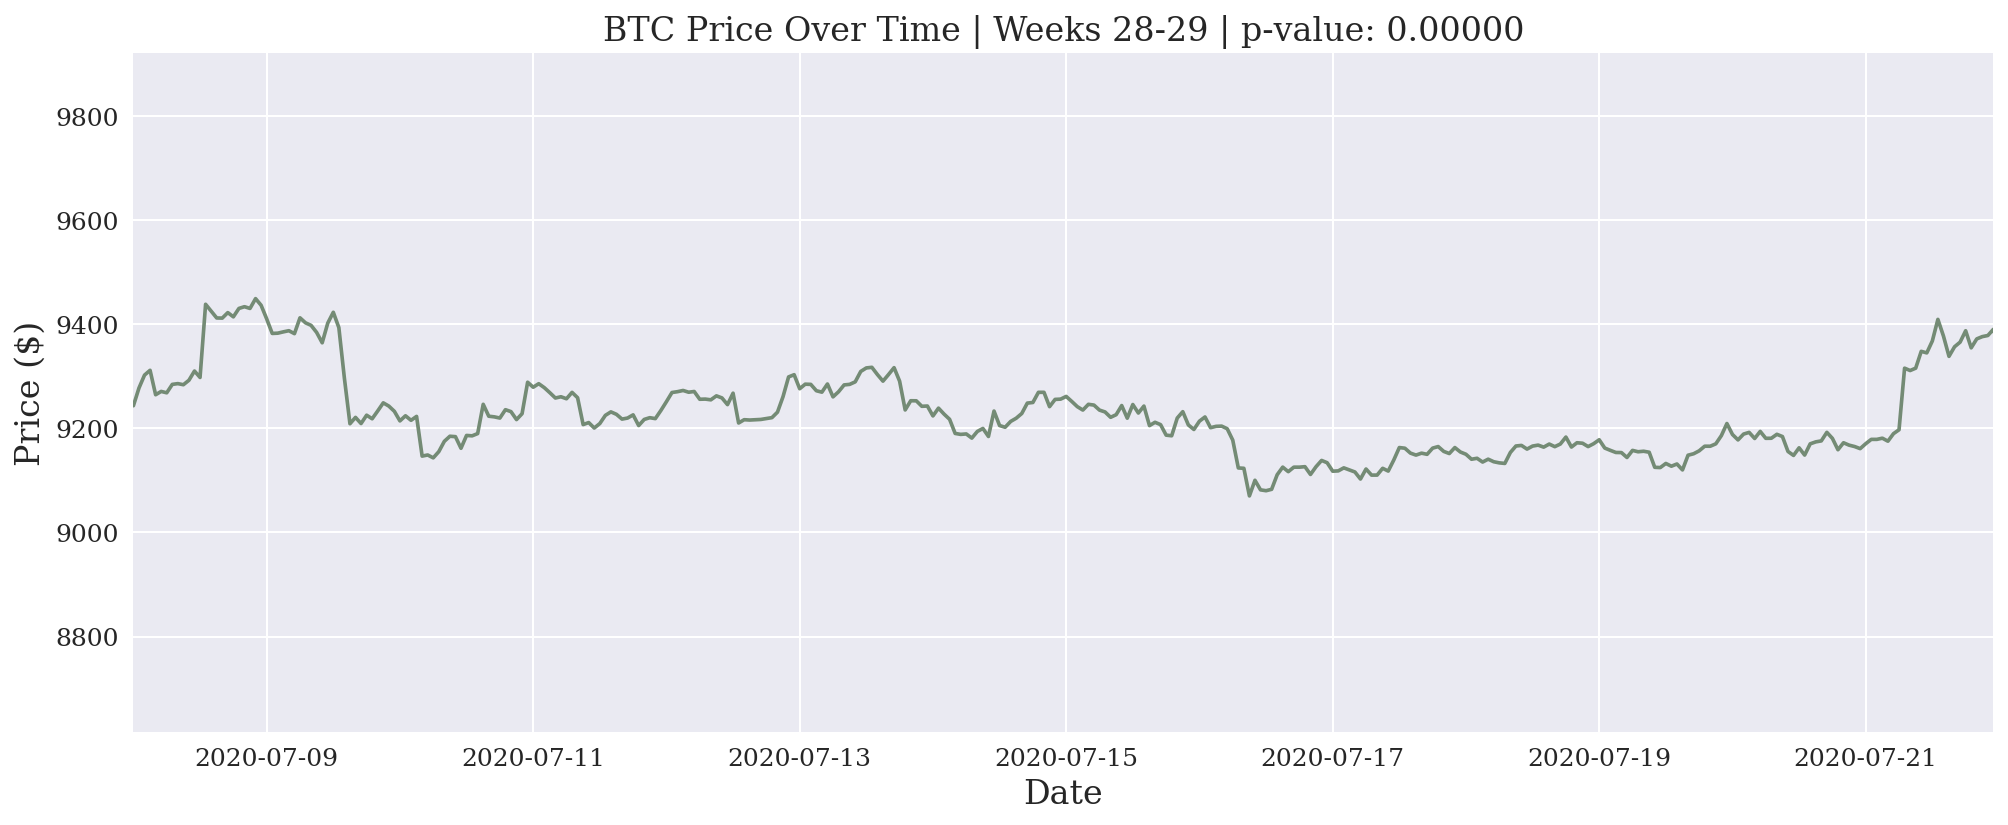

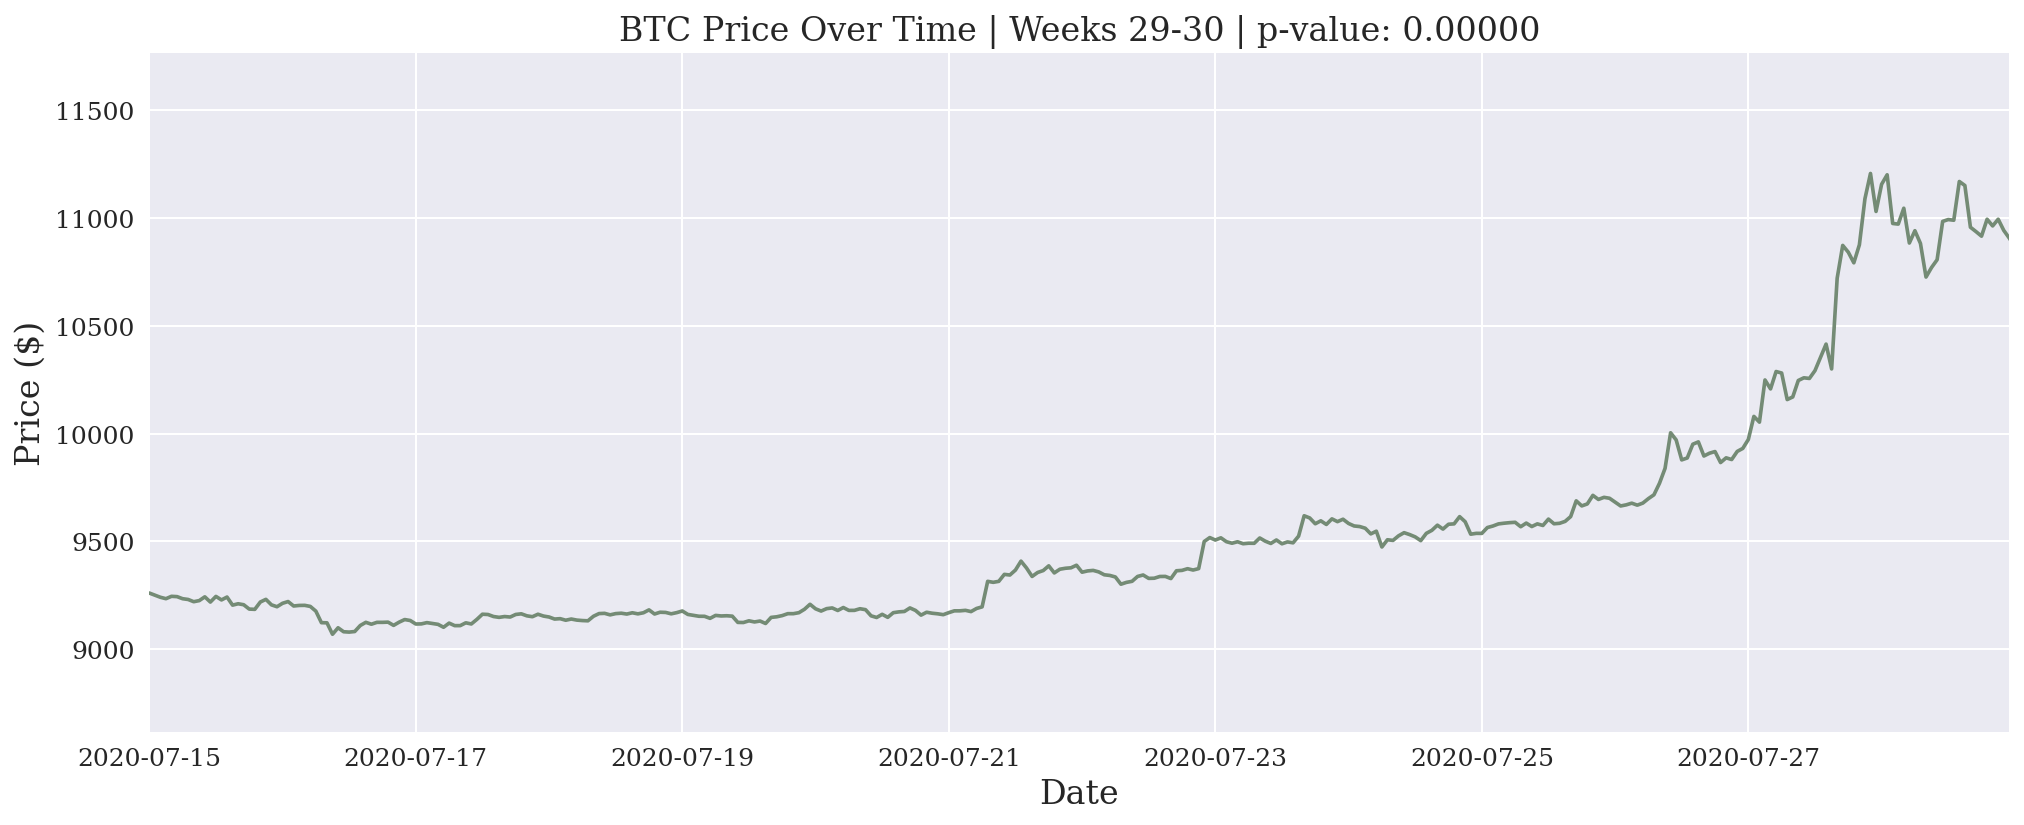

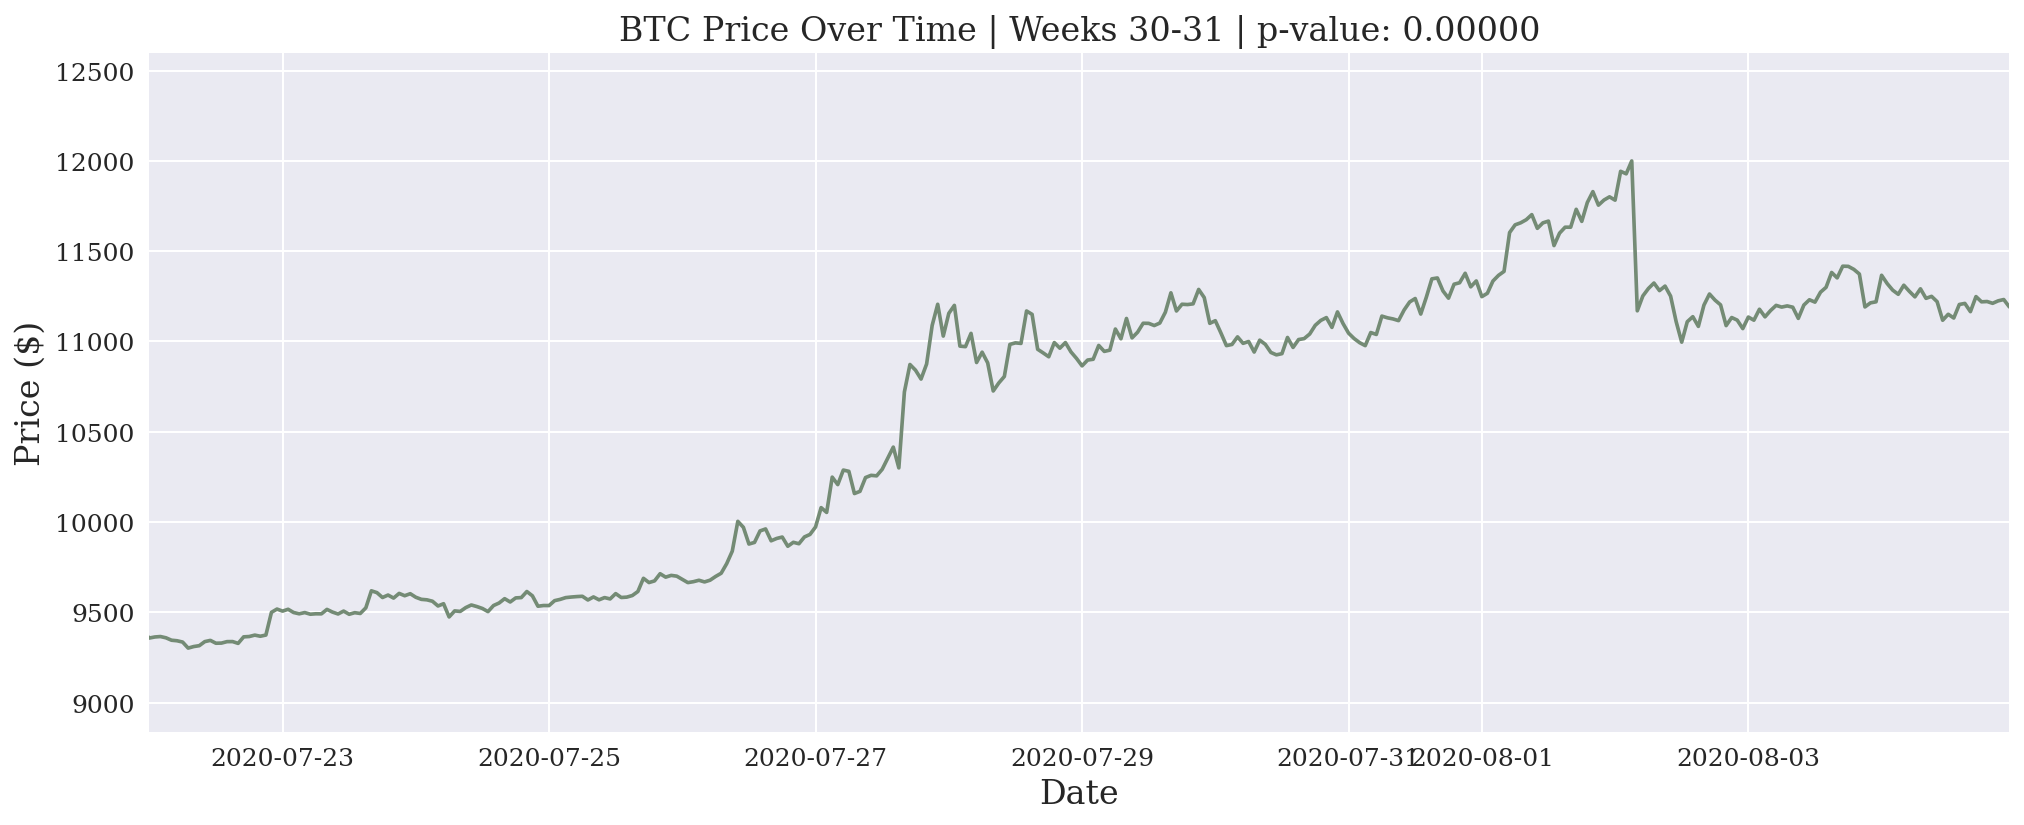

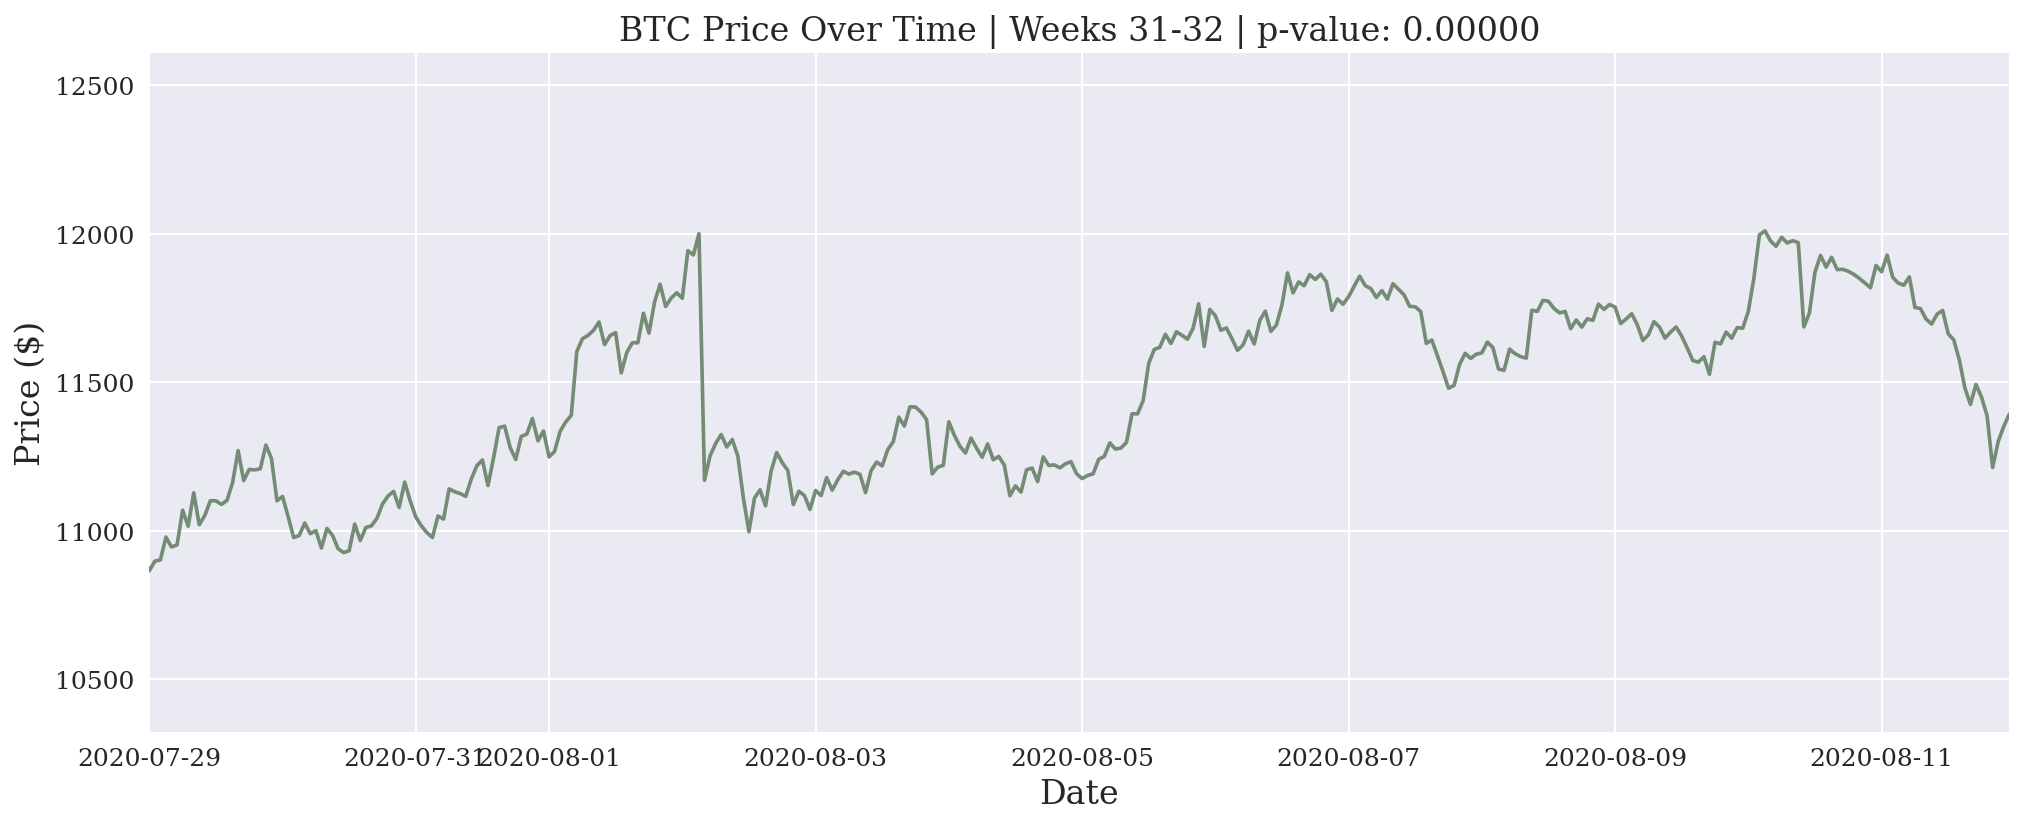

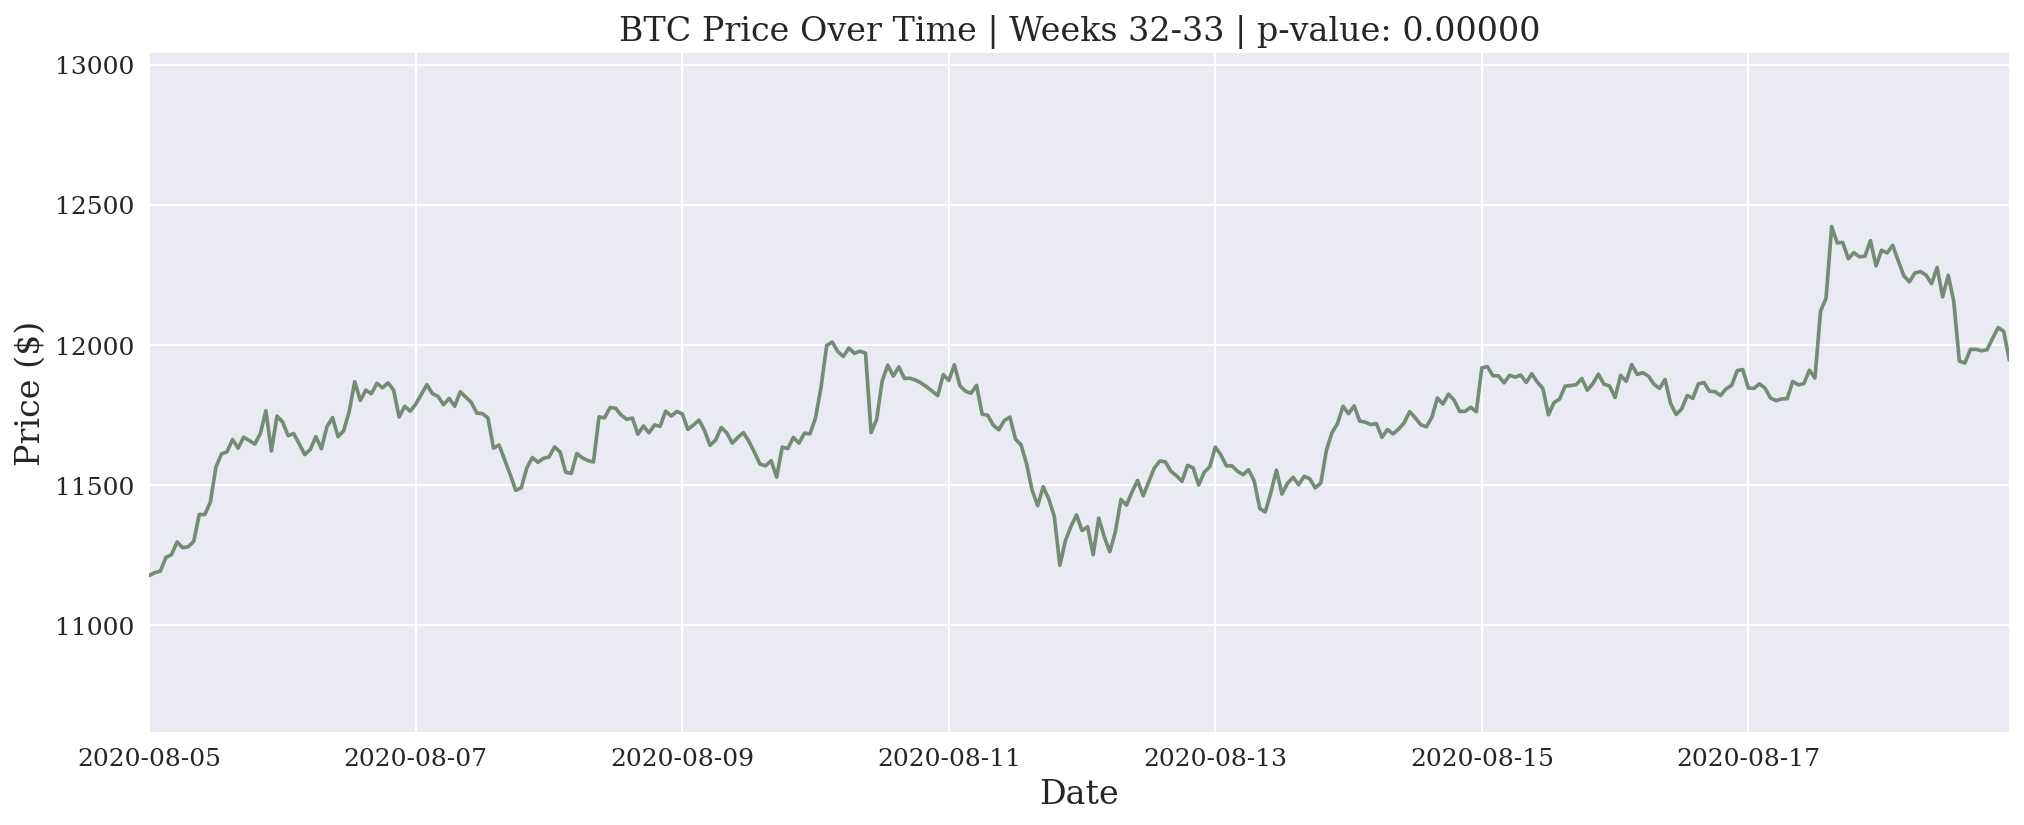

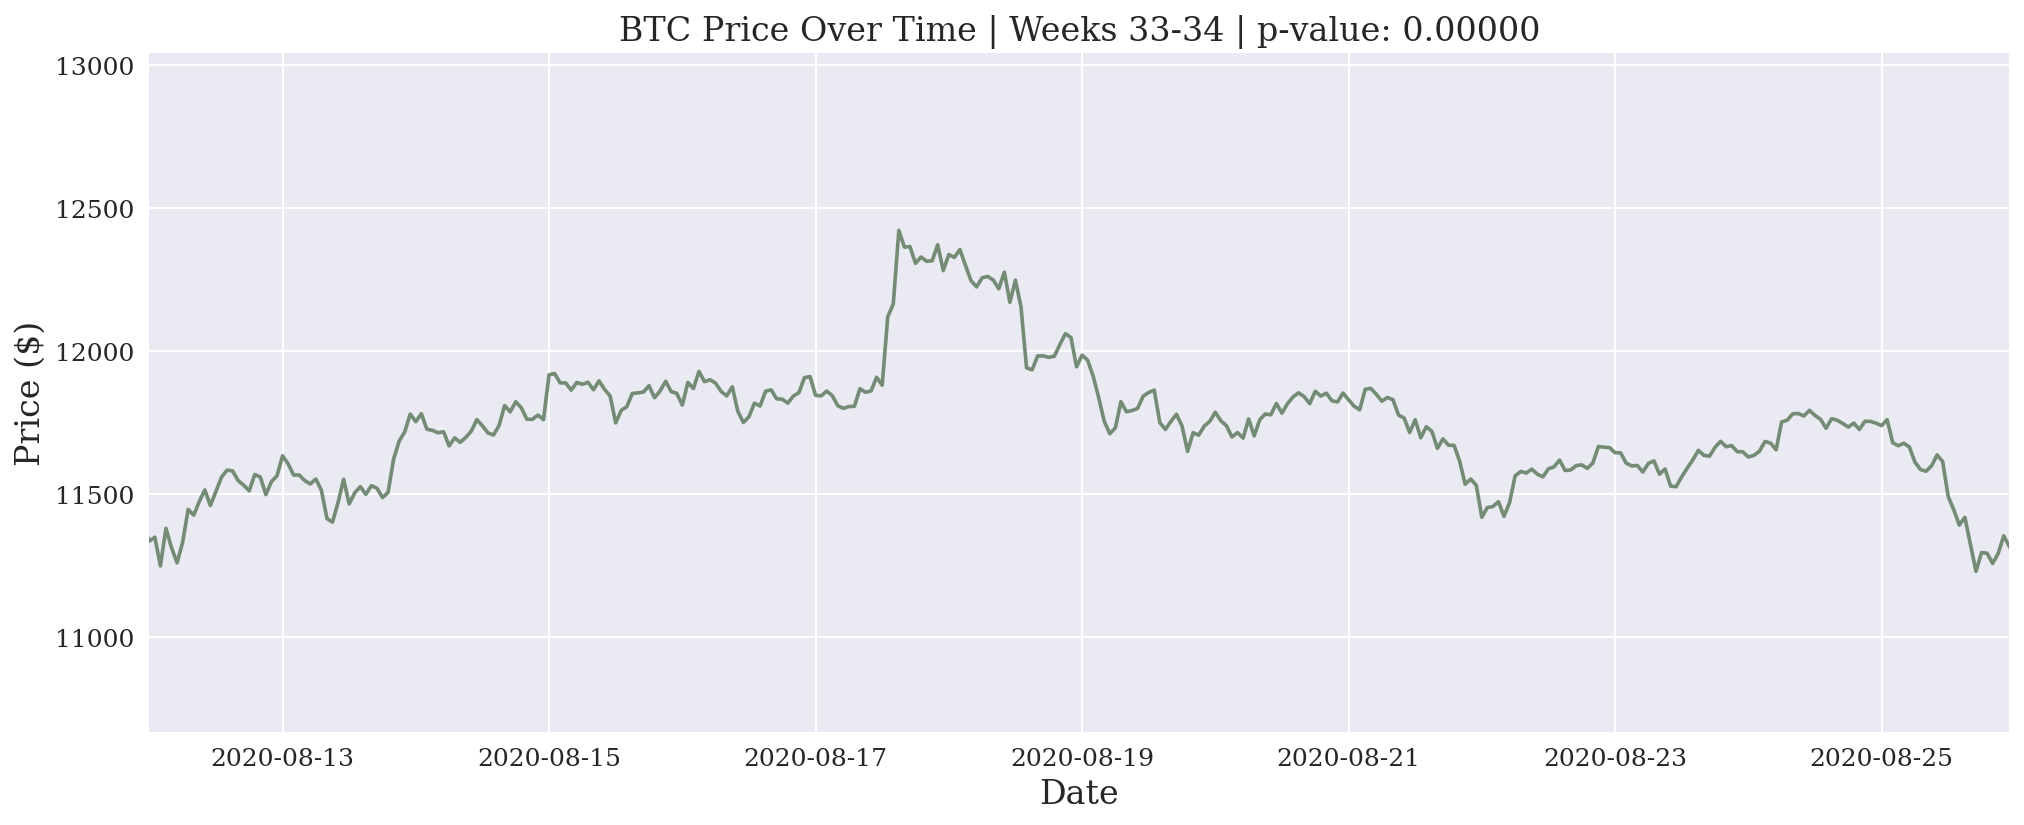

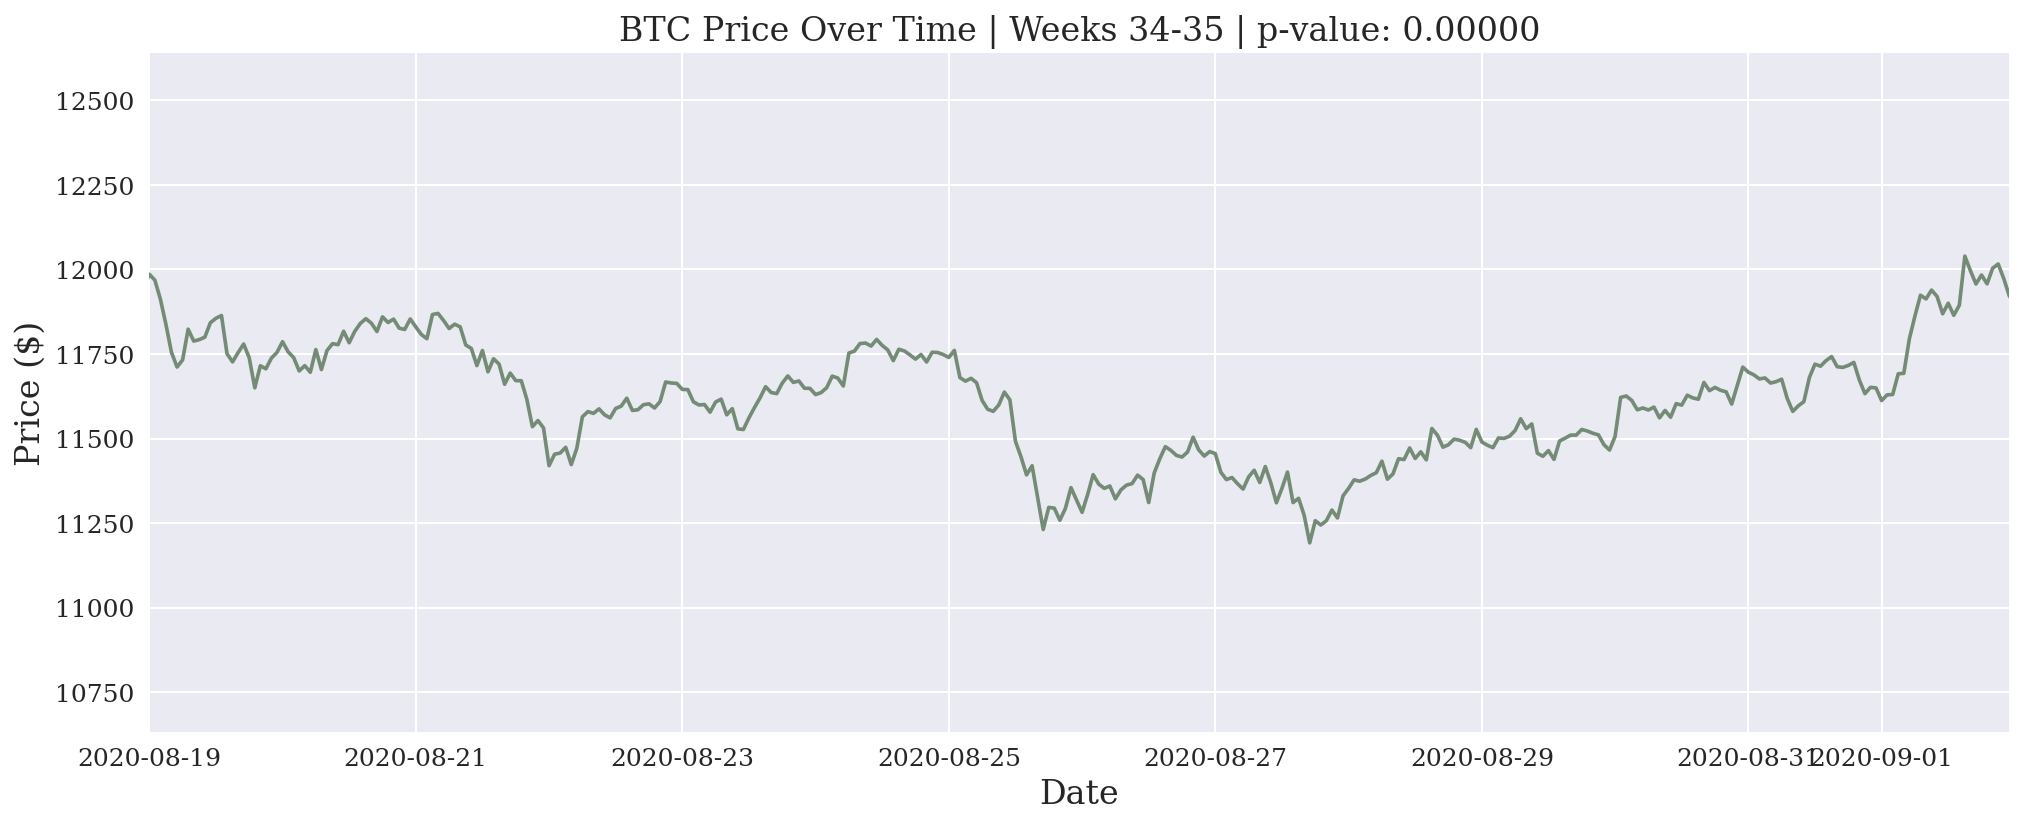

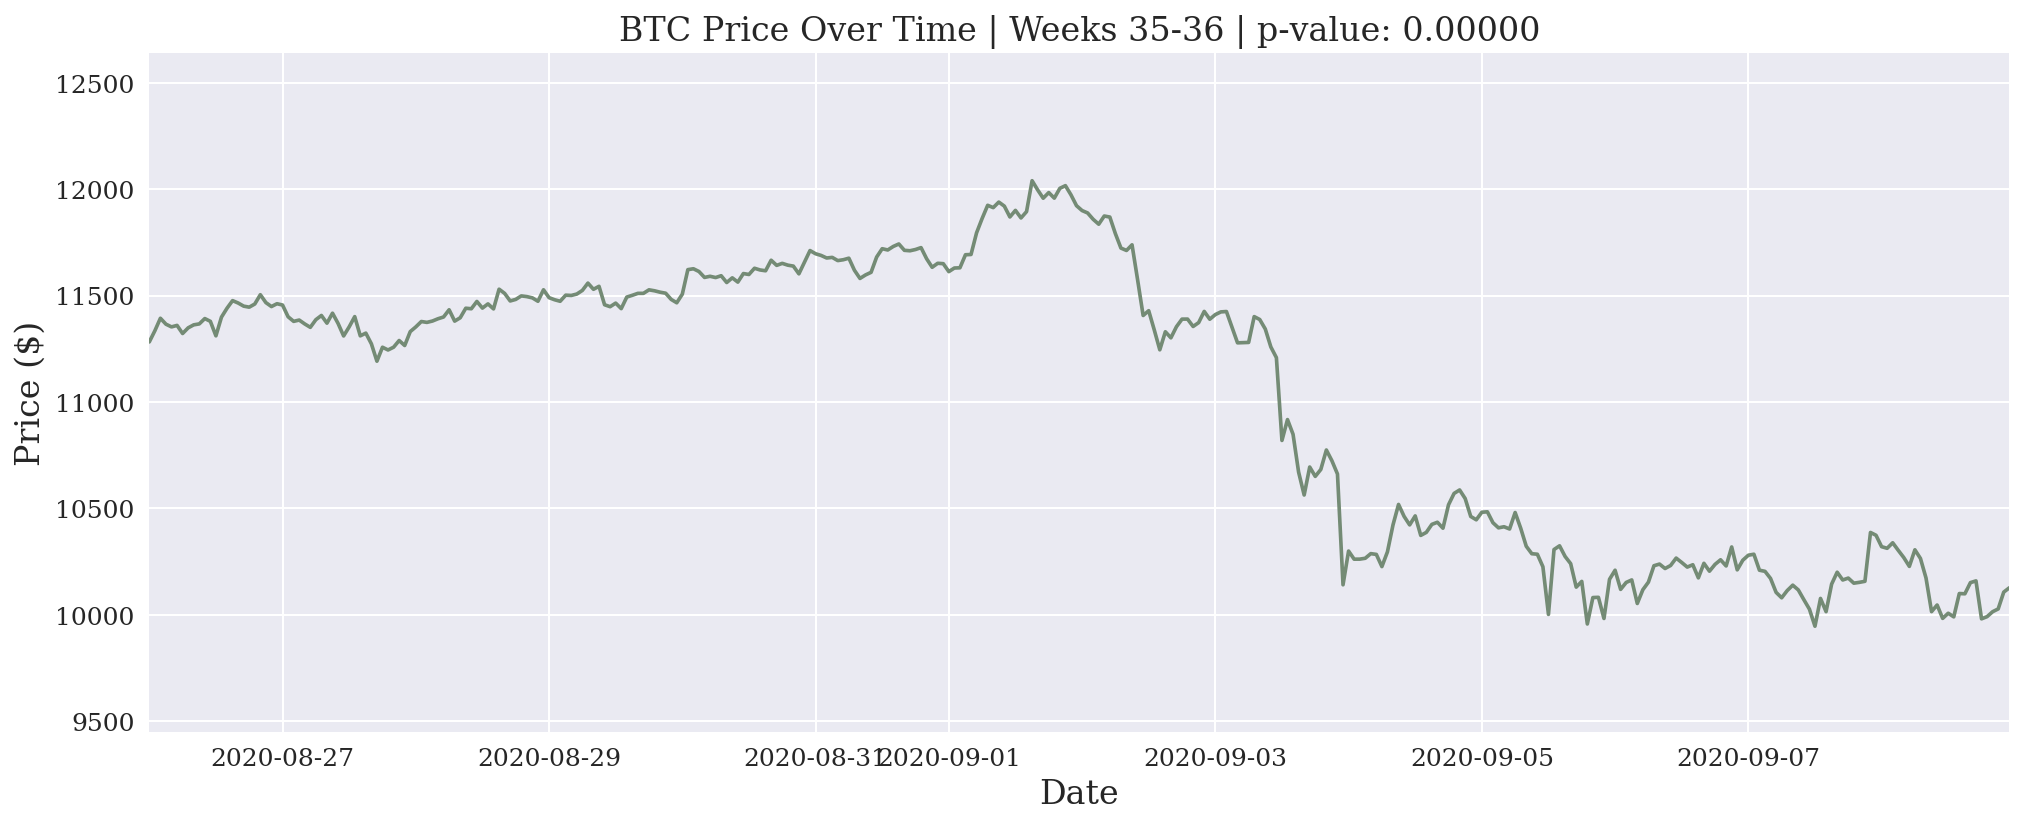

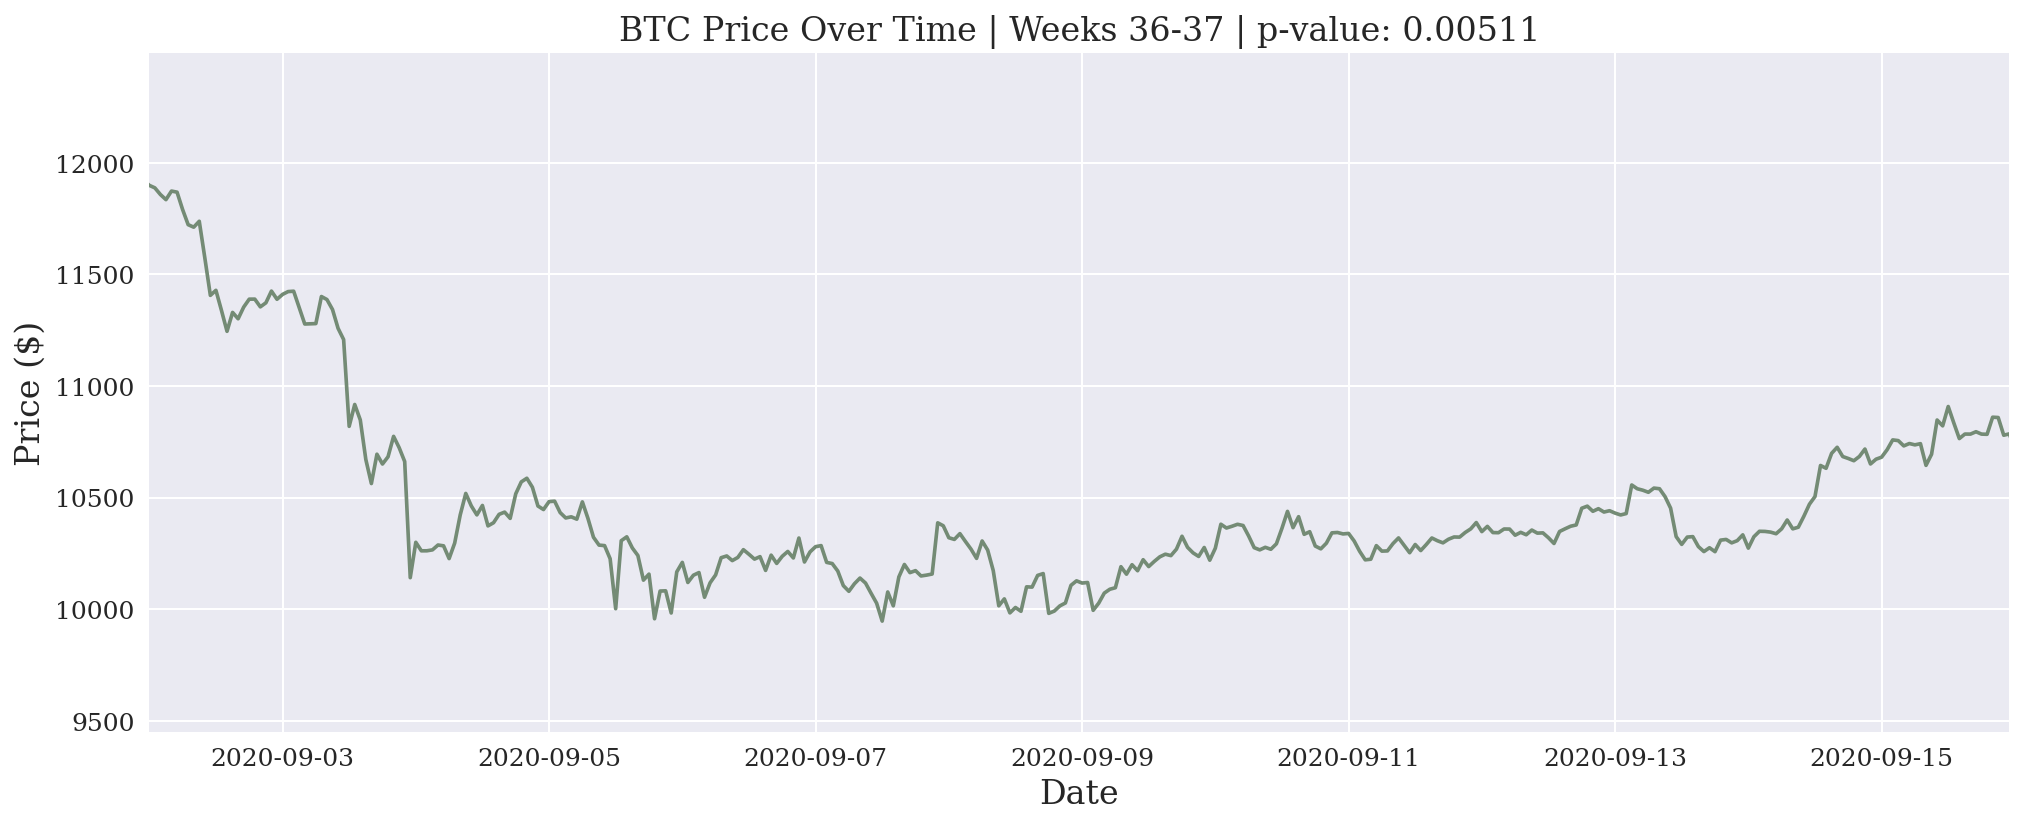

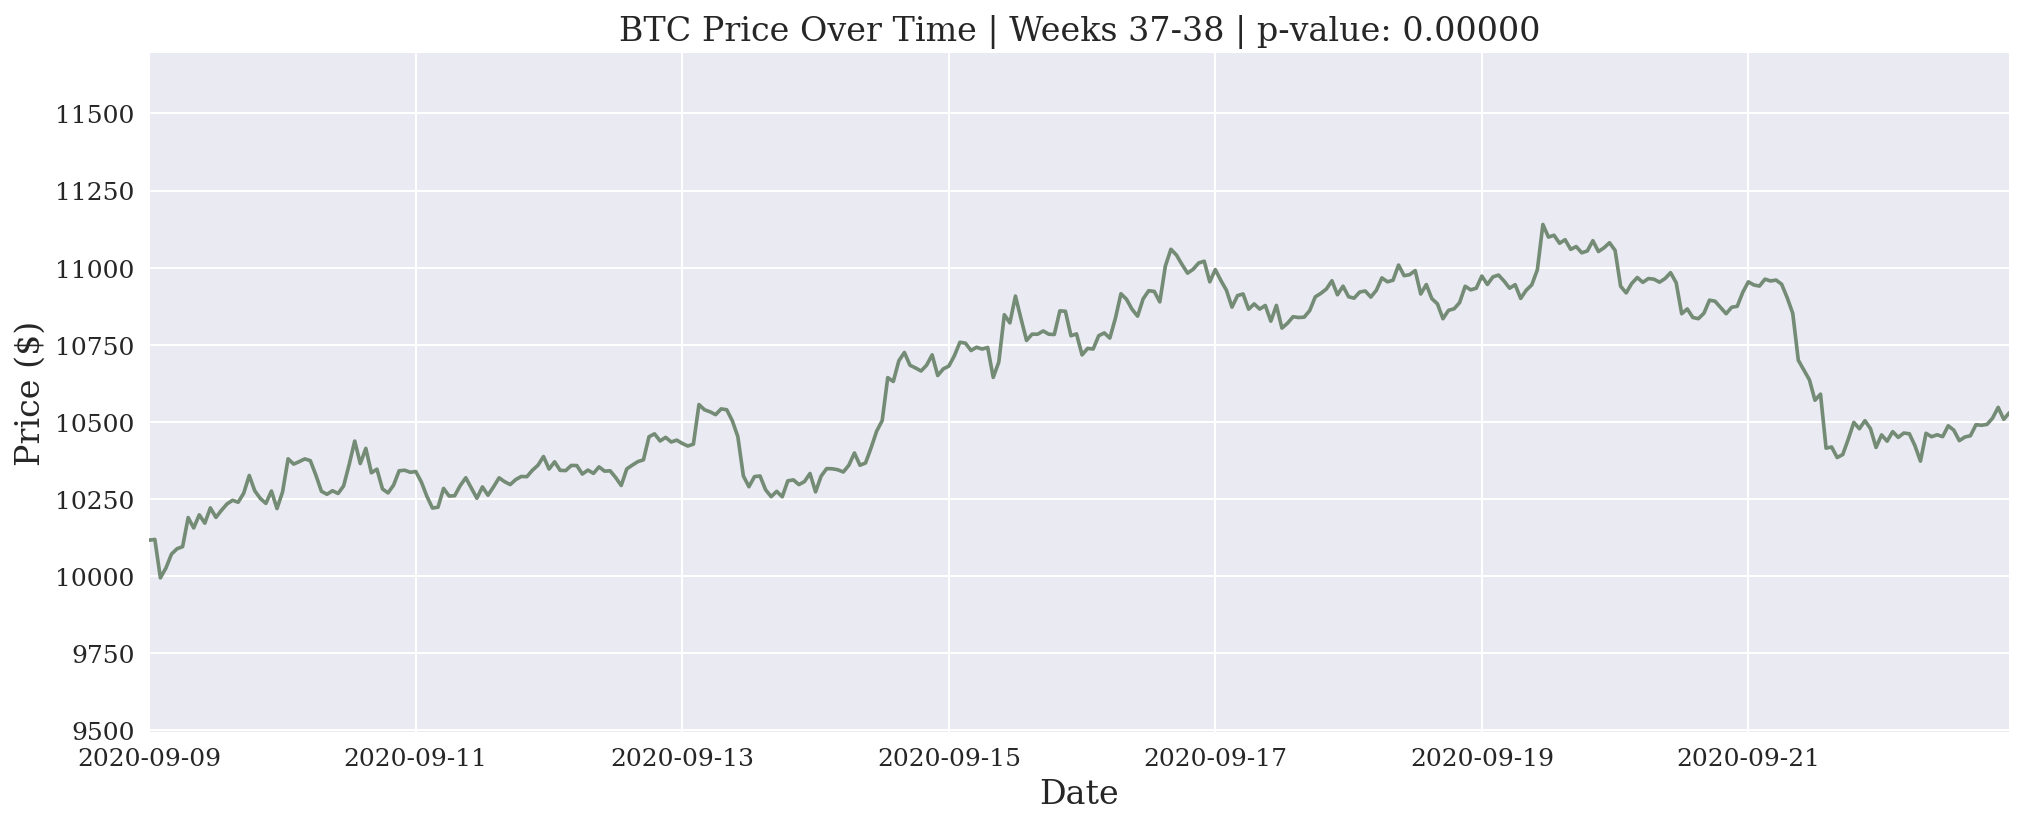

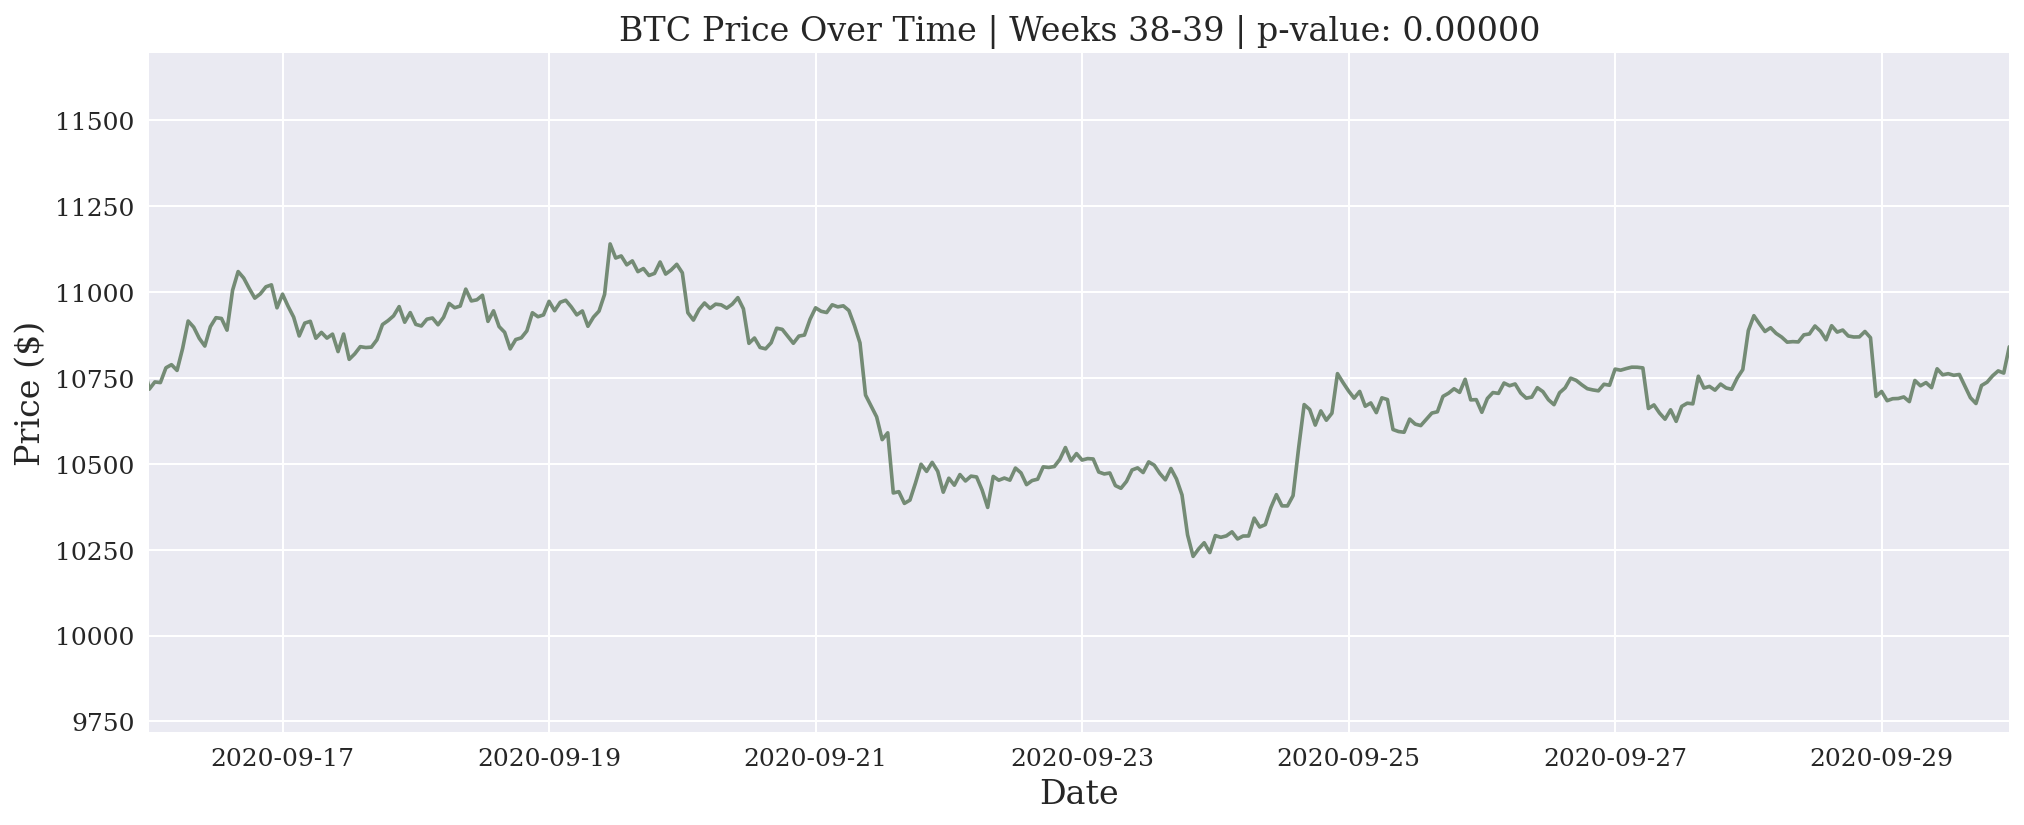

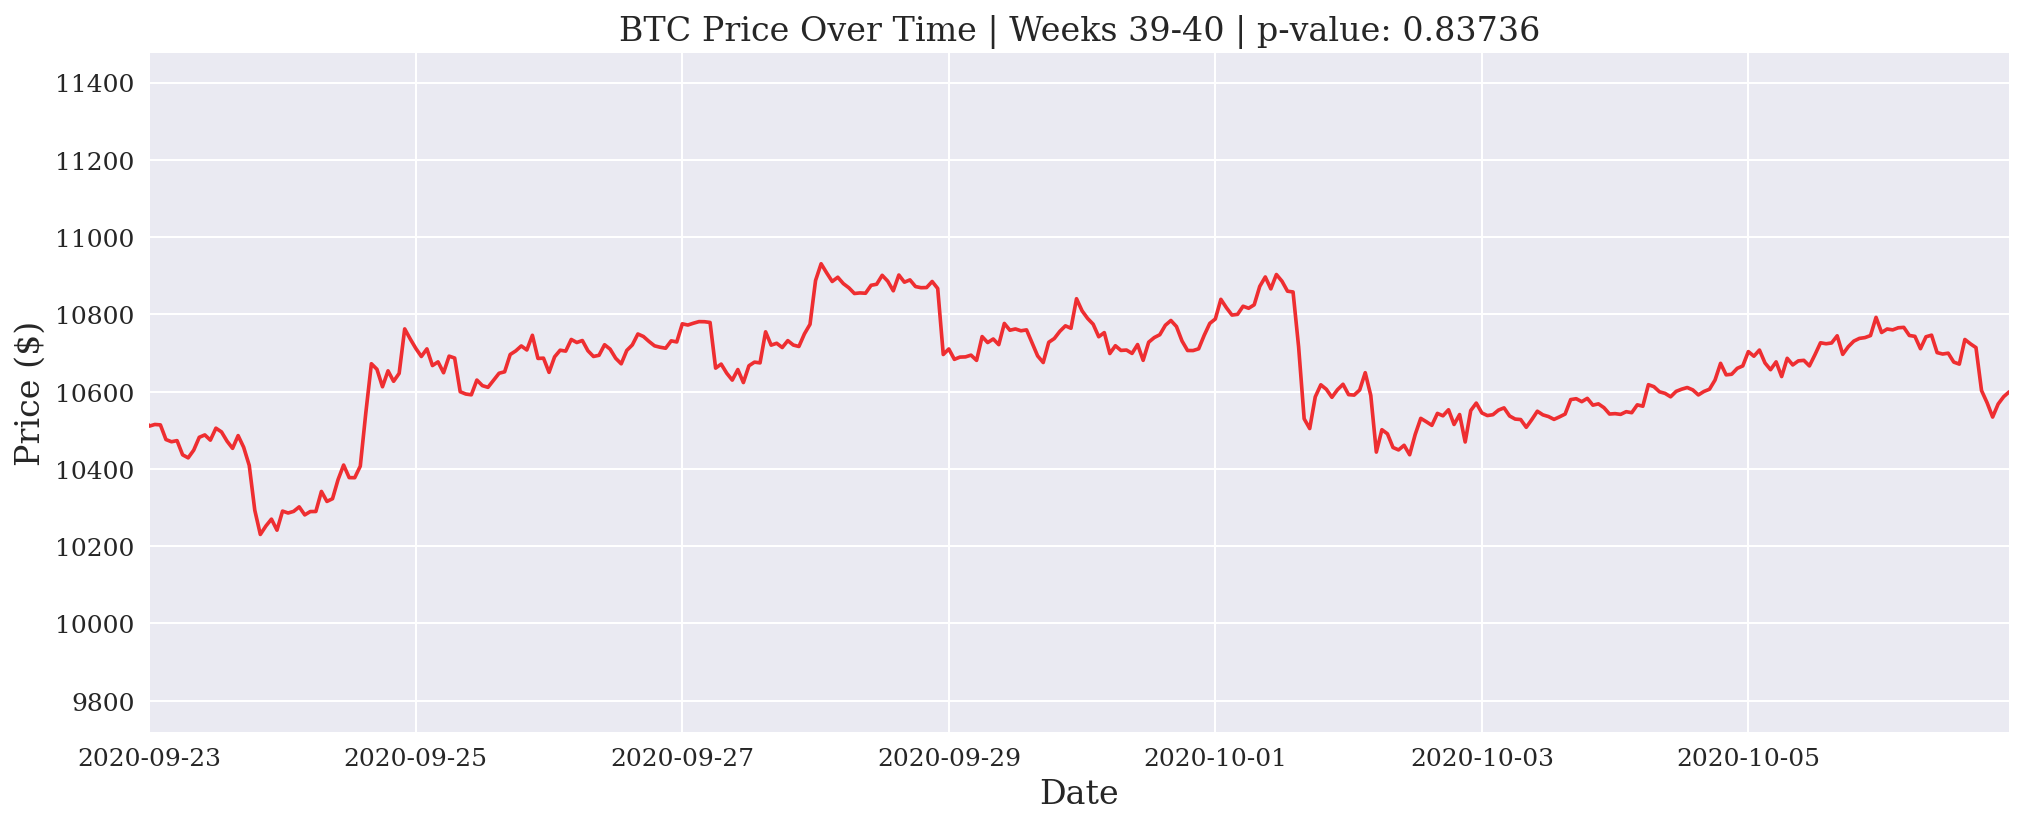

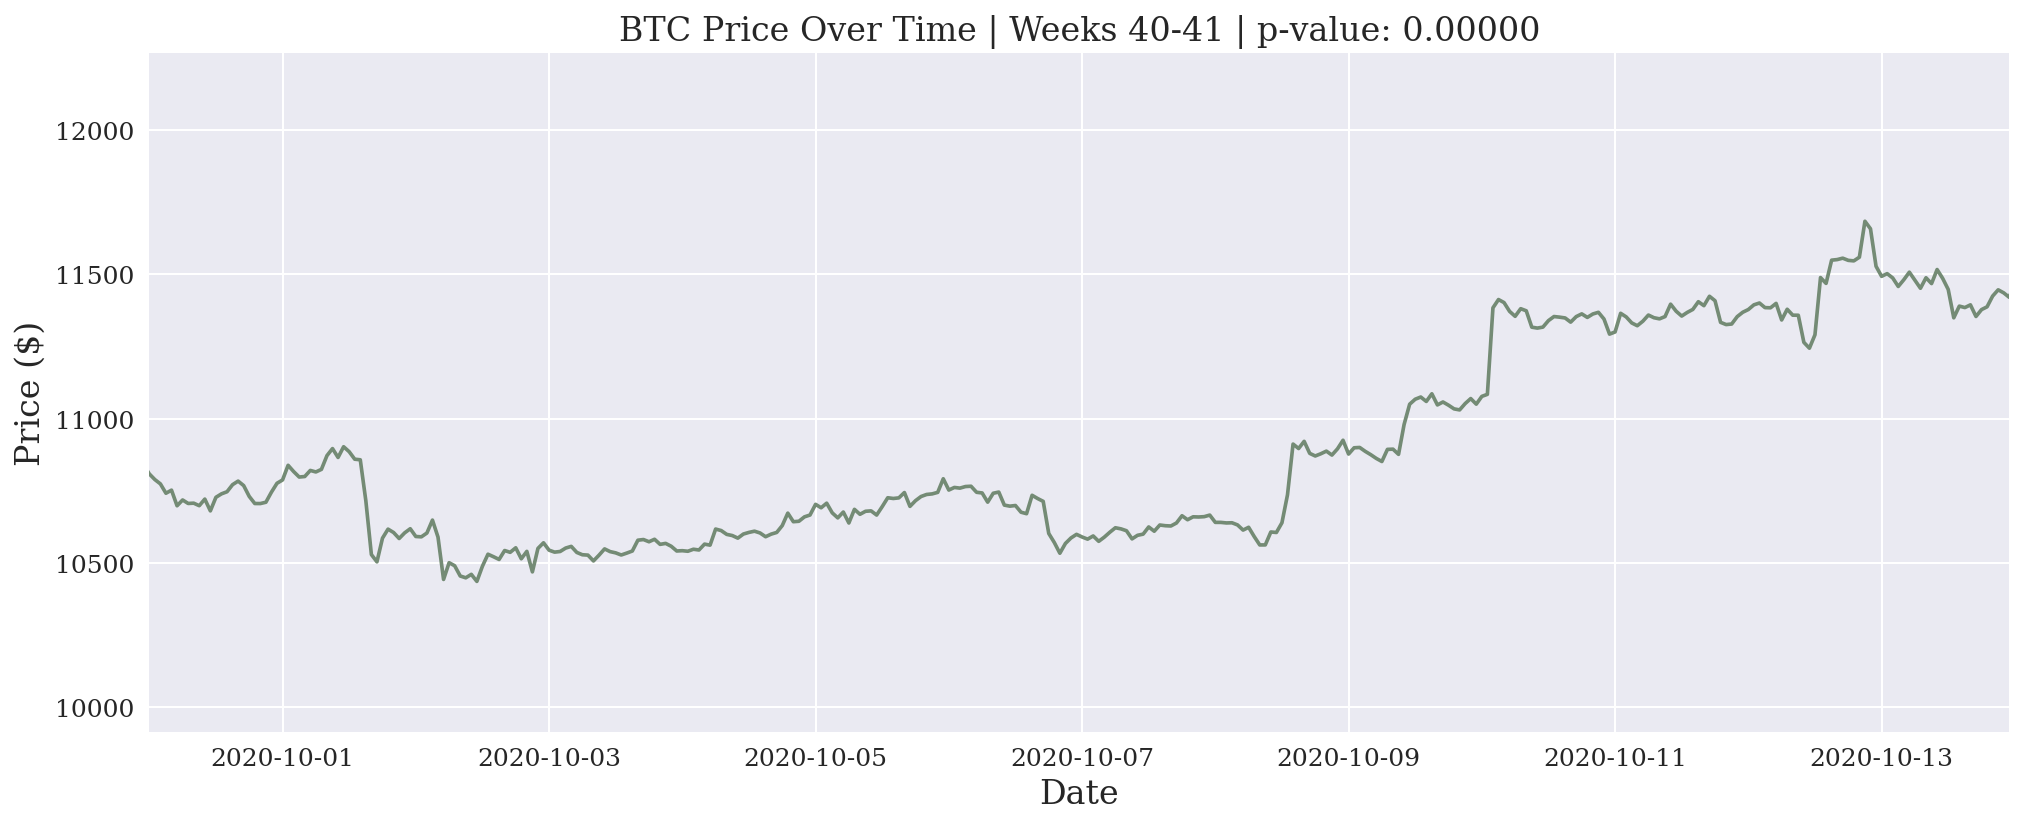

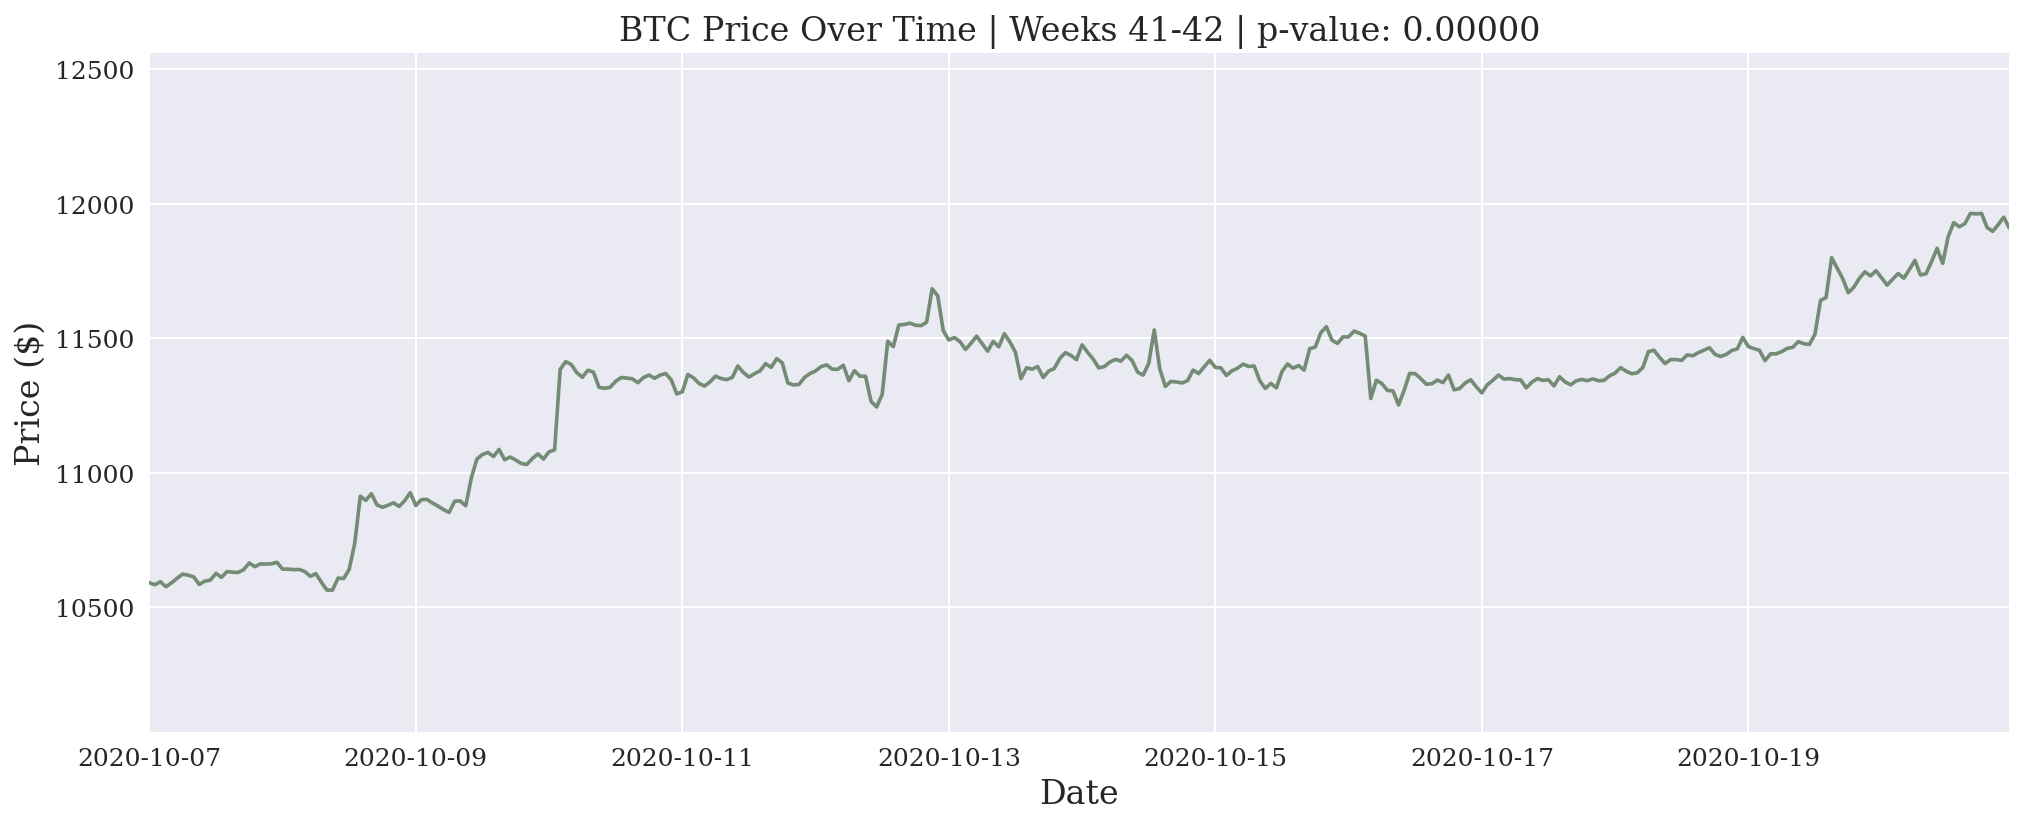

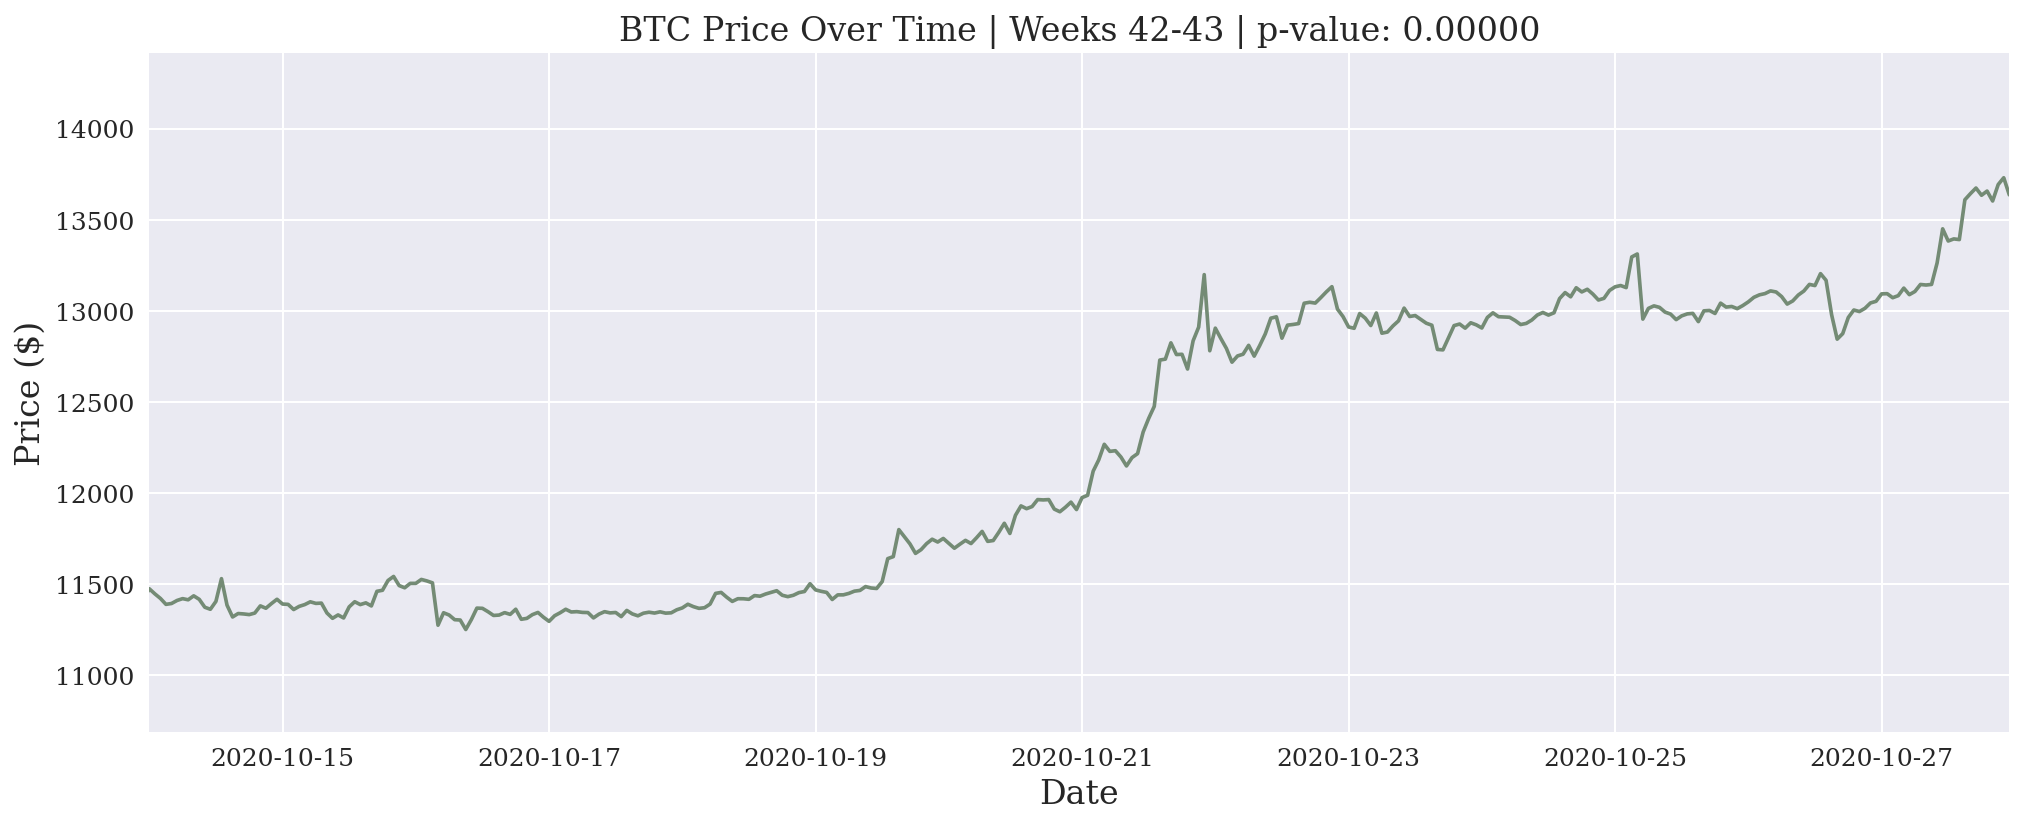

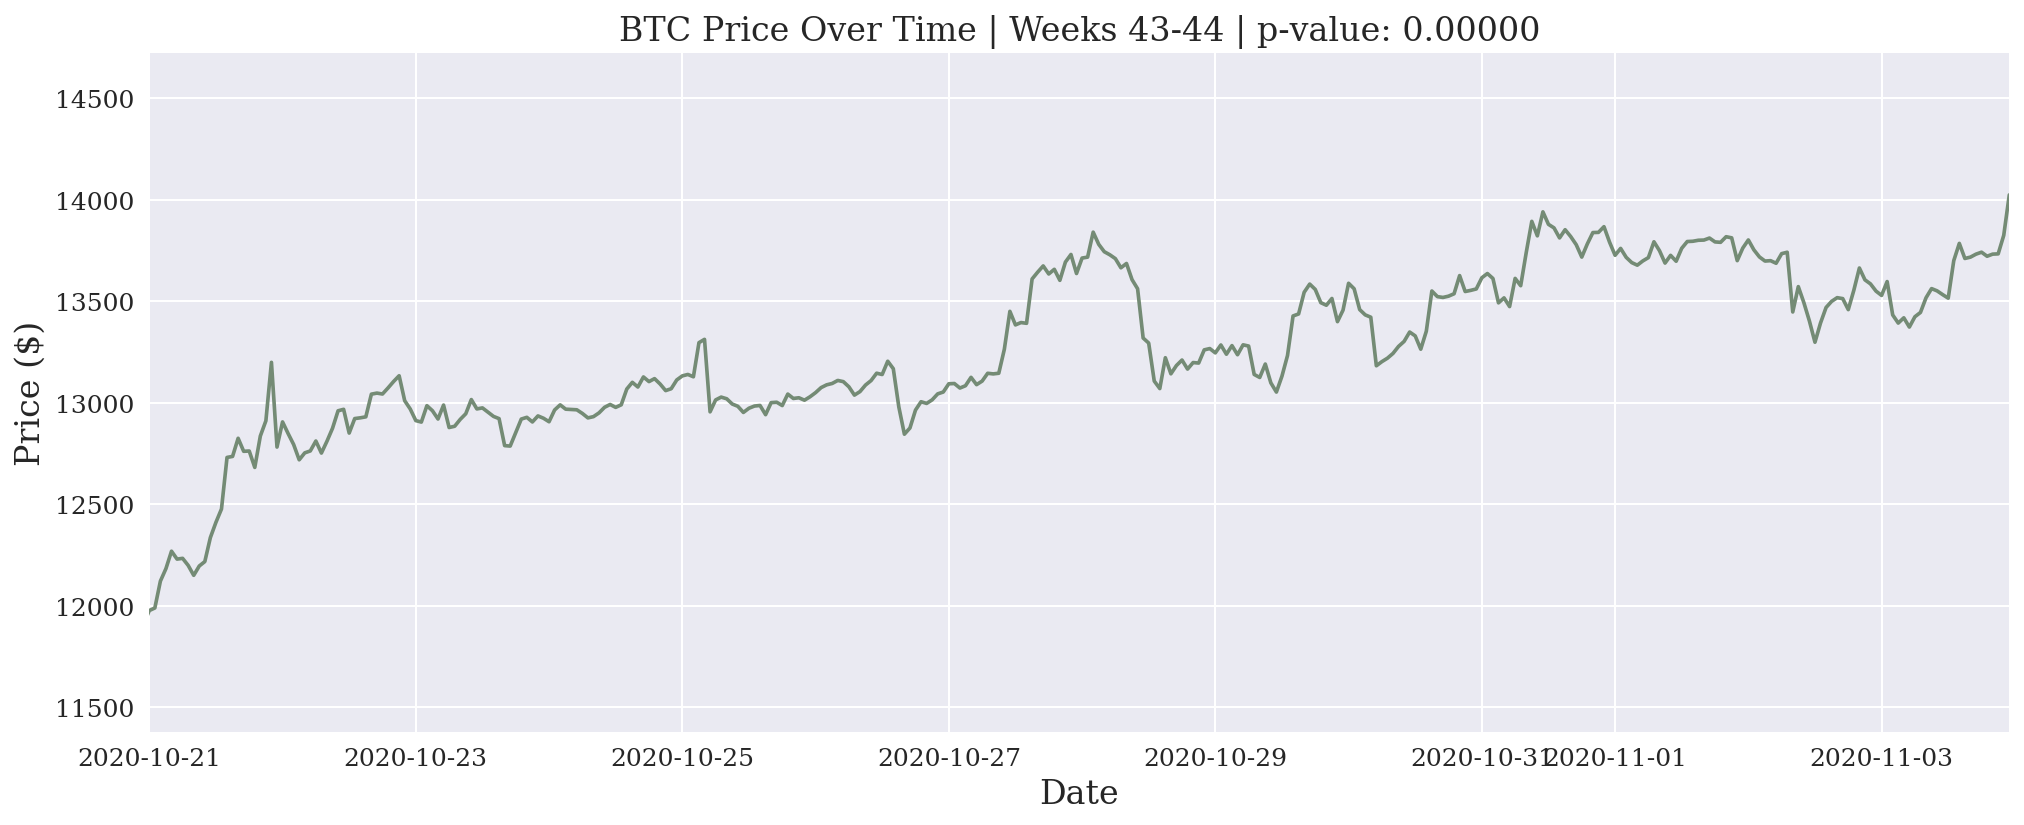

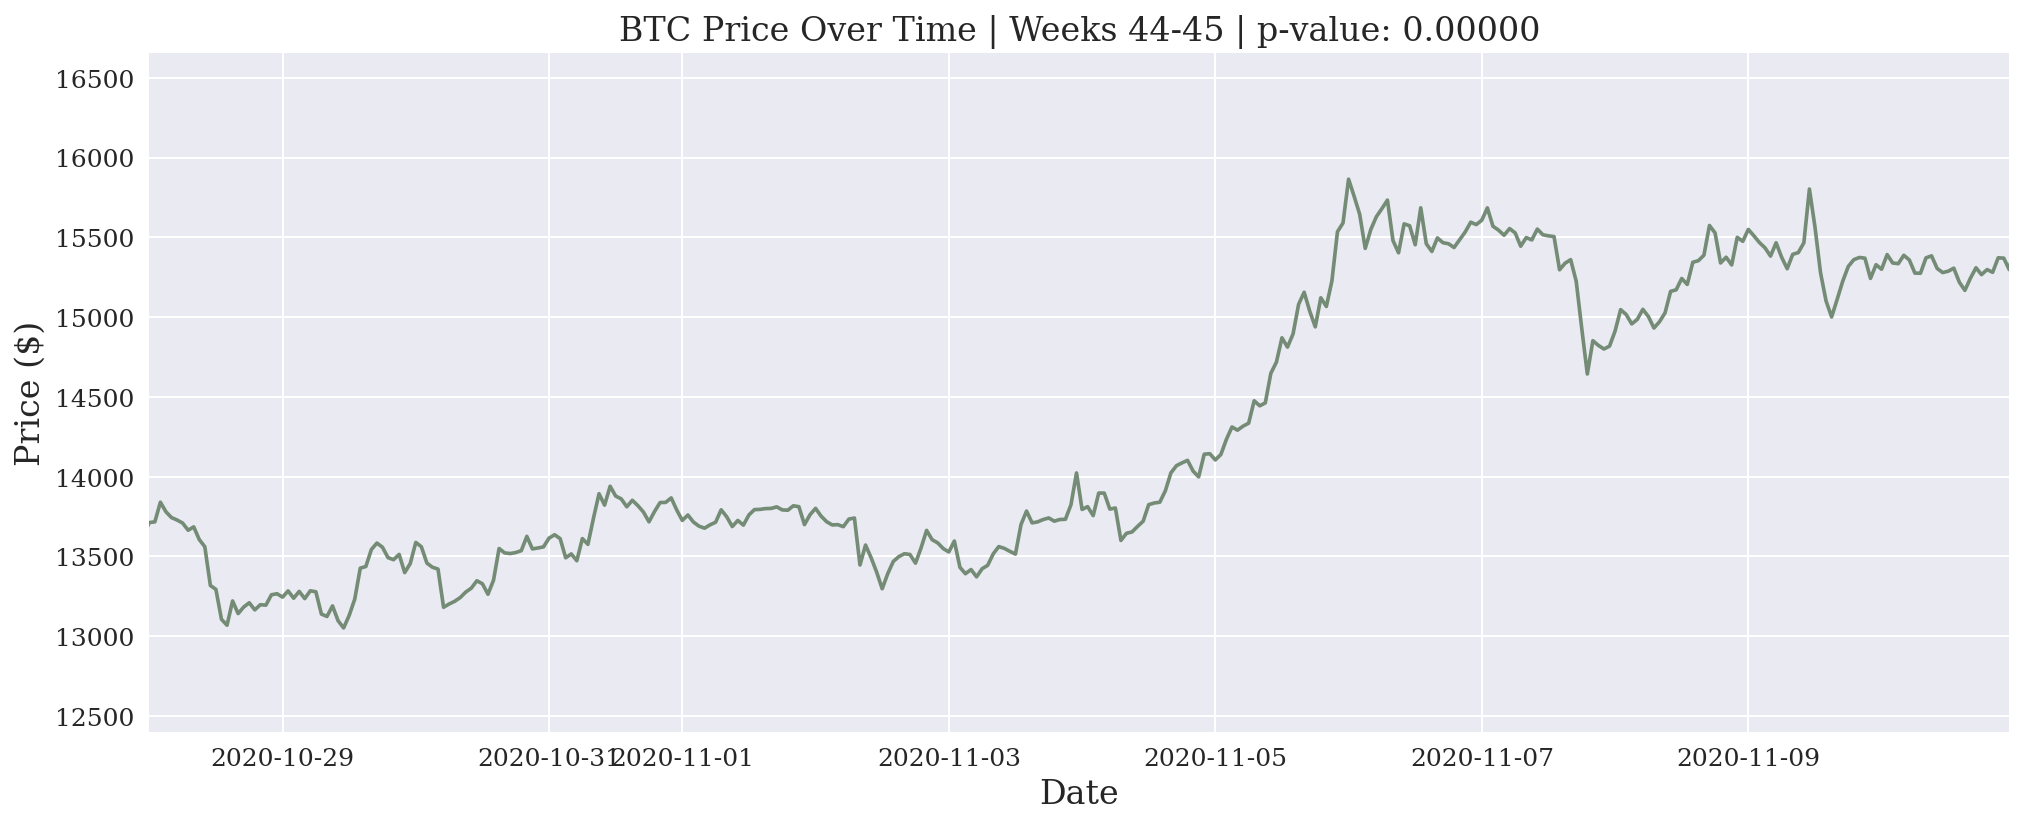

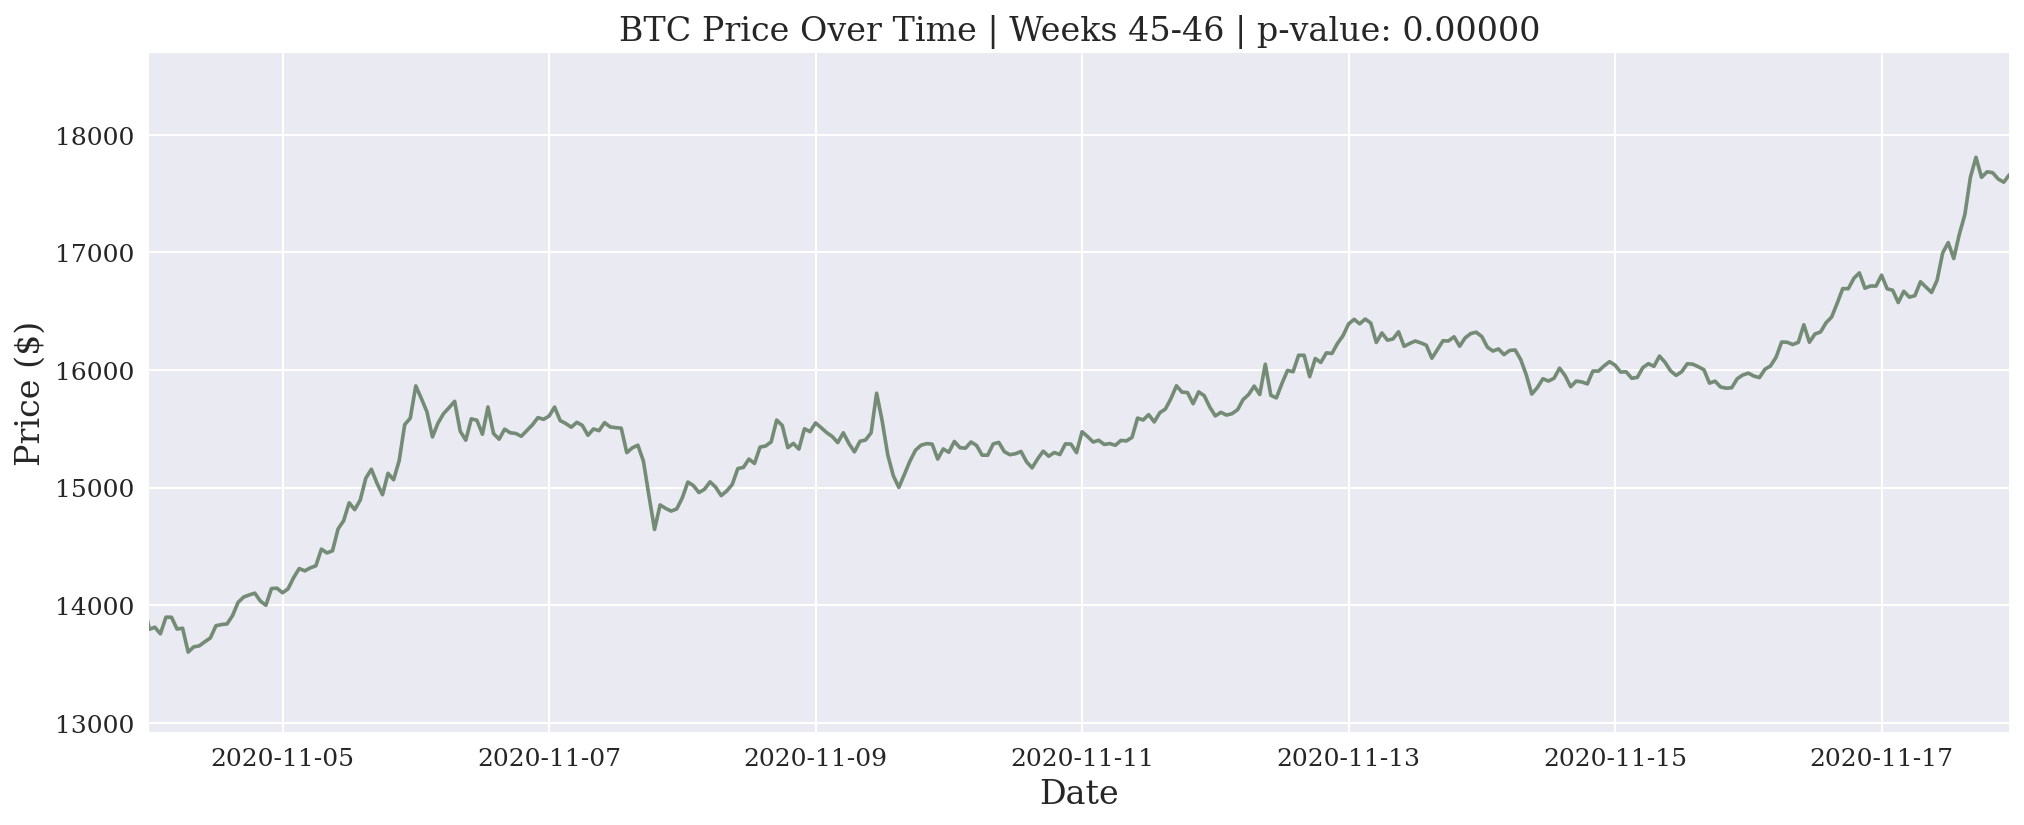

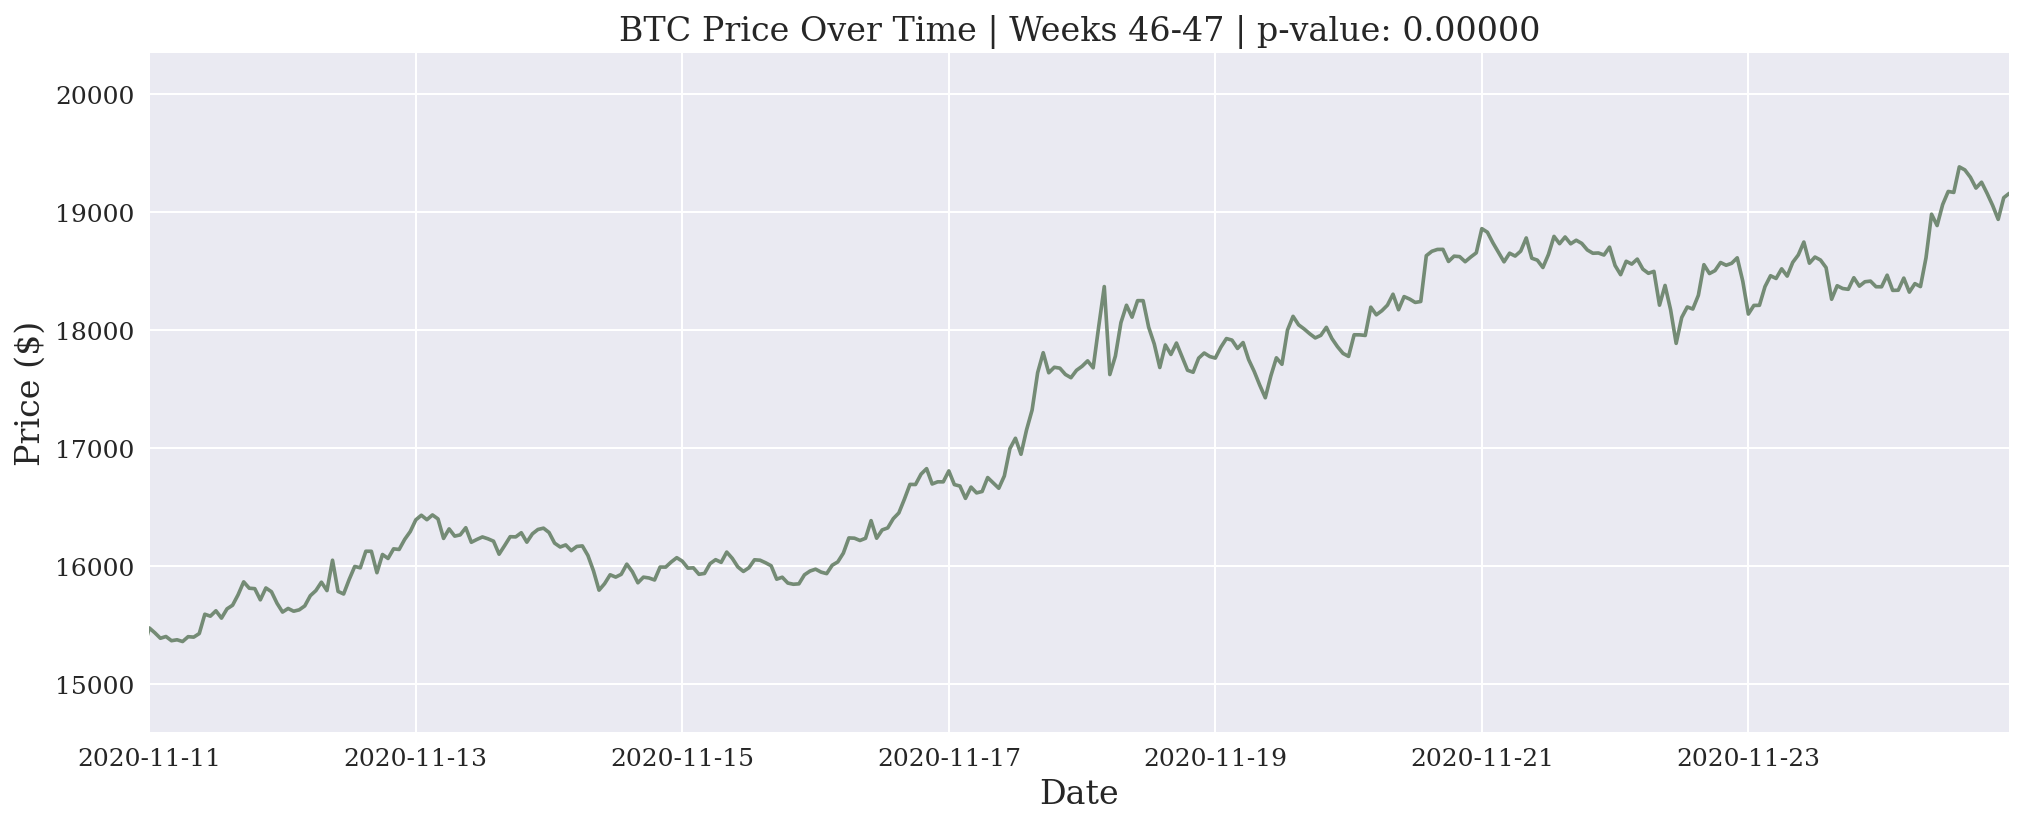

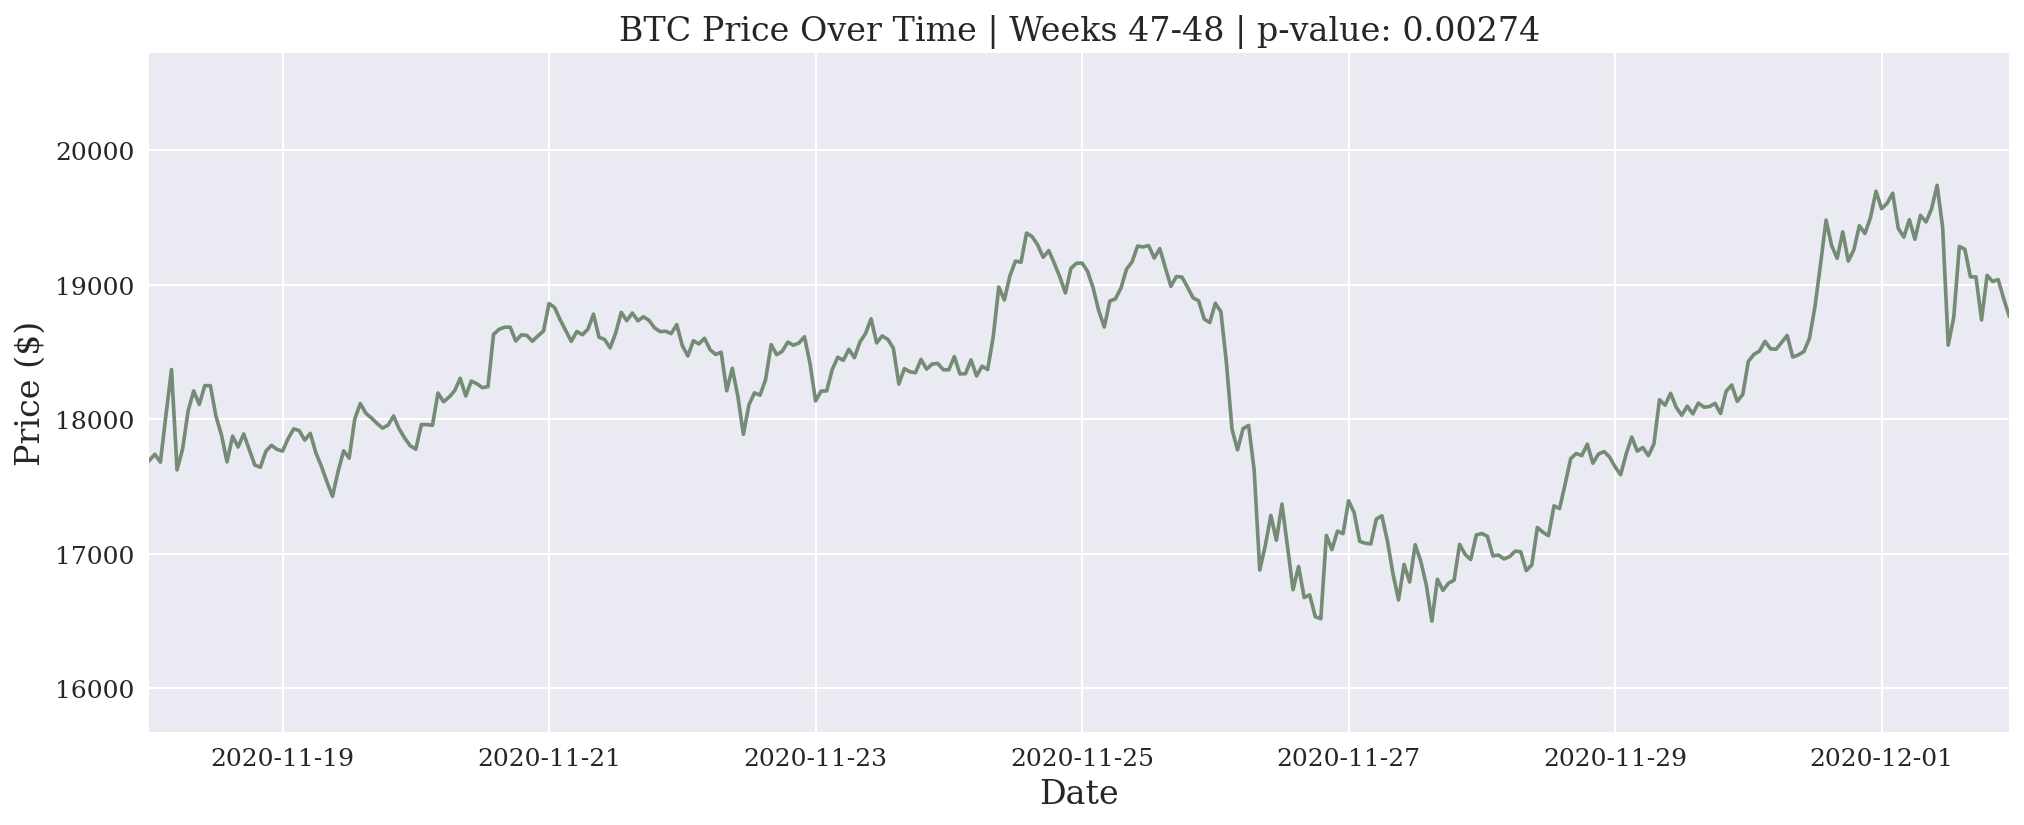

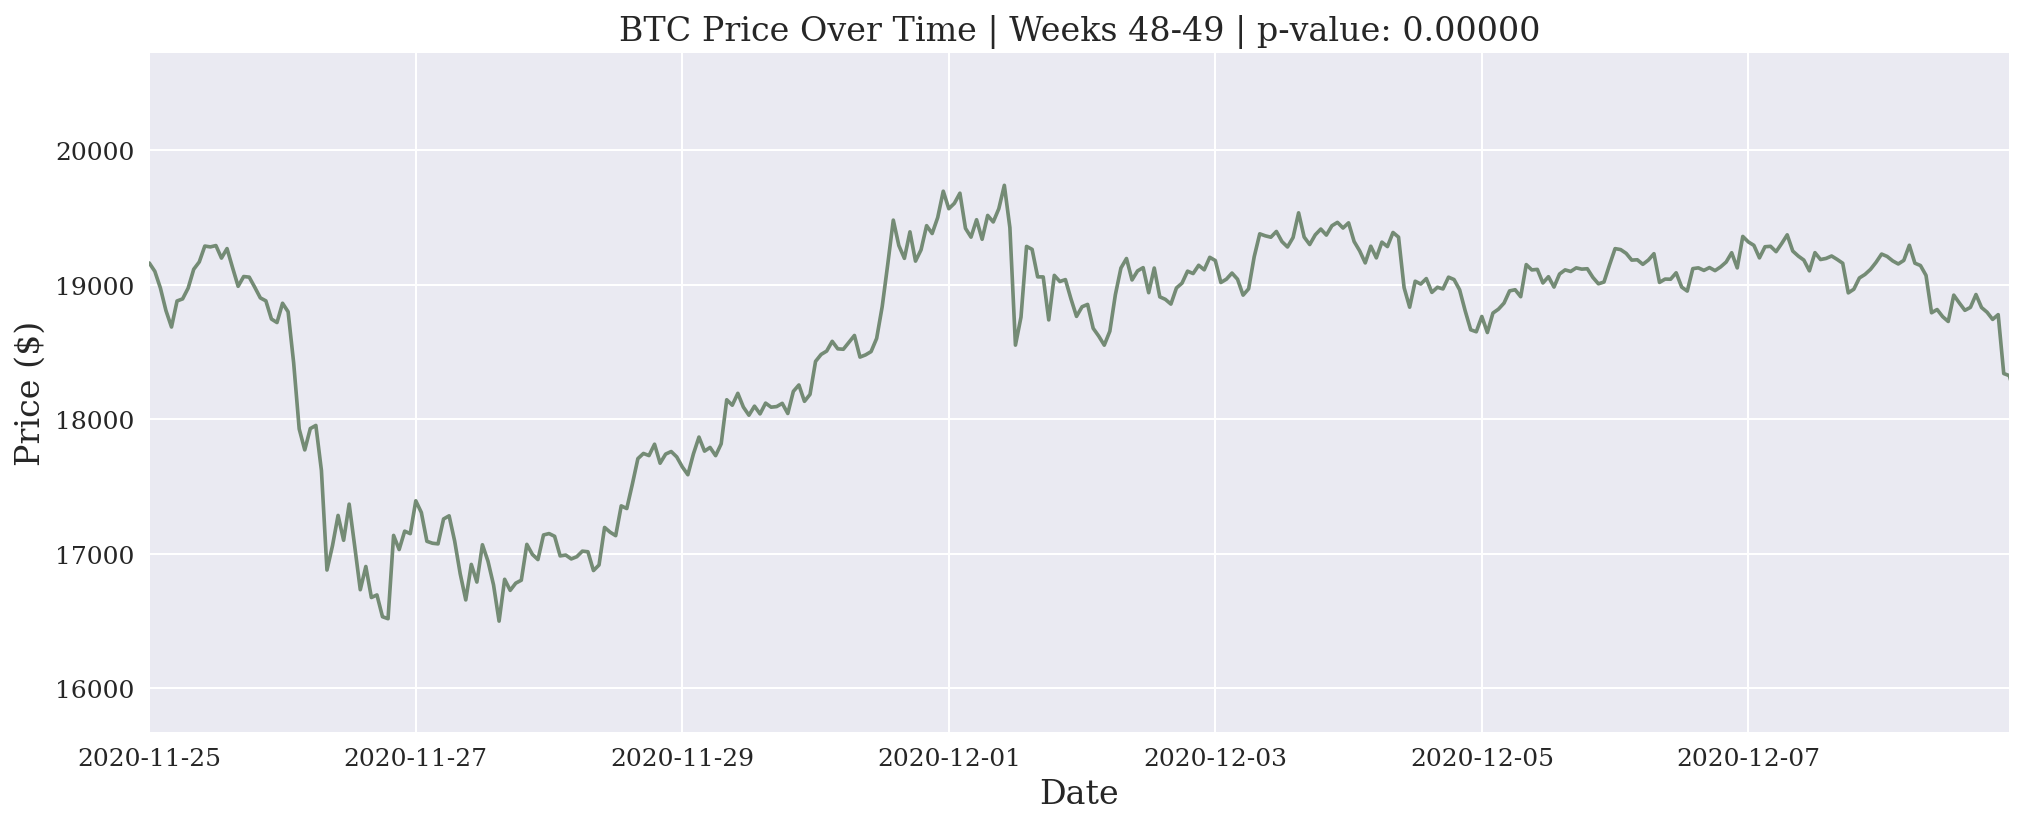

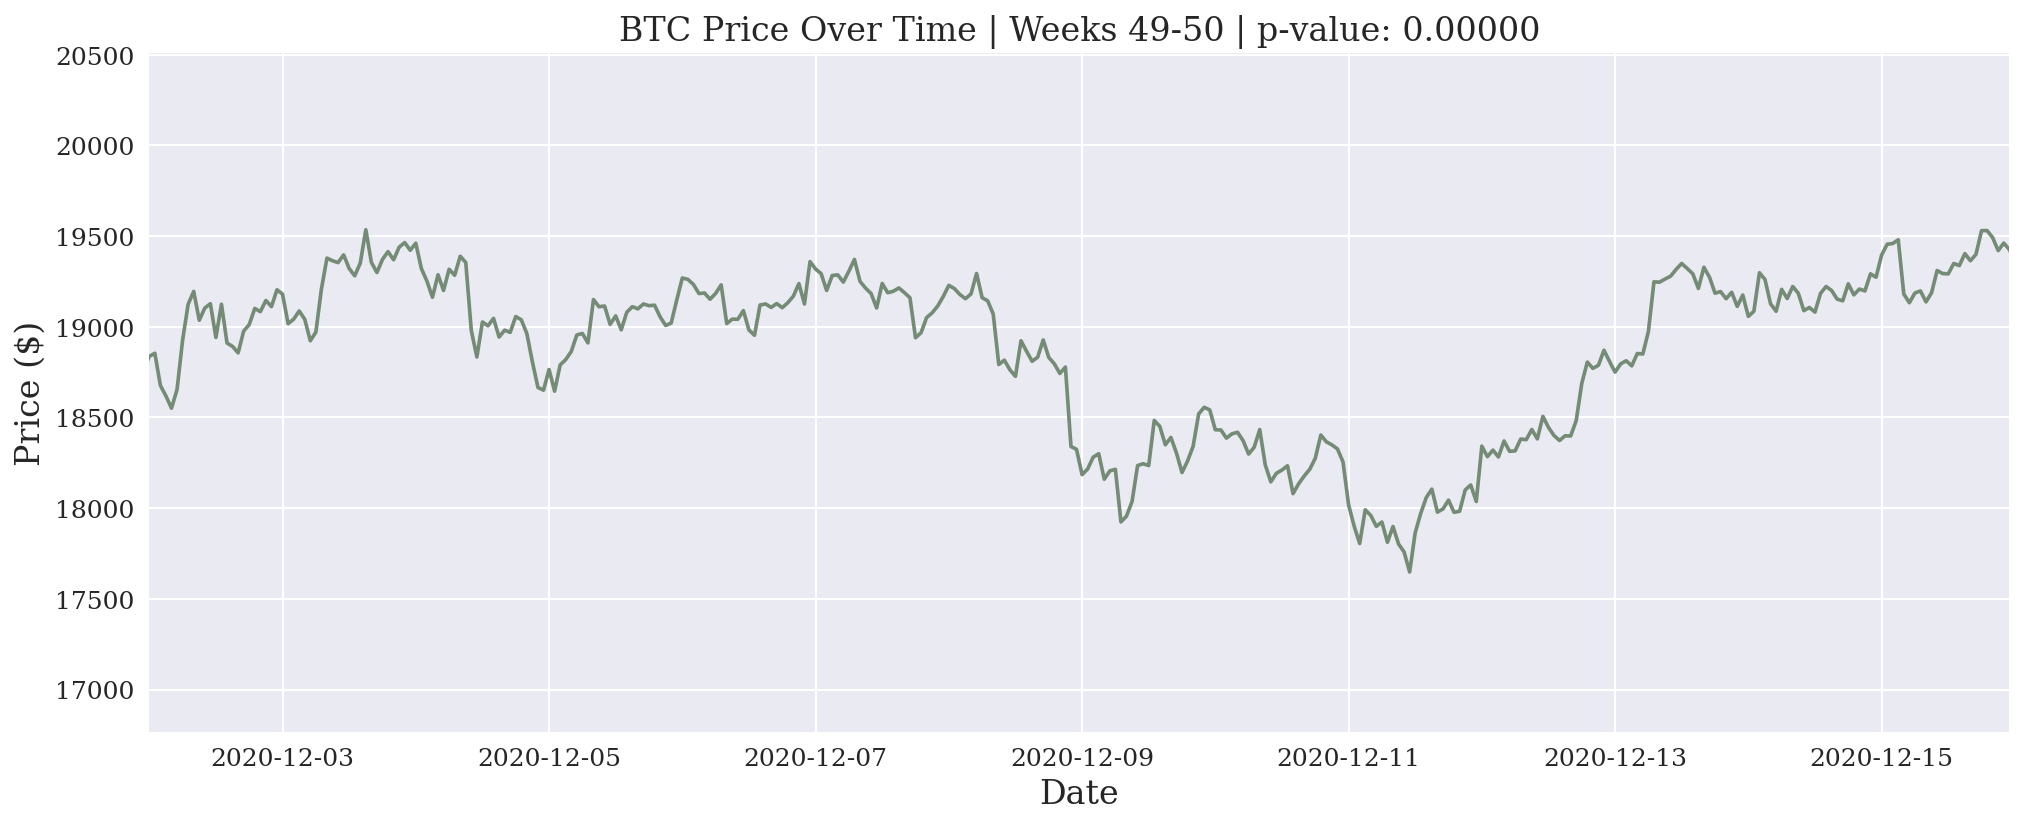

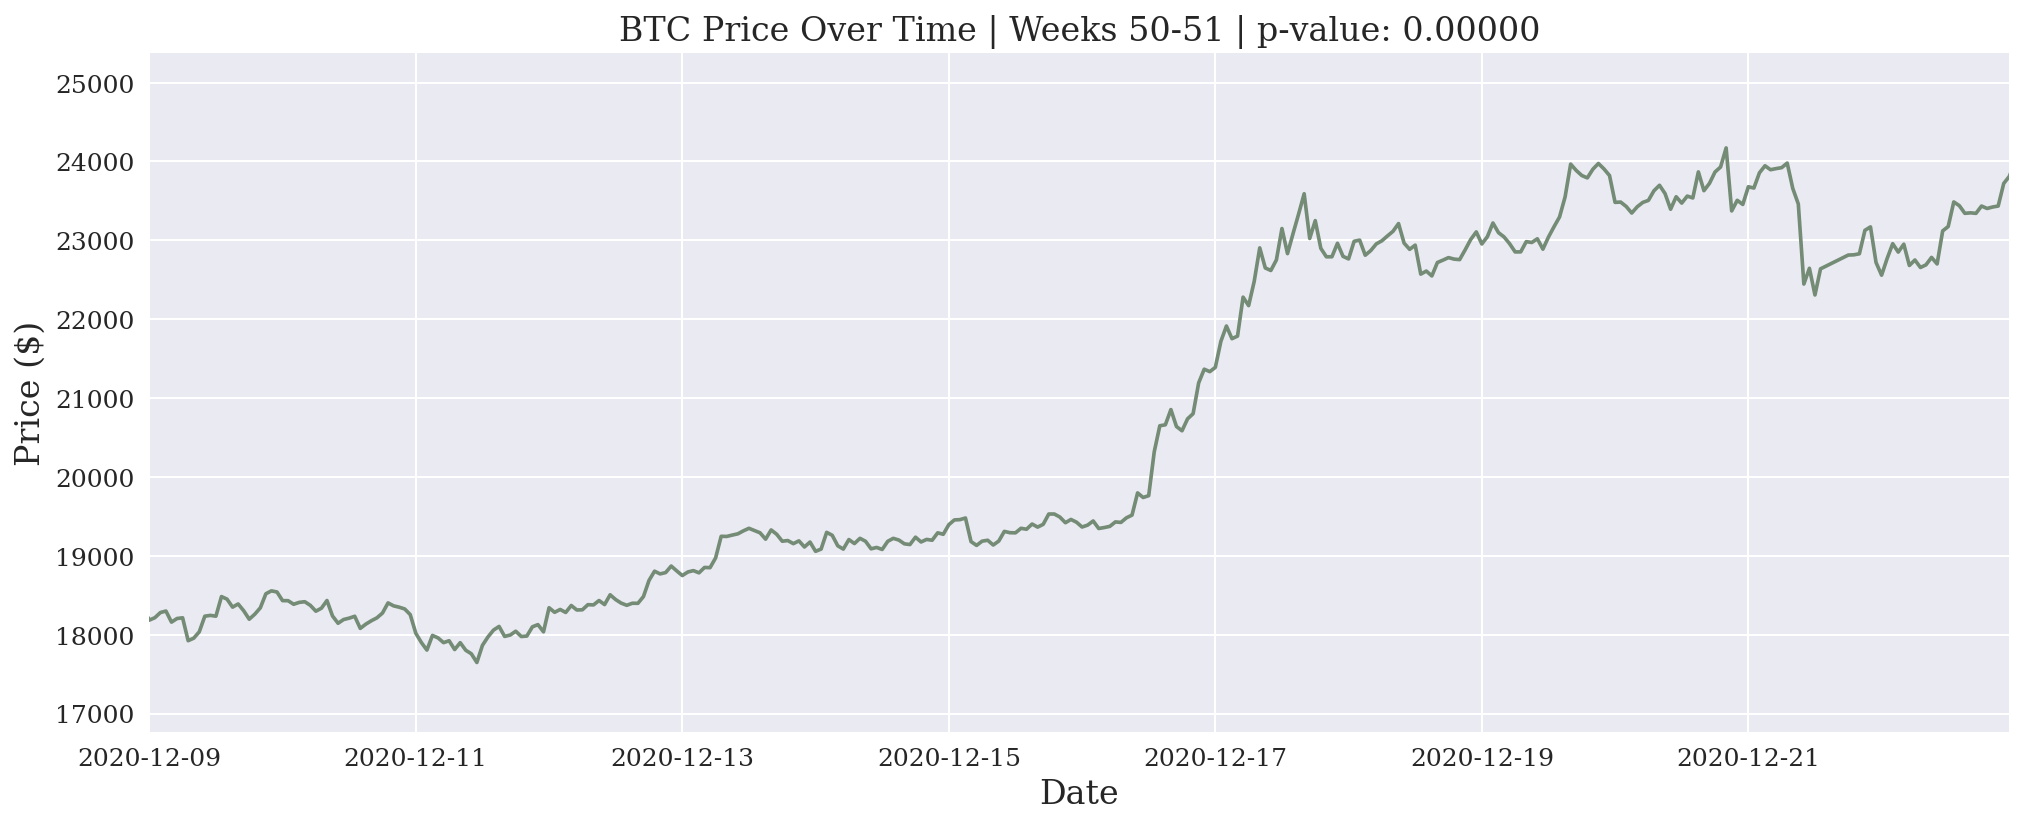

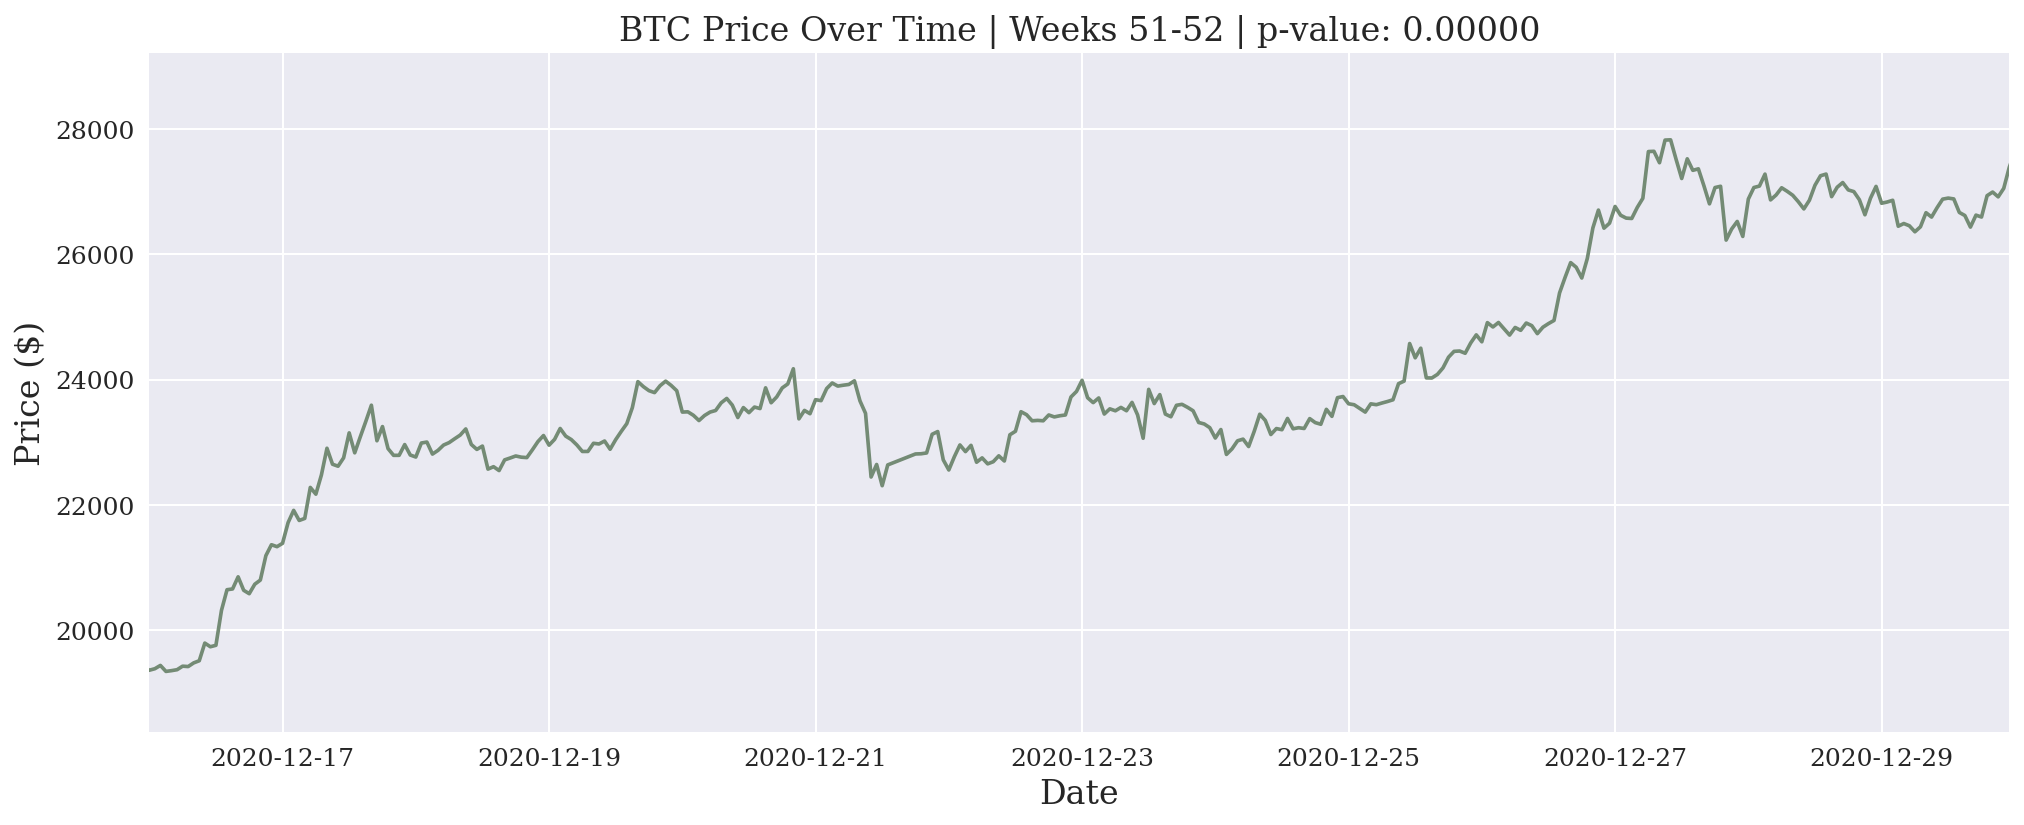

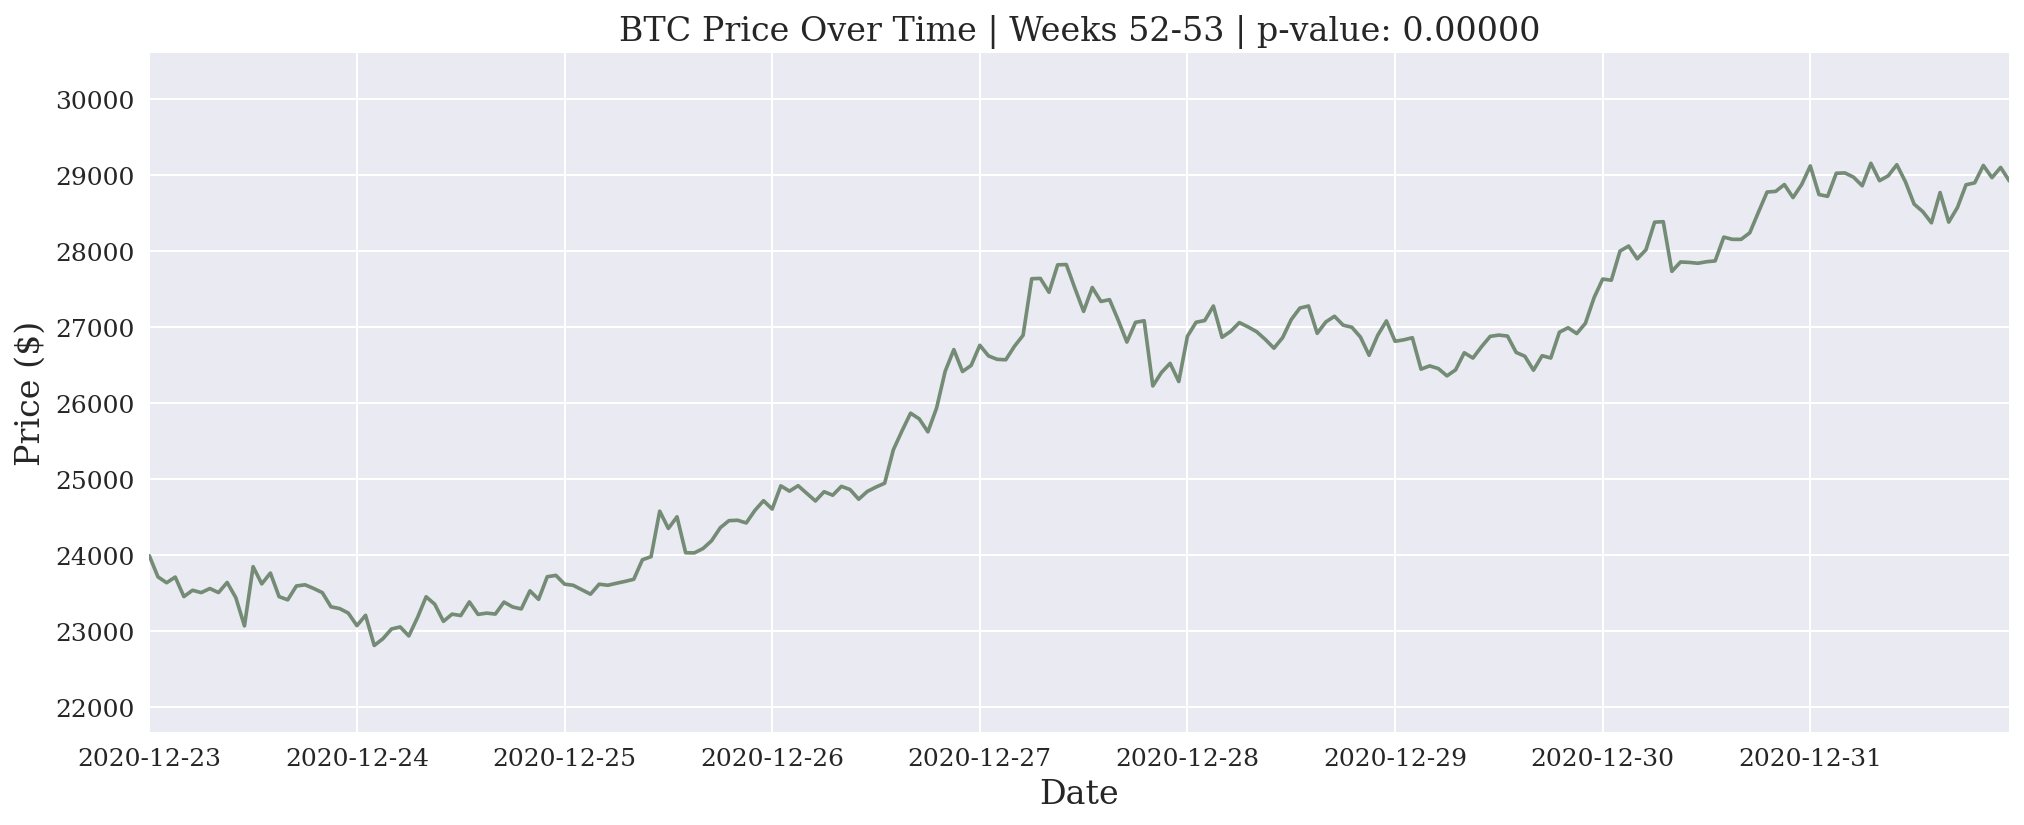

In [50]:
# For each two consecutive weeks, conduct a t-test
for week in range(1, 53):
    prev_week = df[(df.week == week)].price_close
    next_week = df[(df.week == week + 1)].price_close

    res = stats.ttest_ind(prev_week, next_week)
    
    plot_priceline(week, week+1, res.pvalue)
    plt.close()

Almost every t-test returned a small enough p-value, which means there is significant evidence to reject the Null hypothesis and accept that there is dependence between date (time) and price. Since this is a timeseries and each value is dependent on the previous price, this is logical. Also, many other factors affect the price at different points of time, meaning there is dependance between time and price.